# Swarm simulator

## Introduction

This notebook introduces a new swarm simulator. A key objective is to develop an efficient simulator using the Numpy library. The ideas behind the simulator are introduced gradually and illustrated by plotting the results using Matplotlib. Some boiler-plate code is introduced to assist with the computations and plotting.

In [1]:
"""
Some boiler-plate and functions to assist with plotting and animation
"""
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=4)
plt.rc('figure', dpi=200)
plt.rc('axes', axisbelow=True, titlesize=5)
plt.rc('lines', linewidth=1)
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.animation import FuncAnimation
import numpy as np

def mk_vplot(grid=10, grid_interval=2, *, figsize=(3,3)):
    '''
    Create a figure with a grid for plotting vectors
    
    :param grid: an int giving the minimum boundaries of the grid  - 2 * grid x 2 * grid
    :param grid_interval: an int giving spacing between grid lines
    :param figsize: tuple giving the size of the figure that will be created
    '''
    fig, ax = plt.subplots(figsize=figsize)
    limit = grid + (grid % grid_interval) 
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_aspect('equal')
    ticks = list(range(-limit, limit+1, grid_interval))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(True, linewidth=0.5, alpha=0.8)
    return fig, ax

def plot_vector(vectors, tails=None, *, colors='black', ax=None):
    '''
    Plot an array of vectors
    
    :param vectors: numpy array of shape (N,2) specifying N vectors
    :param tails: numpy array of shape (N,2) giving locations of tails for N vectors
    :param colors: either a string giving a color name or a list of size N of color names for vectors
    :param ax: the axes on which to plot the vectors - if None then plot on current axes
    '''
    if tails is None:
        tails = np.zeros_like(vectors)      # assume tails at the origin if not specified otherwise
    elif len(tails) == 1 and len(tails) < len(vectors):
        tails = np.full_like(vectors, tails[0])
    vectors_x = vectors[:,0]
    vectors_y = vectors[:,1]
    tails_x = tails[:,0]
    tails_y = tails[:,1]
    quiver_params = {'angles': 'xy',
                     'scale_units': 'xy',
                     'scale': 1,
                     'width': 0.005}
    if ax is None:
        ax = plt.gca()                     # assume plot on the current axes if not specified otherwise
    print(tails_x, tails_y, vectors_x, vectors_y)
    ax.quiver(tails_x, tails_y, vectors_x, vectors_y, color=colors, **quiver_params) # plot the vectors

A swarm comprises a set of *agents*. Each agent is defined by a number of *attributes*, including position, cohesion field, repulsion field, etc. Agent attributes will be introduced as we go along.

The principal attribute of an agent is its position in 2-D Euclidean space. We can specify an agent's position as a point, using the usual Cartesian coordinates or, equivalently, as a vector whose tail is located at the origin. For convenience and efficiency of use with Numpy, we model an agent's position as a column vector. For example, a swarm comprising a single agent, `b0`,
having an x-coordinate of 3 and a y-coordinate of 2 can be modelled as a column vector of shape (2,1), in which row 0 gives the x-coordinate, and row 1 the y-coordinate, of the single agent `b0` in column 0.

<IPython.core.display.Javascript object>


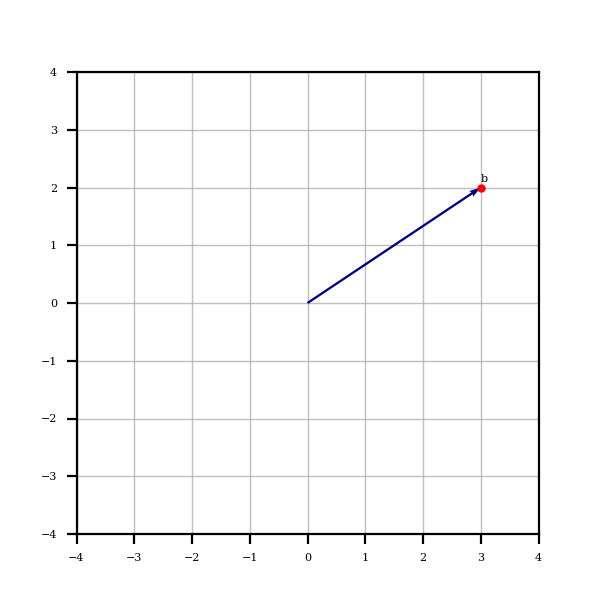

[0] [0] [3] [2]


Text(3, 2.1, 'b')

In [2]:
"""
Show an agent at position (3,2) as a vector and as a point.

Note plot_vector expects a list of points as its first argument
and draws vectors to all of them
"""
b = np.array([
    [3],             # x-coordinate
    [2]              # y-coordinate
]) 
mk_vplot(4,1)
plot_vector(b.T, colors='darkblue')
plt.plot(b[0], b[1], 'ro', markersize=2)
plt.text(3, 2.1, 'b')

Notice that `plot_vector()` requires the *transpose* of `b`, computed as `b.T`. The transpose operator, `b.T`, is implemented very efficiently in Numpy. No array data are copied. A new instance of the metadata is created in which the strides are adjusted to achieve the transposition. The transpose operator is both a convenient and an efficient mechanism for accessing all attributes of an agent in our representation.

In [3]:
print(f"b is \n{b}")
print(f"The shape of b is {b.shape}")
print(f"The transpose of b is {b.T}")
print(f"The shape of b.T is {b.T.shape}")

b is 
[[3]
 [2]]
The shape of b is (2, 1)
The transpose of b is [[3 2]]
The shape of b.T is (1, 2)


A second agent, $b1$, at position $(1.5, -1)$ can be introduced.

<IPython.core.display.Javascript object>


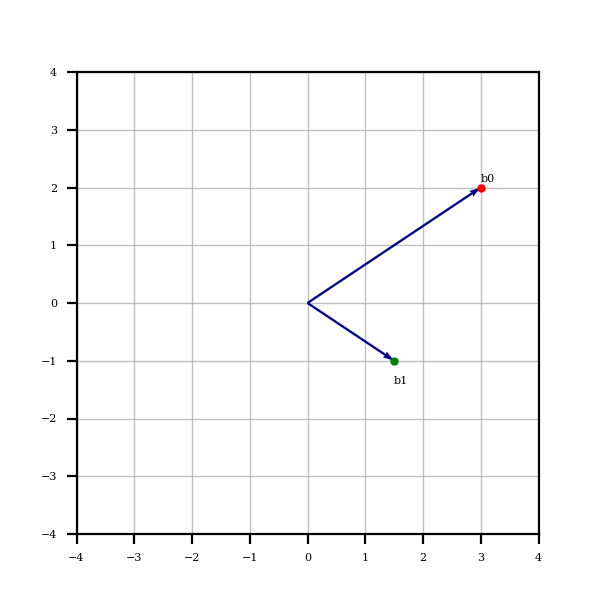

[0. 0.] [0. 0.] [3.  1.5] [ 2. -1.]


Text(1.5, -1.4, 'b1')

In [4]:
b = np.array([
    [3, 1.5],            # x-coordinates
    [2, -1]              # y-coordinates
])
mk_vplot(4,1)
plot_vector(b.T, colors='darkblue')
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(3, 2.1, 'b0')
plt.text(1.5, -1.4, 'b1')

The vector from $b_0$ to $b_1$, denoted $\vec{b_0 b_1}$, is the vector, $x$, such that $b_0 + x = b_1$, i.e. $x = b_1 - b_0$. 

<IPython.core.display.Javascript object>


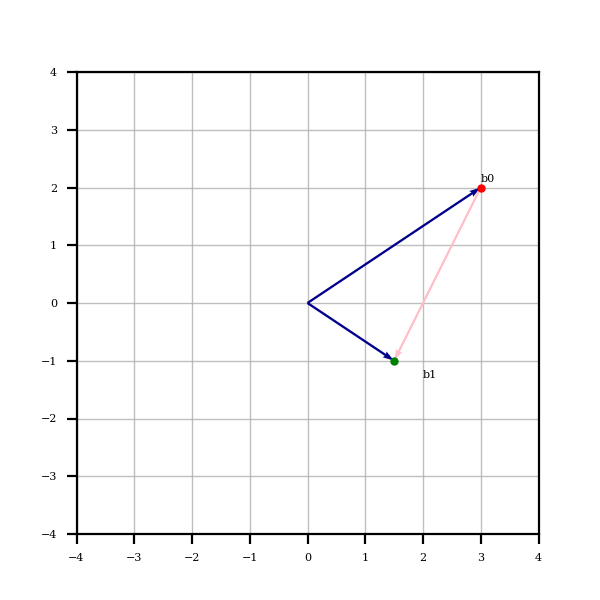

[0. 0. 3.] [0. 0. 2.] [ 3.   1.5 -1.5] [ 2. -1. -3.]


Text(2, -1.3, 'b1')

In [5]:
x = b[:,1] - b[:,0]                                                        
vectors = np.append(b.T, [x], axis=0)                                     
tails = np.zeros_like(vectors)                                              # initially all vector tails are at the origin
tails[2] = vectors[0]                                                       # set the tail of the x vector to b_0
mk_vplot(4,1)                                                               # create grid for plotting
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])        # plot the vectors
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)                                # plot b_0 as a red circle
plt.plot(b[0,1], b[1,1], 'go', markersize=2)                                # plot b_1 as a green circle
plt.text(3, 2.1, 'b0')                                                      # write some helpful text labels
plt.text(2, -1.3, 'b1')

Similarly, the vector from $b_1$ to $b_0$, denoted $\vec{b_1 b_0}$, is given by $b_0 - b_1$.

<IPython.core.display.Javascript object>


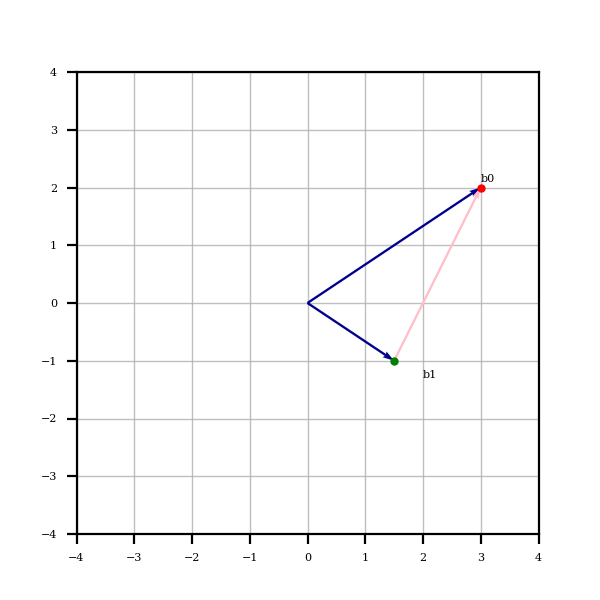

[0.  0.  1.5] [ 0.  0. -1.] [3.  1.5 1.5] [ 2. -1.  3.]


Text(2, -1.3, 'b1')

In [6]:
x = b[:,0] - b[:,1]
vectors = np.append(b.T, [x], axis=0)
tails = np.zeros_like(vectors)
tails[2] = vectors[1]
mk_vplot(4,1)
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(3, 2.1, 'b0')
plt.text(2, -1.3, 'b1')

The *magnitude* of the vector, $\vec{b_0 b_1}$, can be obtained by considering the line from $b_0$ to $b_1$ as the hypotenuse of a right-angled triangle whose other sides are parallel to the axes of the coordinate system. The `numpy` function `hypot`  returns the length of the hypotenuse, given the lengths of the other 2 sides, e.g. let $b_0 = (4, 2)$ and $b_1 = (1, -2)$, then the vector $\vec{b_0 b_1}$ has the magnitude shown below.

<IPython.core.display.Javascript object>


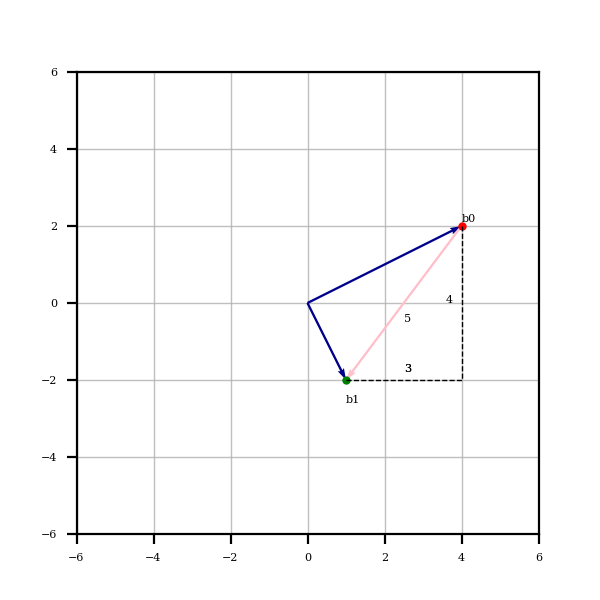

[0 0 4] [0 0 2] [ 4  1 -3] [ 2 -2 -4]
The magnitude of the vector from b0 to b1 is 5.0


In [7]:
b = np.array([
    [4, 1],            # x-coordinates
    [2, -2]            # y-coordinates
])
x = b[:,1] - b[:,0]
vectors = np.append(b.T, [x], axis=0)
tails = np.zeros_like(vectors)
tails[2] = vectors[0]
mk_vplot(6,2)
plot_vector(vectors, tails, colors=['darkblue', 'darkblue', 'pink'])
plt.plot(b[0,0], b[1,0], 'ro', markersize=2)
plt.plot(b[0,1], b[1,1], 'go', markersize=2)
plt.text(4, 2.1, 'b0')
plt.text(1, -2.6, 'b1')
plt.plot([1,4,4], [-2,-2,2], 'k--', linewidth=0.5)
plt.text(2.5, -1.8, '3')
plt.text(2.5, -1.8, '3')
plt.text(3.6, 0., '4')
plt.text(2.5, -0.5, '5')
magx = np.hypot(b[0,0] - b[0,1], b[1,0] - b[1,1])
print(f"The magnitude of the vector from b0 to b1 is {magx}")

We denote the magnitude of $\vec{b_0 b_1}$ by $\big\lVert \vec{b_0 b_1} \big\rVert$.

## Cohesion and Repulsion Fields

Agents in a swarm have two main goals: 

    1. to stay close to other agents, and 
    2. to avoid bumping into other agents.
    
The first goal involves defining a 'cohesion' field, $C_b$, for each agent $b$. The cohesion field of $b$ is specified as a circle of given radius, centred at $b$. Any agent $b'$ that is positioned within the cohesion field of $b$ inclines $b$ to move towards $b'$. The second goal involves defining a 'repulsion' field, $R_b$, in a similar manner to the definition of the cohesion field. Any agent $b'$ that is positioned within the repulsion field of $b$ inclines $b$ to move away from $b'$. Notice that an agent $b'$ that is positioned both within  $b$'s cohesion field *and* its repulsion field will cause $b$ to have conflicting inclinations: both to move towards and to move away from $b'$. The final movement of $b$ depends on the 'strength' of these inclinations.

Two new rows are added to the swarm representation. One row gives the cohesion field for each agent. The other defines the repulsion field. 

Note: A swarm can be represented in the simulator in a variety of ways. The goal here is to find a representation that leads to an efficient implementation of the simulator using Numpy. Here we choose a representation based on a 2-D array in which each row models a single attribute for all agents and each column models all attributes for a single agent, e.g.

| | b0 | b1 | ... | bn |
|---|---|---|---|---|
|x  |   |   |   |   |
|y  |   |   |   |   |
|C  |   |   |   |   |
|R  |   |   |   |   |
|. |   |   |   |   |
|.  |   |   |   |   |
|.  |   |   |   |   |

This is not the most convenient representation when plotting a few agents from a small swarm but it is hoped that it allows efficient implementation of the major operations in the simulator, by taking advantage of Numpy's vectorised operators.

We define a 'helper' function, `plot_field()`, to assist in the illustration of cohesion and repulsion fields.

In [8]:
def plot_field(radius=1.0, fmt='b-', *, linewidth=0.5, pos=(0.0, 0.0)):
    '''
    Draw a circle of specified radius on the current axis
    
    :param radius: the radius of the circle
    :param fmt: the colour and style of line for drawing the circle
    :param linewidth: the width of the line for drawing the circle
    :param pos: the location of the centre of the circle
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = radius*np.cos(theta) + pos[0]
    x2 = radius*np.sin(theta) + pos[1]
    ax = plt.gca()
    ax.plot(x1, x2, fmt, linewidth=linewidth)
    ax.set_aspect(1)


Now consider an agent, $b_0$, at the origin, with a repulsion field of radius 5 and a cohesion field of radius 7. This can be illustrated as follows:

<IPython.core.display.Javascript object>


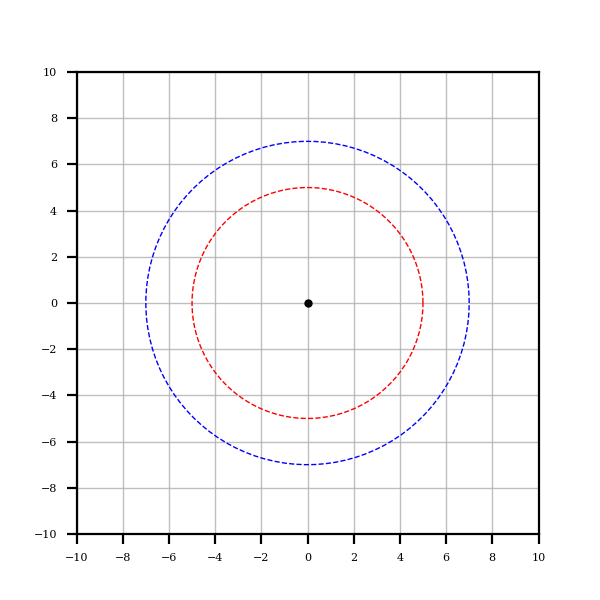

In [9]:
b = np.array([
    [0], # x coordinate
    [0], # y coordinate
    [7], # cohesion field radius
    [5], # repulsion field radius
])
mk_vplot()
plot_field(b[2], 'b--')                      # draw the cohesion field of b[0]
plot_field(b[3], 'r--')                      # draw the repulsion field of b[0]
plt.plot(b[0], b[1], 'ko', markersize=2)     # draw the point for b[0]

## Cohesion vectors

Let's introduce a 2nd agent, $b_1$, into the previous scenario. We'll place $b_1$ at $(3, 3)$, which is within the cohesion field of $b_0$, and observe its effect on $b_0$. 

At this point, notice that it is important to be able to determine, for any agent, which agents are within its cohesion and repulsion fields. The necessary computation is introduced here. We begin by computing the pairwise distances between agents and determining, for each agent pair, whether one agent is within the cohesion / repulsion fields of the other. 

Notice that some constants are introduced to identify the rows of agent attributes in the swarm array. This aids the readability and maintainability of the code, without adversely affecting its performance too much (...it may be worth looking at structured arrays as an alternative to this approach). Some rows are introduced into the array to hold the results of computations of cohesion and repulsion vectors. It is expected that this approach will simplify the saving of swarm states when that functionality is introduced later.

<IPython.core.display.Javascript object>


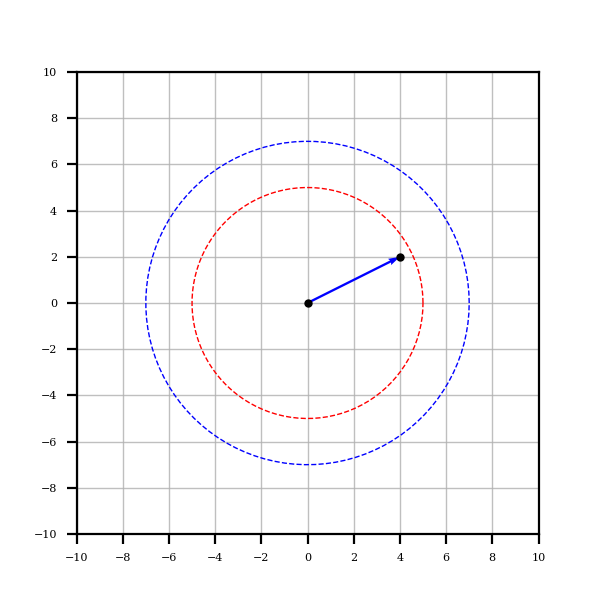

[0. 0.] [0. 0.] [0. 4.] [0. 2.]


In [10]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 4.0], # x-coordinates of agents' position
    [0.0, 2.0], # y-coordinates of agents' position
    [0.0, 0.0], # x-coordinates of cohesion vector
    [0.0, 0.0], # y-coordinates of cohesion vector
    [0.0, 0.0], # x-coordinates of repulsion vector
    [0.0, 0.0], # y-coordinates of repulsion vector
    [7.0, 7.0], # cohesion field radii
    [5.0, 5.0], # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)   # where coh_n is True take the corresponding value from xv, otherwise 0.0
yv_coh = np.where(coh_n, yv, 0.0)   # where coh_n is True take the corresponding value from yv, otherwise 0.0

# compute the cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# do plotting of results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))   # get cohesion vector for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                    # draw the cohesion vector from b[0] to b[1]

It's worth having a look at some of the intermediate data structures in the previous example.

The `xv` (resp. `yv`) array holds all pairwise x-differences (resp. y-differences). The cell `xv[i,j]` is set to `b[POS_X, i] - b[POS_X, j]`, i.e. it gives the difference in x-value between the positions of agent `i` and agent `j`; Similarly, `yv[i,j]` is set to `b[POS_Y, i] - b[POS_Y, j]`, i.e. it gives the difference in y-value between the positions of agent `i` and agent `j`. Note that the x- and y-values for the vector $\vec{b_i b_j}$ are to be found at `xv[j,i]` and `yv[j,i]`, respectively. The `mag` array holds all pairwise magnitudes. The distance between agent `i` and agent `j`, or equivalently, the magnitude of the vector 
$\vec{b_i b_j}$, is to be found at `mag[j,i]`. Of course, in any sane world, $\lVert\vec{b_i b_j}\rVert = \lVert\vec{b_j b_i}\rVert$ but you can't be too careful!

In [11]:
print(f"xv is \n {xv}")
print(f"yv is \n {yv}")
print(f"mag is \n {mag}")

xv is 
 [[ 0. -4.]
 [ 4.  0.]]
yv is 
 [[ 0. -2.]
 [ 2.  0.]]
mag is 
 [[0.         4.47213595]
 [4.47213595 0.        ]]


The array `coh_n` is a boolean array where `coh_n[i, j]` is `True` if the position of agent i lies within the cohesion field of agent j, i.e. agent i is a cohesion *neighbour* of agent j. So `coh_n[:, j]` gives all the cohesion neighbours of agent `j`. The array `nr_coh_n` gives the number of cohesion neighbours of each agent. Note `np.sum()` counts every `True` as 1 and every `False` as 0. We are summing along `axis=0`, i.e. down the rows, so, for example, `nr_coh_n[j]` gives the number of cohesion neighbours of agent `j`.

In [12]:
print(f"coh_n is \n {coh_n}")
print(f"nr_coh_n is \n {nr_coh_n}")

coh_n is 
 [[False  True]
 [ True False]]
nr_coh_n is 
 [1 1]


The array `xv_coh` (resp. `yv_coh`) is the same as `xv` (resp. `yv`) in those cells, `xv[i, j]` (resp. `yv[i, j]`), where `coh_n[i, j]` is `True` and is 0.0 in the remaining cells. The final x- and y-values of the cohesion vectors are computed by summing down the rows (axis=0) in `xv_coh` and `yv_coh` and dividing by the number of cohesion neighbours. See below.

In [13]:
print(f"xv_coh is \n {xv_coh}")
print(f"yv_coh is \n {yv_coh}")
print(f"b[COH_X:COH_Y+1] is \n {b[COH_X:COH_Y+1]}")

xv_coh is 
 [[ 0. -4.]
 [ 4.  0.]]
yv_coh is 
 [[ 0. -2.]
 [ 2.  0.]]
b[COH_X:COH_Y+1] is 
 [[ 4. -4.]
 [ 2. -2.]]


##  Repulsion vectors

The presence of $b_1$ within the cohesion field of $b_0$ gives $b_0$ an inclination to move towards $b_1$. 
The 'strength' of the inclination is given by $\lVert\vec{b_0 b_1}\rVert$. Notice also that $b_1$ lies within the repulsion field of $b_0$. This gives $b_0$ an inclination to move away from $b_1$. This is calculated as 
$(\frac{\lVert\vec{b_0 b_1}\rVert}{R_{b_0}} - 1)\vec{b_0 b_1}$. The factor $(\frac{\lVert\vec{b_0 b_1}\rVert}{R_{b_0}} - 1)$ is used to reverse the direction, and to dampen the effect, of $\vec{b_0 b_1}$, giving $b_0$ a 'gentle' inclination to move away from $b_1$. This can be illustrated by adding a new vector to the previous figure, as follows:

<IPython.core.display.Javascript object>


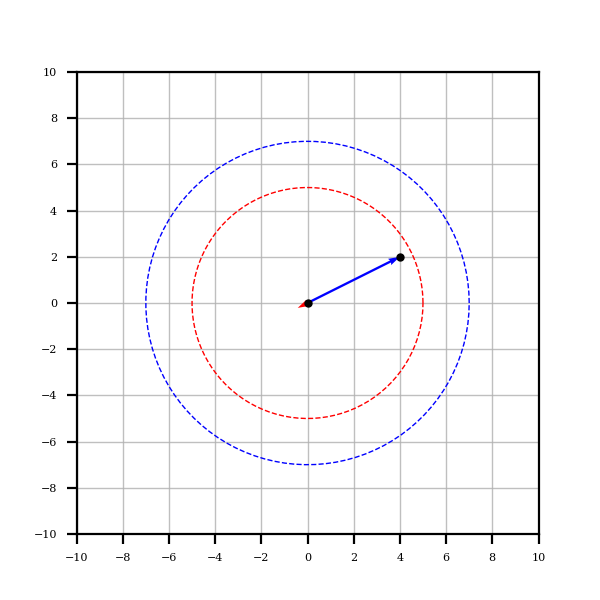

[0. 0.] [0. 0.] [0. 4.] [0. 2.]
[0. 0.] [0. 0.] [ 0.         -0.42229124] [ 0.         -0.21114562]


In [14]:
# compute the repulsion neighbours
rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences  for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))                 # get cohesion vectors for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                                  # draw the cohesion vector from b[0] to b[1]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]


At this stage, the repulsion effect is negligible (you can just about see a tiny red arrow pointing away from the origin). However, observe what happens when $b_1$ approaches closer to $b_0$.

<IPython.core.display.Javascript object>


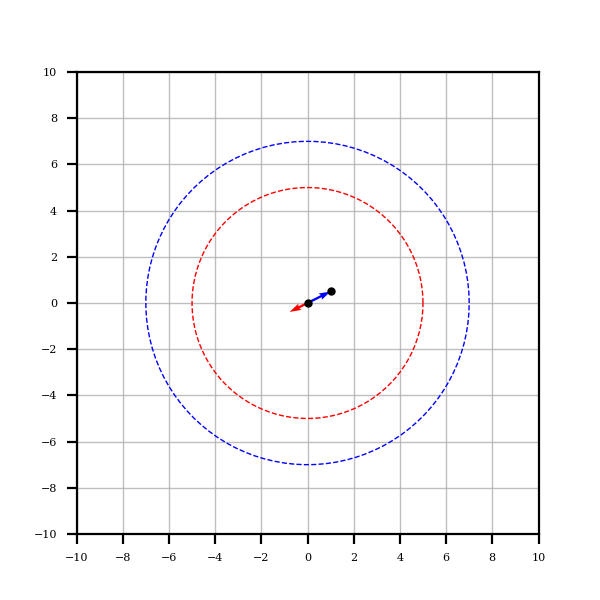

[0. 0.] [0. 0.] [0. 1.] [0.  0.5]
[0. 0.] [0. 0.] [ 0.        -0.7763932] [ 0.        -0.3881966]


In [15]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0], # x-coordinates of agents' position
    [0.0, 0.5], # y-coordinates of agents' position
    [0.0, 0.0], # x-coordinates of cohesion vector
    [0.0, 0.0], # y-coordinates of cohesion vector
    [0.0, 0.0], # x-coordinates of repulsion vector
    [0.0, 0.0], # y-coordinates of repulsion vector
    [7.0, 7.0], # cohesion field radii
    [5.0, 5.0], # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences  and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                         # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                         # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                    # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))               # get cohesion vectors for agent 0 - just for plotting              
plot_vector(coh_v_0, colors='blue')                                # draw the cohesion vector from b[0] to b[1]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))               # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                  # draw the repulsion vector from b[0] to b[1]

Now the repulsion effect is a little stronger.
Puzzlingly, however, as $b_1$ continues to approach $b_0$, drawing closer to it, even to the point of collision, the repulsion effect eventually begins to grow *weaker*. We'll return to this anomaly later.

Now consider what happens if a third agent is added to this scenario, at position $(-2, 3)$ with cohesion field $7$ and repulsion field $5$.

<IPython.core.display.Javascript object>


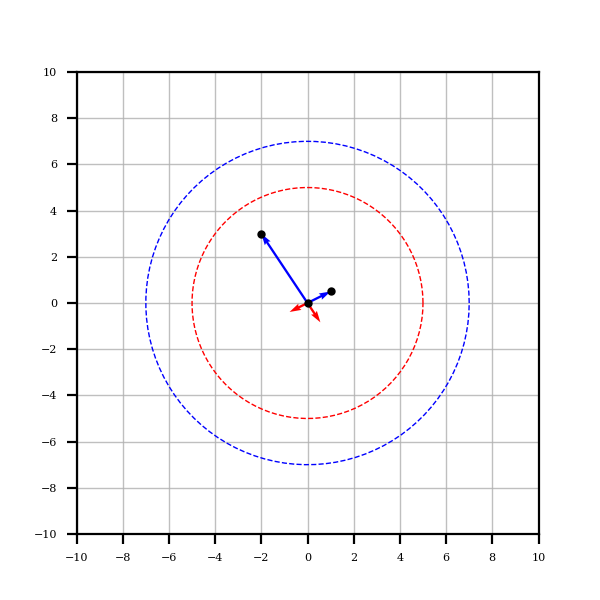

[0. 0. 0.] [0. 0. 0.] [ 0.  1. -2.] [0.  0.5 3. ]
[0. 0. 0.] [0. 0. 0.] [ 0.         -0.7763932   0.55777949] [ 0.         -0.3881966  -0.83666923]


In [16]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
coh_v_0 = np.column_stack((xv_coh.T[0], yv_coh.T[0]))   # get cohesion vectors for agent 0 - just for plotting            
plot_vector(coh_v_0, colors='blue')                    # draw the cohesion vectors from b[0] to b[1] and b[2]
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))   # get repulsion vectors for agent 0 - just for plotting 
plot_vector(rep_v_0, colors='red')                      # draw the repulsion vectors from b[0] to b[1] and b[2]

Now $b_0$ experiences cohesion and repulsion effects from *both* agents within its cohesion and repulsion fields (again, we note that it is puzzling that the 'strength' of repulsion caused by the closer agent is less that that caused by the agent that is further away). The net cohesion (resp. repulsion) effect on $b_0$ is given by the mean of the sum of the cohesion (resp. repulsion) effects arising from $b_1$ and $b_2$, as follows:

<IPython.core.display.Javascript object>


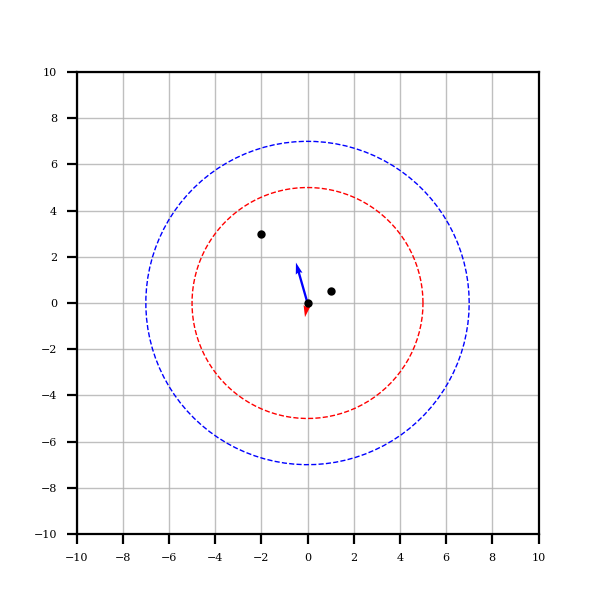

[0.] [0.] [-0.5] [1.75]
[0.] [0.] [-0.10930686] [-0.61243292]


In [17]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
plot_vector(b[COH_X:COH_Y+1].T[0,np.newaxis], colors='blue')    # draw the resultant cohesion vector for b[0]
plot_vector(b[REP_X:REP_Y+1].T[0,np.newaxis], colors='red')      # draw the resultant repulsion vectors for b[0]

Of course, agents $b_1$ and $b_2$ also experience similar effects due to the agents in their vicinity. This is shown below.

<IPython.core.display.Javascript object>


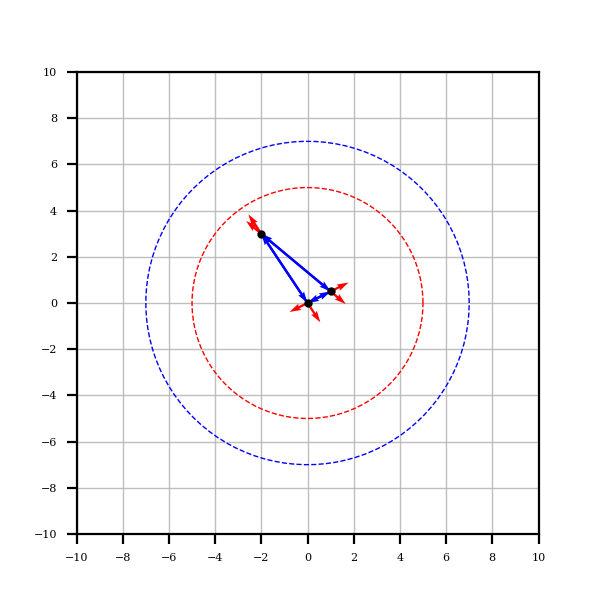

[0. 0. 0.] [0. 0. 0.] [ 0.  1. -2.] [0.  0.5 3. ]
[1. 1. 1.] [0.5 0.5 0.5] [-1.  0. -3.] [-0.5  0.   2.5]
[-2. -2. -2.] [3. 3. 3.] [2. 3. 0.] [-3.  -2.5  0. ]
[0. 0. 0.] [0. 0. 0.] [ 0.         -0.7763932   0.55777949] [ 0.         -0.3881966  -0.83666923]
[1. 1. 1.] [0.5 0.5 0.5] [0.7763932 0.        0.6569251] [ 0.3881966   0.         -0.54743758]
[-2. -2. -2.] [3. 3. 3.] [-0.55777949 -0.6569251   0.        ] [0.83666923 0.54743758 0.        ]


In [18]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
CF     = 6    # cohesion field radii
RF     = 7    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours ofeach agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
tails = b[POS_X:POS_Y+1].T                              # each agent acts as the 'tail' for its cohesion and repulsion vectors
coh_vectors = np.stack((xv_coh.T, yv_coh.T), axis=2)    # compute the targets of the cohesion vectors for each agent
for i in range(len(coh_vectors)):                       # plot the cohesion vectors for all agents
    plot_vector(coh_vectors[i], tails[i,np.newaxis], colors='blue')   # draw the cohesion vectors
rep_vectors = np.stack((xv_rep.T, yv_rep.T), axis=2)    # compute the targets of the repulsion vectors for each agent
for i in range(len(rep_vectors)):                       # plot the repulsion vectors for all agents
    plot_vector(rep_vectors[i], tails[i, np.newaxis], colors='red')   # draw the repulsion vectors


## Resultant of cohesion and repulsion vectors

The movement of each agent is influenced by the sum of its cohesion and repulsion vectors. This sum is known as the *resultant* of the cohesion and repulsion vectors. Here we add 2 additional rows (RES_X and RES_Y) to the swarm state array to store the x- and y-coordinates of the overall resultant vectors.

<IPython.core.display.Javascript object>


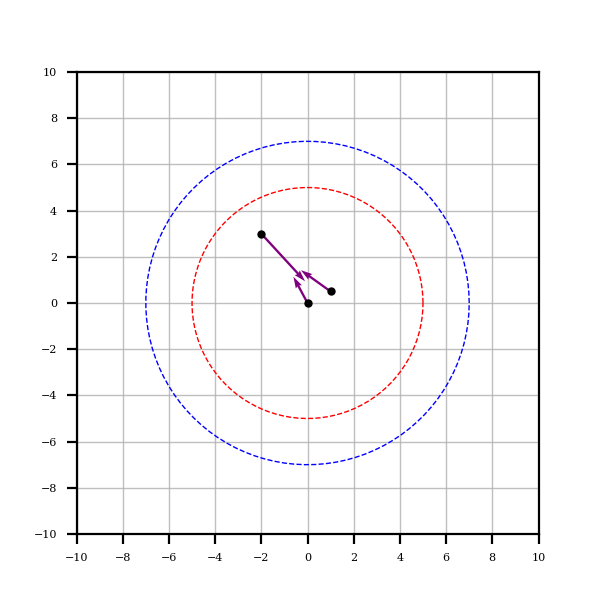

[ 0.  1. -2.] [0.  0.5 3. ] [-0.60930686 -1.28334085  1.89264771] [ 1.13756708  0.92037951 -2.05794659]


In [19]:
# Define some useful array row constants for agent attributes
POS_X  = 0    # x-coordinates of agents' position 
POS_Y  = 1    # y-coordinates of agents' position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
RES_X  = 6    # x-coordinates of resultant vectors
RES_Y  = 7    # y-coordinates of resultant vectors
CF     = 8    # cohesion field radii
RF     = 9    # repulsion field radii

b = np.array([
    [0.0, 1.0, -2.0], # x-coordinates of agents' position
    [0.0, 0.5, 3.0],  # y-coordinates of agents' position
    [0.0, 0.0, 0.0],  # x-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # y-coordinates of cohesion vector
    [0.0, 0.0, 0.0],  # x-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # y-coordinates of repulsion vector
    [0.0, 0.0, 0.0],  # x-coordinates of resultant vector
    [0.0, 0.0, 0.0],  # y-coordinates of resultant vector
    [7.0, 7.0, 7.0],  # cohesion field radii
    [5.0, 5.0, 5.0],  # repulsion field radii
])
xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours ofeach agent

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# compute the overall resultant of the cohesion and repulsion vectors
b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] 

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                             # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                             # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')     # draw the resultant vectors for all agents

## Random swarms, goals, direction vectors and weights

So far, we have considered only swarms in which all agents are within the cohesion and repulsion fields of each other. It is very unlikely that this will be the case in general. We introduce a function `mk_rand_swarm()` to create swarms in which the initial placement of agents inside or outside the cohesion or repulsion fields of other agents occurs randomly. As a convenience, we also introduce a function, `mk_swarm()`, for the easy creation of swarms of agents whose initial positions are specified by the caller.

Two further ideas are introduced:

    1. a goal position for the swarm to settle on, inducing a direction vector for each agent; 
    2. weighting factors to allow different weights to be placed on the cohesion, repulsion and direction components of the overall
       resultant vector for each agent.
       
Notice that a goal, $g$, induces a direction vector, $\vec{b g}$, for each agent $b$. As usual, the vector $\vec{b g}$ is computed as $g - b$. Now, the overall resultant vector for each agent, $b$, is computed as the weighted sum of its cohesion, repulsion and direction vectors.

In [20]:
# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position 
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor

N_ROWS = 17   # number of rows in array that models swarm state

def mk_rand_swarm(n, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0, loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents. 
    
    :param n:      number of agents
    :param cf:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
#     b[POS_X:POS_Y + 1,:] = (np.random.uniform(size=2 * n) * 2 * grid - grid + loc).reshape(2, n) # place agents randomly
    prng = np.random.default_rng(seed)
    b[POS_X:POS_Y + 1,:] = (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    return b

def mk_swarm(xs, ys, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents. 
    
    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cf:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    b[POS_X] = np.array(xs)                         # place agents as specified
    b[POS_Y] = np.array(ys)                         # place agents as specified       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    return b

Let's try creating a small random swarm and plotting the resultant vectors arising from a single step of all agents. You can play around with the parameters for `mk_rand_swarm()` here and observe the effects. Try varying the size of the fields, the weightings, the starting location and the goal.

<IPython.core.display.Javascript object>


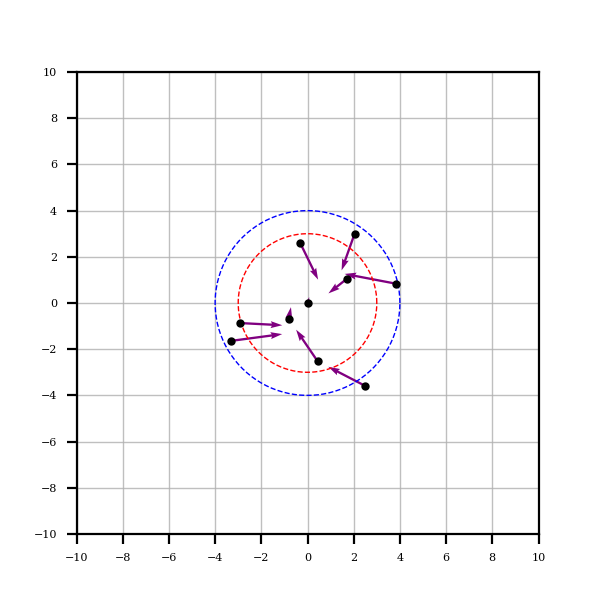

[ 0.          2.04153123 -0.31108401  1.71593397 -3.29717916 -2.91846637
 -0.81041526  3.84941287  2.50629603  0.43751466] [ 0.          3.00454214  2.58771642  1.05817747 -1.63804057 -0.86813258
 -0.67950006  0.83197756 -3.59354816 -2.52151868] [ 0.07300965 -0.56605079  0.77084048 -0.80937262  2.20033757  1.82572654
  0.09436335 -2.24074754 -1.60678366 -0.92992142] [ 0.25285597 -1.59286613 -1.57872595 -0.64331875  0.29239547 -0.09455338
  0.49882332  0.42718165  0.83262517  1.36568245]


In [21]:
# create a small, simple, random swarm
b = mk_rand_swarm(10, grid=4.0)

# set `loc` to locate the initial swarm somewhere other than the origin
# set `goal` to give the swarm a goal
# set `kf` to a value >0 to include the direction vectors in the resultant
# set `grid` to reduce the size of the initial grid
# b = mk_rand_swarm(10, loc=-7.5, goal=-5.0, kd=1.0, grid=2.0)

# Compute the resultant vectors, including direction vectors and weightings

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1     # repulsion scaling factor
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

# compute the resultant of the weighted cohesion, repulsion and direction vectors
b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]

# # normalise the resultant
# mag_res = np.hypot(b[RES_X], b[RES_Y])
# mag_res = np.where(mag_res != 0, mag_res, np.finfo('float64').eps)
# b[RES_X:RES_Y+1] /= mag_res

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)          # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')   # draw the resultant vectors for all agents

## A basic simulator

A simple swarm simulator can be developed by defining a `step()` function, along the lines that we have followed so far. The only additional requirement is to normalise the overall resultant vector for each agent and to apply a speed factor to the normalised vector to calculate the distance moved by each agent in a single unit of simulated time (a step). 

Note the normalised vector derived from $\vec{v}$ is $\hat{v}$, where $\hat{v} = \frac{\vec{v}}{\lVert\vec{v}\rVert}$, giving a vector that has the same direction as $\vec{v}$ but with magnitude $1.0$.

In [22]:
def step(b, *, speed=0.05):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step), default 0.05.
    """

    xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes

    # compute the cohesion neighbours
    coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours of each agent

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the resultant cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the repulsion neighbours
    rep_n = mag <= b[RF]               # test for those pairs of agents for which one is within the repulsion field of the other
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours of each agent

    # compute the x-differences and y-differences for repulsion vectors
    rscalar = mag / b[RF] - 1                           # repulsion scaling factor
    xv_rep = np.where(rep_n, xv * rscalar, 0.0)
    yv_rep = np.where(rep_n, yv * rscalar, 0.0)
    
    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the weighted cohesion, repulsion and direction vectors
    b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
        
    # normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, np.finfo('float64').eps)
    b[RES_X:RES_Y+1] /= mag_res


    # multiply resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= speed                            # scale normalised resultant vector by speed
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]                 # update positions of all agents
    
    return mag, coh_n, rep_n                             # useful to have these data structures available for use in other functions


Given a `step()` function, we can create a function, `run_simulation()`, to run a simulation of the `step()` function. The `run_simulation()` function is very simple. It takes a swarm as its first argument, creates a simple figure to record the positions of the swarm's agents, repeatedly runs the `step()` function, and updates the figure with the agents recorded at their new positions. The simplicity of the `run_simulation()` function derives from its use of `matplotlib.animation.FuncAnimation` which handles the periodic running of the `step()` function and the updating of the figure.

In [23]:
def run_simulation(b, *, step=step, **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                  # create a graph
    ax.set(xlim=(-10, 10), ylim=(-10, 10))                 # set the limits of the axes
    agent_data, = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)  # plot the initial locations of the agents

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        step(b, **kwargs)                                     # take a step
        agent_data.set_data(b[POS_X], b[POS_Y])               # plot the agents at their new locations
        return agent_data 

    def init():
        return []
    
    return FuncAnimation(fig, simulate, interval=100, init_func=init)   # return a function that calls `simulate` every 100 ms and updates the figure

Now we can create a variety of small- to medium-sized swarms and observe their behaviour. Importantly, however, the use of Numpy's vectorised operations provides the basis of an efficient approach to the simulation of much larger swarms. This will be explored in more detail later. For now, you should create some simple swarms, using a variety of parameters, to see how they behave.

<IPython.core.display.Javascript object>


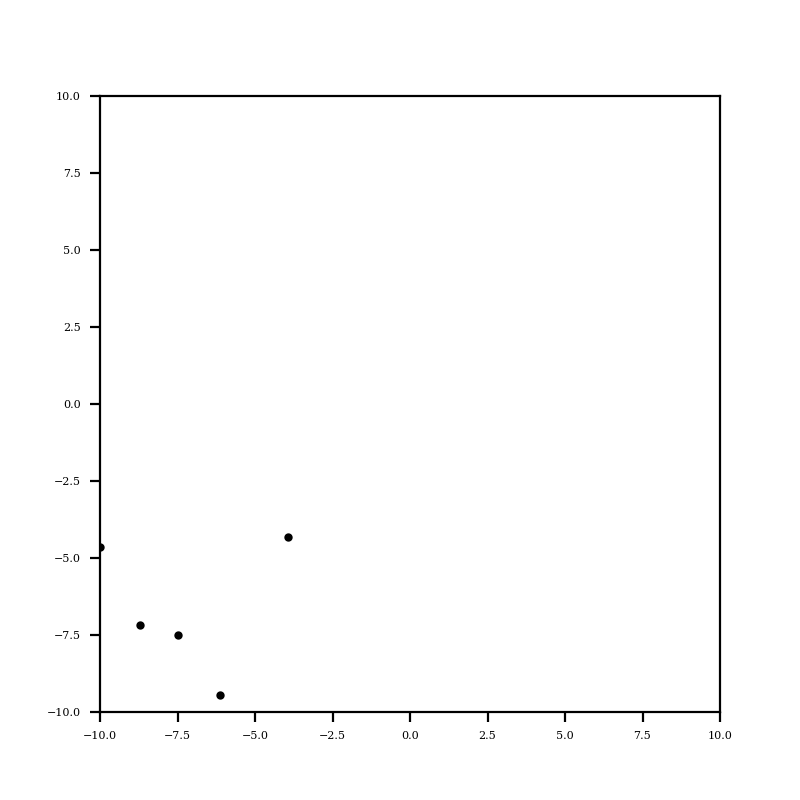

In [24]:
# create a swarm using some interesting parameters
# b = mk_rand_swarm(100, rf=4.0, cf=5.0, grid=4.0)
# b = mk_rand_swarm(100, kd=1.0, kr=4.0, loc=-7.0, grid=4.0)
# b = mk_rand_swarm(100, rf=1.0, cf=2.0, kr=15.0, grid=4.0)
# b = mk_rand_swarm(100, rf=3.0, cf=5.0, grid=10.0)
# b = mk_rand_swarm(100, rf=2.0, cf=5.0, kr=30.0, grid=6.0)
# b = mk_rand_swarm(7, loc=-7.5, kd=1.0, kr=30.0, grid=4.0)
b = mk_rand_swarm(7, loc=-7.5, kd=1.0, kr=20.0, grid=4.0, seed=12)
sim = run_simulation(b, step=step)

We can make a preliminary stab at estimating the performance of our `step` algorithm by creating a random swarm of 1000 agents and using the `%timeit` magic function to see how long it takes to execute a step in the evolution of the swarm.

In [25]:
b = mk_rand_swarm(1000)
%timeit step(b)

45.4 ms ± 696 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can obtain a more detailed understanding of the performance of the code by using the `line_profiler`. You can install this for `anaconda` using `conda install line_profiler`.

In [26]:
%load_ext line_profiler

In [27]:
b = mk_rand_swarm(2000)    # create a swarm of 2000 agents
%lprun -f step step(b)     # get a line-by-line breakdown of where the time is used

Notice that the bulk of the time (~40%) is spent in computing the pairwise distances between agents. The next most expensive operations are the computations of the x- and y-values for the repulsion vectors. There doesn't seem to be any obvious way of reducing the time taken by these operations (although the upper- or lower-triangle would suffice for the pairwise distances, it's not clear how to exploit this without losing the performance boost of vectorised operations).

## A revised repulsion scaling factor

### Background

The `step()` function is intended to implement the mathematical specification of swarm behaviour given in (Eliot, 2017). To paraphrase briefly this specification (ignoring obstacles for the moment) for a swarm, $S$, and agent, $b \in S$:

$$
v(b) = k_cv_c(b) + k_rv_r(b) + k_dv_d(b)
$$
where $k_c$, $k_r$, and $k_d$ are the weighting factors for the cohesion, repulsion and direction components of the resultant vector, respectively, and:

$$
v_c(b) = \frac{1}{\lvert n_c(b)\rvert} \sum_{b' \in n_c(b)}\vec{b b'}
$$

$$
v_r(b) = \frac{-1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(1 - \frac{\lVert\vec{b b'}\rVert}{R_b}\right)\vec{b b'}\right)
$$

$$
v_d(b) = \vec{b g}
$$

where $n_c(b)$ and $n_r(b)$ are functions returning the sets of cohesion and repulsion neighbours of $b$, as follows:

$$
n_c(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= C_b\}
$$

$$
n_r(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= R_b\}
$$

and $g$ specifies the Cartesian coordinates of a position in the 2-D space of the swarm, known as the 'goal'. The implementation of `step()` follows this specification directly in the cases of of $v_c(b)$ and $v_d(b)$. The `step()` function implements a rewritten, but equivalent, specification of $v_r(b)$ , namely:

$$
v_r(b) = \frac{1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(\frac{\lVert\vec{b b'}\rVert}{R_b} - 1\right)\vec{b b'}\right)
$$

### The problem

It is easy to explore the import of this specification for a pair of distinct agents, $b$ and $b'$, simply by focusing on the expression

$$
\left(\left(\frac{\lVert\vec{b b'}\rVert}{R_b} - 1\right)\vec{b b'}\right)
$$

Consider an agent $b_0$ at the origin with a repulsion field $R_{b_0}$ of $5.0$ and a second agent $b_1$ at $(4,3)$. The magnitude of the vector $\vec{b_0 b_1}$ is 5.0, so the magnitude of the resulting repulsion vector is $0$, as shown below:

<IPython.core.display.Javascript object>


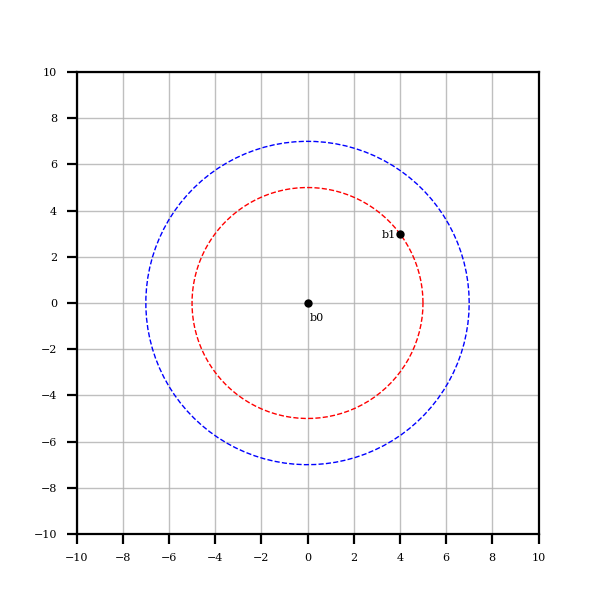

[0. 0.] [0. 0.] [0. 0.] [0. 0.]
The magnitude of the vector b0b1 is 5.0
The magnitude of the repulsion vector is 0.0


In [28]:
b = mk_swarm([0., 4.], 
             [0., 3.], cf=7.0, rf=5.0)

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences  and y-differences for repulsion vectors
rscalar = mag / b[RF] - 1
xv_rep = np.where(rep_n, xv * rscalar, 0.0)
yv_rep = np.where(rep_n, yv * rscalar, 0.0)

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]
plt.text(0.1, -0.8, 'b0')
plt.text(b[POS_X,1] - 0.8, b[POS_Y,1] - 0.2, 'b1')
print(f"The magnitude of the vector b0b1 is {mag[1, 0]}")
print(f"The magnitude of the repulsion vector is {np.hypot(xv_rep[1,0], yv_rep[1,0])}")

Now try changing the location of $b_1$ to (3, 2.25) in the code above. Run it and observe the effect. We now have a repulsion vector whose magnitude is 0.9375. Now move $b_1$ to (2, 1.5). Run and observe as before. The magnitude of the repulsion vector is now 1.25. But, from this point on, as $b_1$ moves closer to $b_0$, the magnitude of the repulsion vector grows *smaller*. Try $b_1$ at (1, 0.75). The magnitude of the repulsion vector is now back down to 0.9375. What about (0.5, 0.375)? Tha magnitude of the repulsion vector is 0.546875! In fact, the magnitude of the repulsion vector is at its maximum when the distance between $b$ and $b'$ is $\frac{R_b}{2}$ and *decreases* then, as the distance between the agents decreases. Surely, this is not how we expect the repulsion vector to behave?

### A proposed solution

An approach in which the magnitude of the repulsion vector continues to grow as an agent moves closer would seem to be preferable. There is a variety of possible ways to achieve this. A simple method is introduced here. The idea is to use the radius of the repulsion field in a linear scaling of the normalised vector between each agent pair, as follows:

$$
v_r(b) = \frac{1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\left(\lVert\vec{b b'}\rVert - R_b\right)\widehat{b b'}\right)
$$

Remember that we only consider repulsion neighbours here. So, $\lVert\vec{b b'}\rVert \leq R_b$ and, therefore, $\lVert\vec{b b'}\rVert - R_b$ is either 0 or negative, and it becomes increasingly negative as the distance between the agents becomes smaller.


<IPython.core.display.Javascript object>


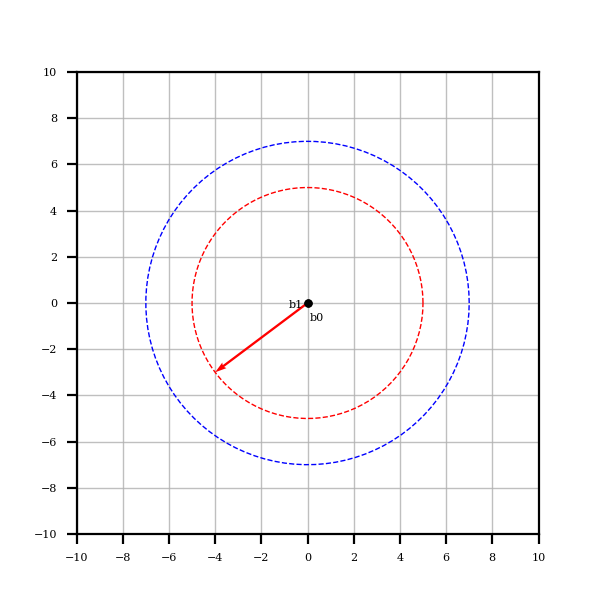

[0. 0.] [0. 0.] [ 0.      -3.99995] [ 0.        -2.9999625]
The magnitude of the vector b0b1 is 6.25e-05
The magnitude of the repulsion vector is 4.9999375
The value of rscalar is [-4.9999375 -4.9999375]


In [29]:
b = mk_swarm([0.0, 0.00005], [0.0, 0.0000375], cf=7.0, rf=5.0)

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
eps = np.finfo('float64').eps
mag_nz = np.where(mag != 0, mag, eps)                                  
rscalar = mag[rep_n] + (rep_n * -b[RF])[rep_n]              
# rscalar = 1 - ((rep_n * b[RF])[rep_n] / mag[rep_n])             
xv_rep = np.full_like(xv, 0.)
yv_rep = np.full_like(yv, 0.)
xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised x-values
yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised y-values
# xv_rep[rep_n] = xv[rep_n]  * rscalar # scale the normalised x-values
# yv_rep[rep_n] = yv[rep_n] * rscalar # scale the normalised y-values

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--')                                           # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--')                                           # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)                      # draw the agent points 
rep_v_0 = np.column_stack((xv_rep.T[0], yv_rep.T[0]))                 # get repulsion vectors for agent 0 - just for plotting            
plot_vector(rep_v_0, colors='red')                                    # draw the repulsion vector from b[0] to b[1]
plt.text(0.1, -0.8, 'b0')
plt.text(b[POS_X,1] - 0.8, b[POS_Y,1] - 0.2, 'b1')
print(f"The magnitude of the vector b0b1 is {mag[1, 0]}")
print(f"The magnitude of the repulsion vector is {np.hypot(xv_rep[1,0], yv_rep[1,0])}")
print(f"The value of rscalar is {rscalar}")

As before, try changing the location of $b_1$ to (3, 2.25), (2, 1.5), (1, 0.75), and (0.5, 0.375), and, in each case, observe the magnitude of the repulsion vector induced in $b_0$. This looks like a more sensible approach.

The program below illustrates the kind of resultant vectors generated using this new approach.

<IPython.core.display.Javascript object>


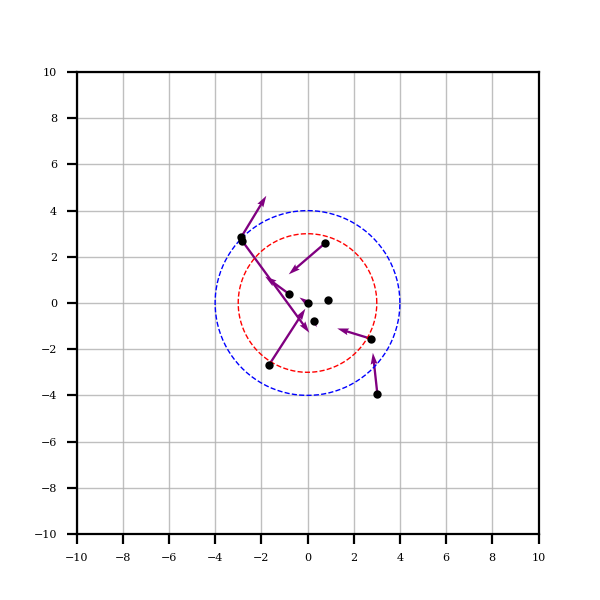

[ 0.          0.90144828 -0.81983871 -1.68126438 -2.87840569  2.7640142
  3.02358828  0.29006144 -2.83929102  0.75284707] [ 0.          0.12065298  0.40579279 -2.70477373  2.83701878 -1.5534613
 -3.93198457 -0.79920257  2.70520873  2.58291354] [-0.346106    0.12081818 -1.0128398   1.58851888  1.09529412 -1.47744777
 -0.19368319  0.10882886  2.91729237 -1.56434032] [ 0.23846973 -0.1754749   0.74086337  2.45711417  1.80518125  0.45143424
  1.77475338 -0.25246363 -3.9930058  -1.34324348]


In [30]:
# create a small, simple, random swarm
b = mk_rand_swarm(10, grid=4.0)

# set `loc` to locate the initial swarm somewhere other than the origin
# set `goal` to give the swarm a goal
# set `kf` to a value >0 to include the direction vectors in the resultant
# set `grid` to reduce the size of the initial grid
# b = mk_rand_swarm(10, loc=-7.5, goal=-5.0, kd=1.0, grid=2.0)

# Compute the resultant vectors, including direction vectors and weightings

xv = np.subtract.outer(b[POS_X], b[POS_X])  # compute all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # compute all pairs y-differences

# compute all pairwise vector magnitudes
mag = np.hypot(xv, yv)              # all pairs magnitudes

# compute the cohesion neighbours
coh_n = mag <= b[CF]               # test for those pairs of agents for which one is within the cohesion field of the other  
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

# compute the x-differences and y-differences for cohesion vectors
xv_coh = np.where(coh_n, xv, 0.0)
yv_coh = np.where(coh_n, yv, 0.0)

# compute the resultant cohesion vectors 
b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

# compute the repulsion neighbours
rep_n = mag <= b[RF]
np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

# compute the x-differences and y-differences for repulsion vectors
eps = np.finfo('float64').eps
mag_nz = np.where(mag != 0, mag, eps)                                  
rscalar = mag - b[RF]               
xv_rep = np.full_like(xv, 0.)
yv_rep = np.full_like(yv, 0.)
xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar[rep_n] # scale the normalised x-values
yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar[rep_n] # scale the normalised y-values

# compute the resultant repulsion vectors 
b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)            # divide by the number of repulsion neighbours

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

# compute the resultant of the weighted cohesion, repulsion and direction vectors
b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]

# compute the resultant magnitudes and normalise the resultant
# mag_res = np.hypot(b[RES_X], b[RES_Y])
# mag_res = np.where(mag_res != 0, mag_res, eps)
# b[RES_X:RES_Y+1] /= mag_res

# plot the results
mk_vplot()
plot_field(b[CF, 0], 'b--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the cohesion field of b[0]
plot_field(b[RF, 0], 'r--', pos=(b[POS_X,0], b[POS_Y,0])) # draw the repulsion field of b[0]
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)          # draw the agent points 
plot_vector(b[RES_X:RES_Y+1].T, b[POS_X:POS_Y+1].T, colors='purple')       # draw the resultant vectors for all agents

It is also worth experimenting with variations on this, for example, using constant, quadratic, cubic or exponential factors. Two possibilities that are worth considering are:

*Inverse square*
$$
v_r(b) = \frac{1}{\big\lvert n_r(b)\big\rvert} \sum_{b' \in n_r(b)}\left(-R_b \cdot \lVert\vec{b b'}\rVert^{-2} \cdot \widehat{b b'}\right)
$$

*Inverse exponential*
$$
v_r(b) = \frac{1}{\big\lvert n_r(b)\big\rvert} \sum_{b' \in n_r(b)}\left(-R_b \cdot e^{-\lVert\vec{b b'}\rVert} \cdot \widehat{b b'}\right)
$$

The code below implements a step function, `d_step()`, that implements all three approaches. Try plugging this into some simulations.

In [31]:
def d_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    """
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    
    # compute the cohesion neighbours
    coh_n = mag <= b[CF]
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the repulsion neighbours
    rep_n = mag <= b[RF]
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    eps = np.finfo('float64').eps
    mag_nz = np.where(mag != 0, mag, eps)                                  
    if scaling == 'linear':                             # repulsion scaling factor
        rscalar = mag[rep_n] + (rep_n * -b[RF])[rep_n]              
    elif scaling == 'quadratic':
        rscalar = (rep_n * -b[RF])[rep_n] * (mag_nz[rep_n] ** (-2))
    elif scaling == 'exponential':
        rscalar = (rep_n * -b[RF])[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    else:
        assert(False)
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the cohesion, repulsion and direction vectors
    b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
                  
    # compute the resultant magnitudes and normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, eps)
    b[RES_X:RES_Y+1] /= mag_res

    # multiply resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= speed                               # distance units per time unit
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]                    # update positions
    
    return mag, coh_n, rep_n                                # helpful later in the calculation of metrics


<IPython.core.display.Javascript object>


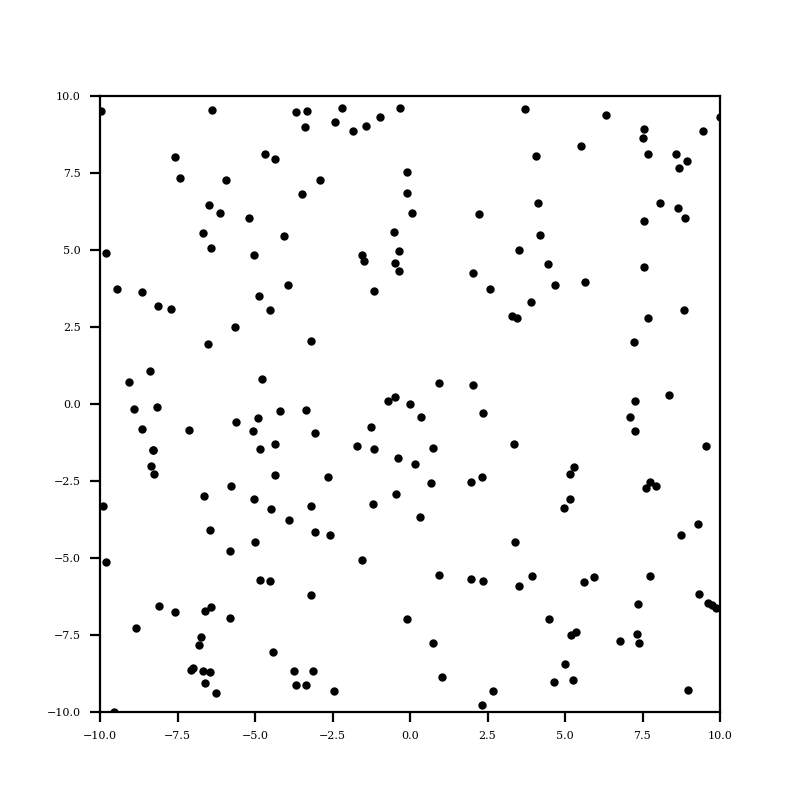

In [32]:
# create a swarm using some interesting parameters
# b = mk_rand_swarm(100, rf=4.0, cf=5.0, kr=3.0, grid=4.0)
# b = mk_rand_swarm(100, kd=1.0, kr=4.0, loc=-7.0, grid=4.0)
# b = mk_rand_swarm(100, rf=1.0, cf=2.0, kr=15.0, grid=4.0)
# b = mk_rand_swarm(100, rf=3.0, cf=5.0, kr=20.0, grid=10.0)
# b = mk_rand_swarm(100, rf=2.0, cf=5.0, kr=30.0, grid=6.0)
# b = mk_rand_swarm(7, rf=4.0, cf=5.0, loc=-7.5, kr=10.0, kd=1.0, grid=0.1)
b = mk_rand_swarm(200, rf=4.0,cf=5.0, kr=20.0, grid=10, seed=12345)
sim = run_simulation(b, step=d_step, scaling='linear')

The new `d_step()` function is about 5% to 40% slower than the previous `step()` function, depending on the approach to scaling the repulsion magnitude. This seems like a price worth paying.

In [33]:
b = mk_rand_swarm(1000)
%timeit d_step(b, scaling='quadratic')

67.1 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
b = mk_rand_swarm(2000)                             # create a swarm of 2000 agents
%lprun -f d_step d_step(b, scaling='quadratic')     # get a line-by-line breakdown of where the time is used

## Metrics

### Distance metric

#### Definition

The essential features of the distance metric for swarms, presented in (Eliot et al. 2018), can be summarised as follows:

$$
\psi_d(S) = \mu_d(S) \pm \sigma_d(S)
$$

where $\mu_d(S)$ is the mean distance over all agents $b \in S$, between $b$ and its cohesion neighbours, given by:

$$
\mu_d(S) = \frac{\sum_{b \in S} \sum_{b' \in n_c(b)}\, \lVert\vec{b b'}\rVert}{\sum_{b \in S}\,\big\lvert n_c(b)\big\rvert}
$$

and $\sigma_d(S)$ is the standard deviation from the mean:

$$
\sigma_d(S) = \sqrt{\frac{\sum_{b \in S} \sum_{b' \in n_c(b)}\, \left(\lVert\vec{b b'}\rVert - \mu_d(S)\right)^2}{\sum_{b \in S}\,\big\lvert n_c(b)\big\rvert}}
$$

#### Implementation

Let us construct a small swarm, take a simulation step, and examine the data structures available to us for implementing $\mu_d(S)$ and $\sigma_d(S)$:

In [35]:
b = mk_rand_swarm(5, grid=4.0)
mag, coh_n, _ = d_step(b)
mag, coh_n

(array([[0.        , 4.85864686, 3.06313817, 1.77998323, 3.04705838],
        [4.85864686, 0.        , 7.92178275, 4.4627025 , 6.58650478],
        [3.06313817, 7.92178275, 0.        , 4.10987191, 3.47569949],
        [1.77998323, 4.4627025 , 4.10987191, 0.        , 2.159864  ],
        [3.04705838, 6.58650478, 3.47569949, 2.159864  , 0.        ]]),
 array([[False, False,  True,  True,  True],
        [False, False, False, False, False],
        [ True, False, False, False,  True],
        [ True, False, False, False,  True],
        [ True, False,  True,  True, False]]))

We can see that `mag` represents all pairwise distances between agents and `coh_n` represents the cohesion neighbours of all agents. We can think of `coh_n` as a mask that can be applied to `mag` to obtain all, and only, those distances between cohesion neighbours. For example, `mag[coh_n]` gives

In [36]:
mag[coh_n]

array([3.06313817, 1.77998323, 3.04705838, 3.06313817, 3.47569949,
       1.77998323, 2.159864  , 3.04705838, 3.47569949, 2.159864  ])

This leads to a simple implementation of a function  for $\mu_d$ and $\sigma_d$ (note it's convenient to compute the mean and standard deviation together):

In [1]:
def mu_sigma_d(mag, coh_n):
    """
    Compute the mean and SD of the distance over all agents between an agent and its cohesion neighbours.
    
    :param mag: an array giving all pairwise distances between agents
    :param coh_n: an array giving the cohesion neighbours of all agents
    """
    mu_d = np.sum(mag[coh_n]) / np.sum(coh_n)
    sigma_d = np.sqrt(np.sum((mag[coh_n] - mu_d) ** 2) / np.sum(coh_n))
    return mu_d, sigma_d

We can use the distance metric to explore the evolution of a swarm over a number of simulation steps.

<IPython.core.display.Javascript object>


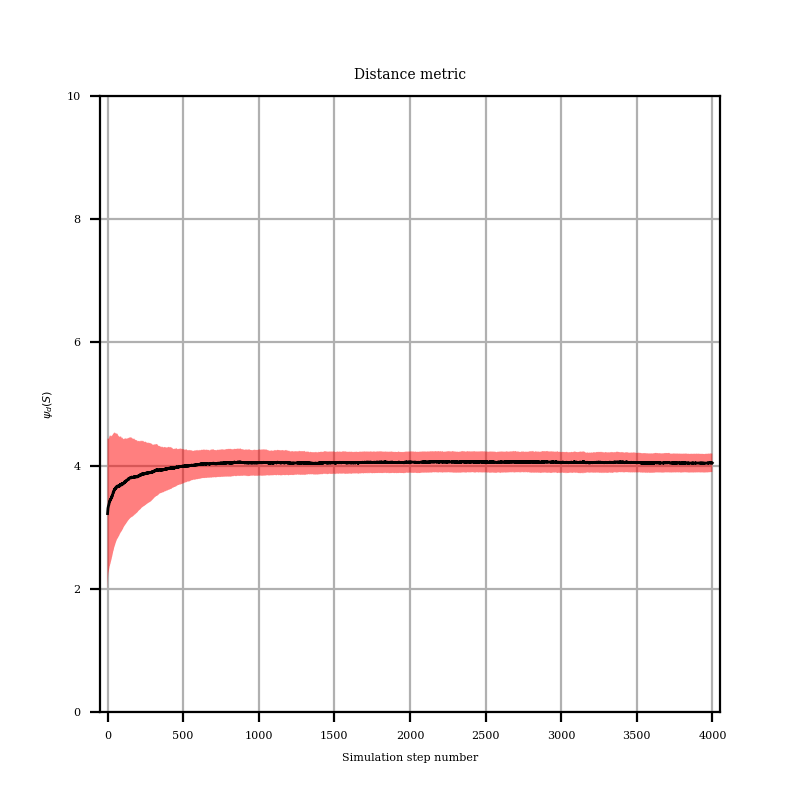

In [38]:
b = mk_rand_swarm(200, rf=4.0, cf=5.0, kr=20.0, grid=10.0, seed =12345)     # create a swarm
# b = mk_rand_swarm(5, kr=100.0, grid=4.0)
# b = mk_rand_swarm(1000, rf=7.0, cf=8.0, kr=100.0, grid=1.0)
# b = mk_rand_swarm(7, cf=7.0, rf=8.0, loc=-7.5, kr=50.0, kd=1.0, grid=4.0)
# b = mk_rand_swarm(1000, seed=12345, grid=3.0, kr=10.0)
n_steps = 4000                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    mag, coh_n, _ = d_step(b, scaling='quadratic', speed=0.2)                  # take a step
    m, s = mu_sigma_d(mag, coh_n)                                           # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(-50, n_steps+50), ylim=(0, 10))                                # set the limits of the axes
ax.set_title('Distance metric')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

It can be informative to observe a simulation of a swarm whose behaviour has been investigated using the distance metric.

<IPython.core.display.Javascript object>


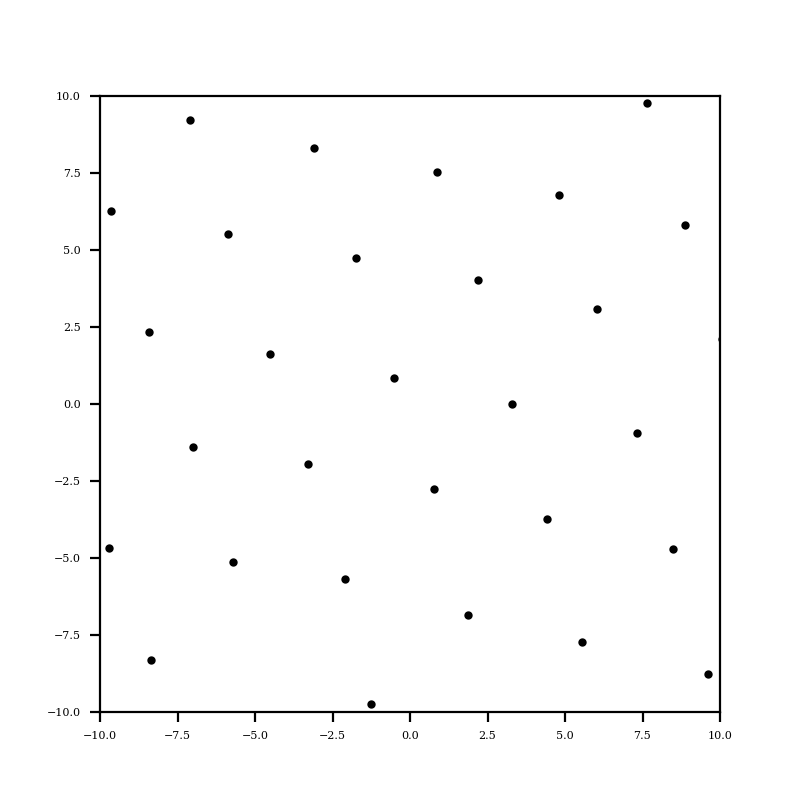

In [39]:
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=30.0, grid=20.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=30.0, grid=10.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=15.0, kd=1.0, grid=20.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=100.0, grid=10.0)
# b = mk_rand_swarm(7, cf=5.0, kr=5.0, grid=4.0)
# b = mk_rand_swarm(36, loc=-7.5, kd=1.0, kr=30.0, grid=20.0)
sim = run_simulation(b, step=d_step, scaling='quadratic', speed=0.2)

### Cohesion/Repulsion metric

#### Definition

The essential features of the cohesion/repulsion metric for swarms, adapted from (Eliot et al. 2018), can be summarised as follows:

$$
\psi_p(S) = \mu_p(S) \pm \sigma_p(S)
$$

where $\mu_p(S)$ is the mean of the adjusted magnitude values of the weighted cohesion/repulsion vectors of all agents, induced by their cohesion/repulsion neighbours. For each cohesion/repulsion vector, a positive value is derived from the magnitude of the vector if the cohesion component of the
vector dominates, but a negative value is derived if the repulsion component dominates.

We define some helper functions, $v_{cr}$ and $P$, to 
aid the specifications of $\mu_p$ and $\sigma_p$:

$$
v_{cr}(b) = k_c v_c(b) + k_r v_r(b)
$$

$$
P(b) = \left\{ \begin{array}{ll}
                \lVert v_{cr}(b) \rVert & \quad k_c v_c(b) > k_r v_r(b) \\
                -\lVert v_{cr}(b) \rVert & \quad \mathrm{otherwise}
              \end{array}
       \right.
$$

$v_{cr}(b)$ gives the weighted cohesion/repulsion vector for $b$ and $P(b)$ gives the value derived from the magnitude of this vector. Now we can define the mean and standard deviation.

$$
\mu_p(S) = \frac{\sum_{b \in S} P(b)}{D}
$$

and $\sigma_p(S)$ is the standard deviation from the mean:

$$
\sigma_p(S) = \sqrt{\frac{\sum_{b \in S}\, (P(b) - \mu_p(S))^2}{D}}
$$

We still need to consider the definition of the denominator, $D$, here. (Eliot et al. 2018) defines $D$ like this:

$$
D = \sum_{b \in S}\, \big\lvert n_c(b) \big\rvert + \big\lvert n_r(b) \big\rvert
$$

This seems to me to be over-counting agents. Remember that each agent $b \in S$ has at most one cohesion/repulsion vector as defined above. This has been scaled already by the reciprocal of the number of its cohesion and repulsion neighbours (see the definitions of $v_c(b)$ and $v_r(b)$ earlier). In calculating $\mu_p(S)$ and $\sigma_p(S)$, we should be dividing by at most $\lvert S \rvert$ but the value of $D$, as defined above, may be as big as $2(\lvert S\rvert^2 - \lvert S\rvert)$, clearly too big!. It might be argued that even $\lvert S \rvert$ may be too big, since $S$ may include agents that are isolated and not participating in the cohesion/repulsion structure of the swarm and, therefore, should not be counted. In this case, we could define $D$ as

$$
D = \bigg\lvert \bigcup_{b \in S} (n_c(b) \cup n_r(b)) \bigg\rvert
$$

I think it's reasonable to consider that the cohesion/repulsion structure is a property of the whole swarm $S$, whether or not it contains isolated agents, and, in the following, I take $D$ to be

$$
D = \lvert S \rvert
$$

#### Implementation

Once a simulation step has been executed, the array `b`, modelling the swarm, has rows `b[COH_X:COH_Y+1]` and `b[REP_X:REP_Y+1]` that contain the x- and y-values of the resultant cohesion and repulsion vector, respectively, of every agent in the swarm. Given these, it is straighforward to construct a function for $\mu_p$ and $\sigma_p$ that follows the equations above:

In [40]:
def mu_sigma_p(b):
    vcr = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1]       # the weighted cohesion/repulsion vector of every agent
    vcr_mag = np.hypot(vcr[0], vcr[1])                              # the magnitude of the weighted cohesion/repulsion vector of every agent
    vc_mag = b[KC] * np.hypot(b[COH_X], b[COH_Y])                   # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = b[KR] * np.hypot(b[REP_X], b[REP_Y])                   # the magnitude of the repulsion component of the cohesion/repulsion vector                 
    P = np.where(vc_mag > vr_mag, vcr_mag, -vcr_mag)                # the implementation of P as defined
    n_agents = b.shape[1]                                           # the total number of agents in the swarm
    mu_p = np.sum(P) / n_agents                                     # the mean 
    sigma_p = np.sqrt(np.sum((P - mu_p) ** 2) / n_agents)           # the standard deviation
    return mu_p, sigma_p

We can use the cohesion/repulsion metric to explore the evolution of a swarm over a number of simulation steps.

<IPython.core.display.Javascript object>


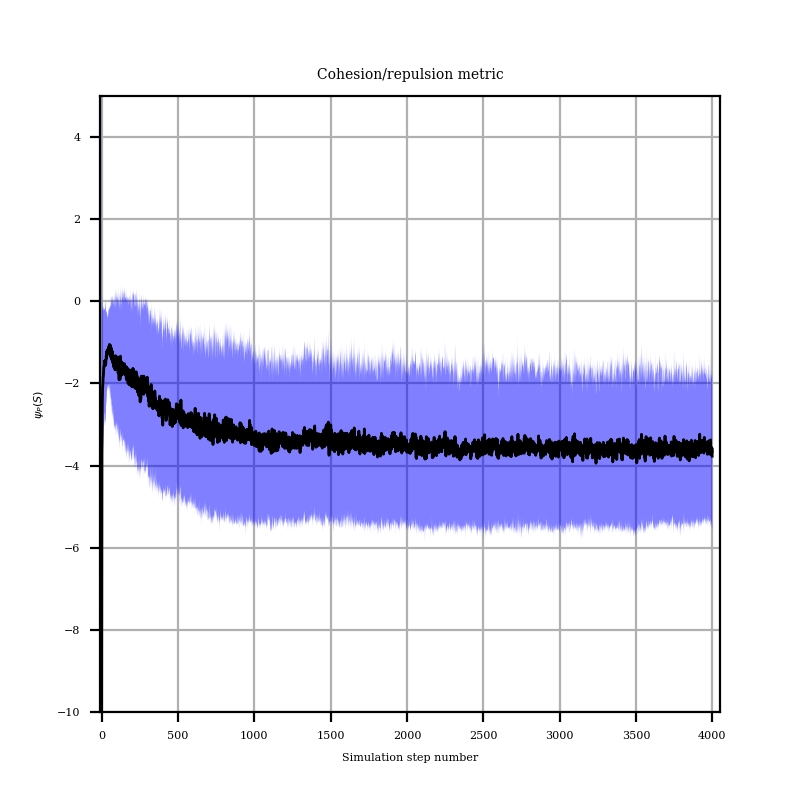

In [41]:
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=100.0, grid=200.0)                          # create a swarm
# b = mk_rand_swarm(1000, rf=2.0, cf=8.0, kr=100.0, grid=1.0)
# b = mk_rand_swarm(200, rf=7.0, cf=8.0, kr=5.0, grid=10.0)
# b = mk_rand_swarm(7, cf=7.0, rf=8.0, loc=-7.5, kr=50.0, kd=1.0, grid=4.0)
b = mk_rand_swarm(200, rf=4.0,cf=5.0, kr=20.0, grid=10, seed=12345)
n_steps = 4000                                                                          # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    d_step(b, scaling='quadratic', speed=0.2)                                           # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(-10, n_steps+50), ylim=(-10, 5))                                           # set the properties of the axes
ax.set_title('Cohesion/repulsion metric')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

We can look at a simulation of (part of) the swarm after it's stabilised. 

<IPython.core.display.Javascript object>


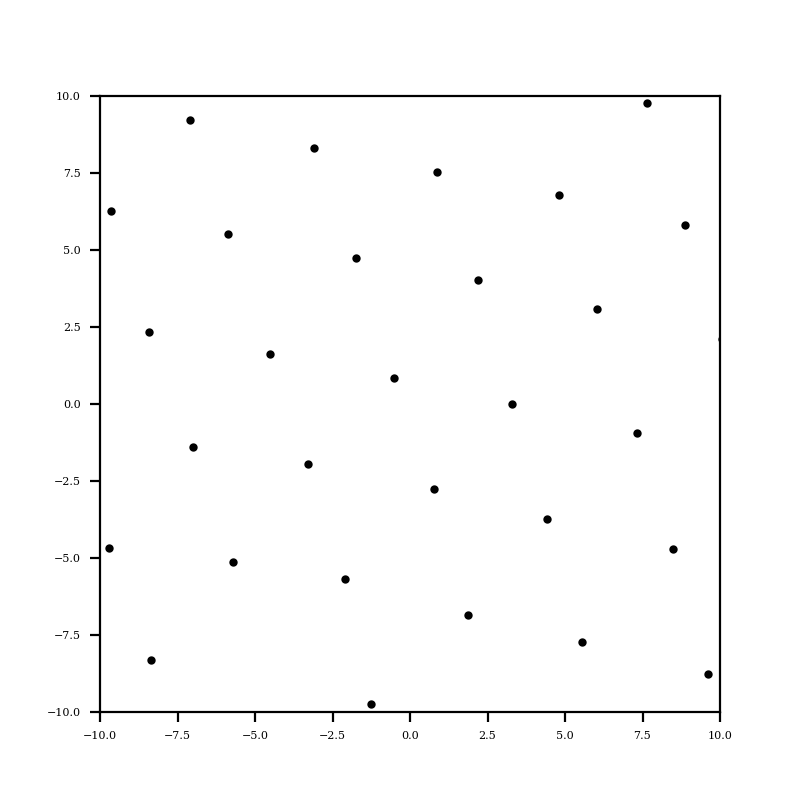

In [42]:
sim = run_simulation(b, step=d_step, scaling='quadratic', speed=0.2)

## Perimeter detection

### Introduction

The approach to perimeter detection is introduced with a simple example, shown below.

<IPython.core.display.Javascript object>


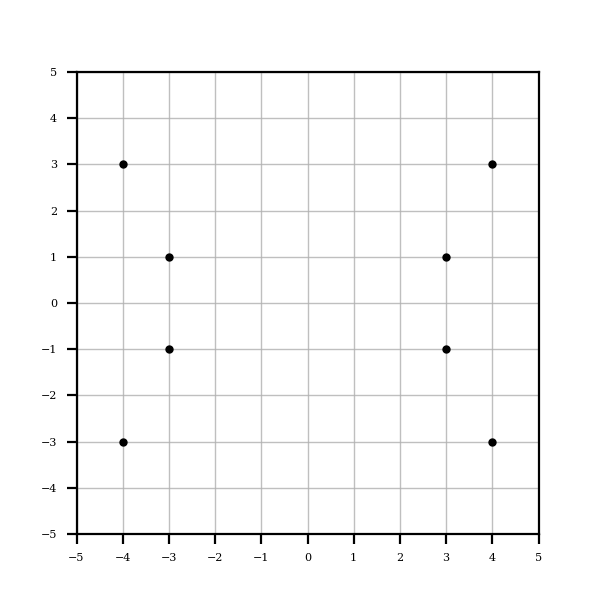

In [43]:
# Create and plot a swarm with known locations for all agents
b = mk_swarm([3., 4., -4., -3., -3., -4.,  4.,  3.],
             [1., 3.,  3.,  1., -1., -3., -3., -1.],
             cf=10.0)
mk_vplot(5, 1)
plt.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)        # draw the agent points 

Notice that the agents are given in the order in which they are encountered, as an arc is swept from the positive x-axis through all quadrants. So, `b[0]` is at `(3,1)` and `b[7]` is at `(3, -1)`.

Most of the elements of a solution to the perimeter detection problem are present already in the `step()` function, where we have the computation of: all pairwise x and y differences, all pairwise distances between agents, and cohesion neighbours of all agents, as follows:

In [44]:
xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
mag = np.hypot(xv, yv)                      # all pairs magnitudes
coh_n = mag <= b[CF]                        # cohesion neighbours
np.fill_diagonal(coh_n, False)              # no agent is a cohesion neighbour of itself

Notice that the `x` and `y` coordinates of each agent with respect to some agent `i` are given by column `i` in `xv` and `yv`, respectively. So, for example, the coordinates of all agents with respect to agent `0` (taking agent `0` as the origin) are given by `xv[:, 0]` and `yv[: 0]`, as follows:

In [45]:
xv[:,0], yv[:, 0]

(array([ 0.,  1., -7., -6., -6., -7.,  1.,  0.]),
 array([ 0.,  2.,  2.,  0., -2., -4., -4., -2.]))

Now the only additional data required are all pairwise polar angles between agents. The angle of a vector with relative coordinates $x$, $y$, is given by $tan^{-1}(\frac{y}{x})$. This can be computed using numpy for all pairwise vectors as `ang = np.arctan2(yv, xv)`. Again, notice that the polar angle of each agent with respect to some agent `i` is given by column `i` in `ang`. So, for example, the polar angles of all agents with respect to agent `0` are given by `ang[:, 0]`, as follows:

In [46]:
ang = np.arctan2(yv, xv)
ang[:, 0]

array([ 0.        ,  1.10714872,  2.86329299,  3.14159265, -2.8198421 ,
       -2.62244654, -1.32581766, -1.57079633])

The angles between agents that are *not* cohesion neighbours can be represented by a dummy value that is greater than any valid angle. Here we choose the value 10.0. In this example, the only pairs of agents that are not cohesion neighbours are the reflexive pairs:

In [47]:
ang_coh = np.where(coh_n, ang, 10.0) # polar angle for pairs of agents within coh range; ow hi value of 10
ang_coh

array([[10.        , -2.03444394, -0.27829966,  0.        ,  0.32175055,
         0.51914611,  1.81577499,  1.57079633],
       [ 1.10714872, 10.        ,  0.        ,  0.27829966,  0.51914611,
         0.64350111,  1.57079633,  1.32581766],
       [ 2.86329299,  3.14159265, 10.        ,  2.03444394,  1.81577499,
         1.57079633,  2.49809154,  2.62244654],
       [ 3.14159265, -2.86329299, -1.10714872, 10.        ,  1.57079633,
         1.32581766,  2.62244654,  2.8198421 ],
       [-2.8198421 , -2.62244654, -1.32581766, -1.57079633, 10.        ,
         1.10714872,  2.86329299,  3.14159265],
       [-2.62244654, -2.49809154, -1.57079633, -1.81577499, -2.03444394,
        10.        ,  3.14159265, -2.86329299],
       [-1.32581766, -1.57079633, -0.64350111, -0.51914611, -0.27829966,
         0.        , 10.        , -1.10714872],
       [-1.57079633, -1.81577499, -0.51914611, -0.32175055,  0.        ,
         0.27829966,  2.03444394, 10.        ]])

We can combine these elements into a function, `onPerim()`, to compute the perimeter of a swarm:

In [48]:
def onPerim2(b, xv=None, yv=None, mag=None, coh_n=None):
    """
    Determines the perimeter status of all agents in swarm b. Can make use of previous computations,
    if available, to improve overall efficiency.
    
    :param b: a data structure representing the swarm
    :param xv: all pairs differences in x-values
    :param yv: all pairs differences in y-values
    :param mag: all pairs distances between agents
    :param coh_n: all pairs cohesion neighbour status
    :returns: a numpy array of bools, one element per agent set to True if agent is on perimeter and False otherwise
    """
    if xv is None:
        xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
        yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
        mag = np.hypot(xv, yv)                      # all pairs magnitudes
        coh_n = mag <= b[CF]                        # cohesion neighbours
        np.fill_diagonal(coh_n, False)              # no agent is a cohesion neighbour of itself
    else:
        assert(not (yv is None or mag is None or coh_n is None))
        
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    ang_coh = np.where(coh_n, ang, 10.0)        # polar angle for pairs of agents within coh range; otherwise dummy value of 10

    def isAgentOnPerimeter(nba):
        """
        Determines the perimeter status of a single agent
        
        :param nba: array of neighbour angles for all cohesion neighbours of one agent
        :returns: True if perimeter condition is satisfied, otherwise False
        """
        nr = np.count_nonzero(nba<10)   # angles of coh neighbours are nba[i] for 0 <= i < nr
        if nr < 3:                     # at least 3 neighbours needed to make an agent internal ... 
            is_on_perimeter = True      # ... so perimeter condition satisfied immediately
        else:
            nbi = np.argsort(nba, axis=0).astype(int)[0:nr] # nbi indexes nba in ascending order of angle, losing dummy values
            adj = np.row_stack((nbi, np.roll(nbi,-1)))      # 2 x nr array of adjacent neighbours in which for 0 <= i < nr, adj[0, i] == nbi[i] and adj[1, i] == nbi[i + 1 % nr]

            def perimeterTest(p):           # the helper's helper
                """
                Tests if a pair of an agent's adjacent neighbours give the agent the 'perimeter-iness' property
                
                :param p: p is an array of shape (2,1) in which p[0] and p[1] are a pair of adjacent neighbours in polar angle order
                """
                if not coh_n[p[1],p[0]]:    # the adjacent pair are not cohesion neighbours of each other ...
                    result = True           # ... so the agent under consideration is on the perimeter
                else:
                    delta = nba[p[1]] - nba[p[0]]   # compute the angle between the adjacent neighbour pair
                    if delta < 0:
                        delta += np.pi * 2.0
                    result = (delta > np.pi)        # agent under consideration is on the perimeter if this is a reflex angle
                return result
            
            is_on_perimeter = np.any(np.apply_along_axis(perimeterTest, 0, adj))    # agent is on perimeter if any pair of its adjacent cohesion neighbours satisfies the perimeter test
        return is_on_perimeter

    return np.apply_along_axis(isAgentOnPerimeter, 0, ang_coh)

<IPython.core.display.Javascript object>


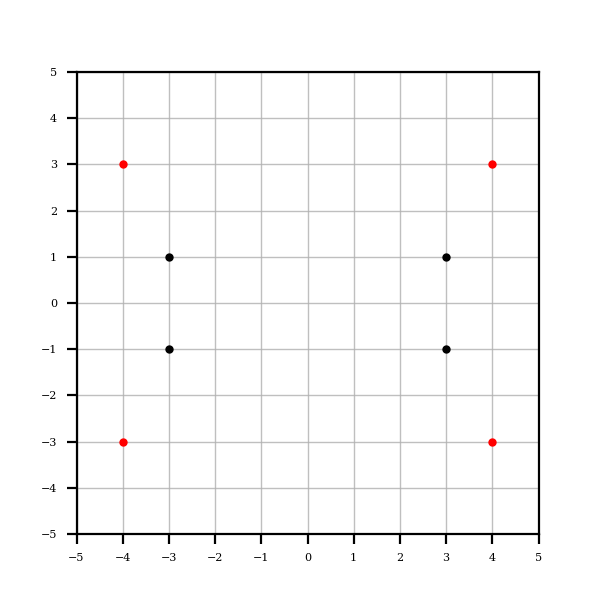

In [49]:
b = mk_swarm([3., 4., -4., -3., -3., -4.,  4.,  3.],
             [1., 3.,  3.,  1., -1., -3., -3., -1.],
             cf=10.0)
p = onPerim2(b)
fig, ax = mk_vplot(5, 1)
ax.plot(b[POS_X, p], b[POS_Y, p], 'ro', b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2)

Notice what happens when we reduce the size of the cohesion field so that the not all agents can 'see' each other.

<IPython.core.display.Javascript object>


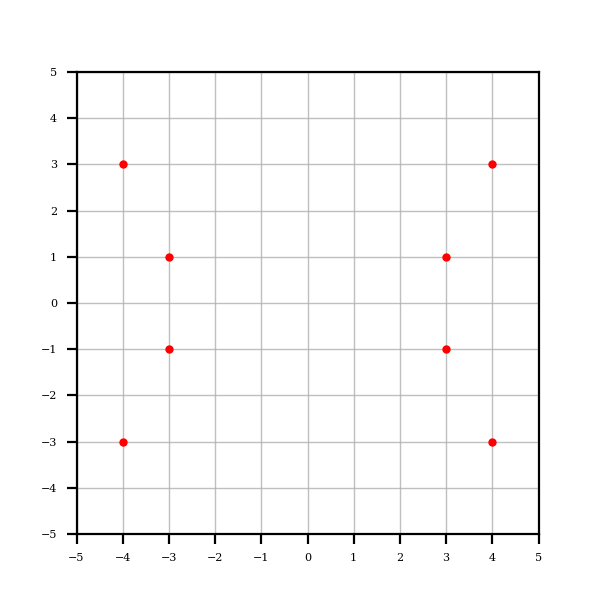

In [50]:
b = mk_swarm([3., 4., -4., -3., -3., -4.,  4.,  3.],
             [1., 3.,  3.,  1., -1., -3., -3., -1.],
             cf=7.0)
p = onPerim2(b)
fig, ax = mk_vplot(5, 1)
ax.plot(b[POS_X, p], b[POS_Y, p], 'ro', b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2)

Also notice what happens when all agents can 'see' each other but there is a reflex angle between some pairs of adjacent agents.

<IPython.core.display.Javascript object>


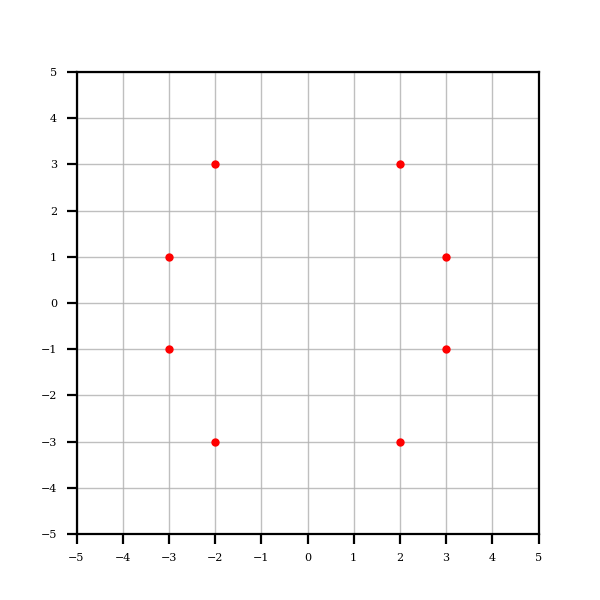

In [51]:
b = mk_swarm([3., 2., -2., -3., -3., -2.,  2.,  3.],
             [1., 3.,  3.,  1., -1., -3., -3., -1.],
             cf=10.0)
p = onPerim2(b)
fig, ax = mk_vplot(5, 1)
ax.plot(b[POS_X, p], b[POS_Y, p], 'ro', b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2)

An agent with as few as 3 neighbours may be reasonably identified as an internal (non-perimeter) agent. See the example below, where the agent at `(0, 2)` is identified as an internal agent. If an agent has fewer than 3 neighbours then it must be a perimeter agent. This is the justification for the test `if nr < 3:` in the function `isAgentOnPerimeter` above.

<IPython.core.display.Javascript object>


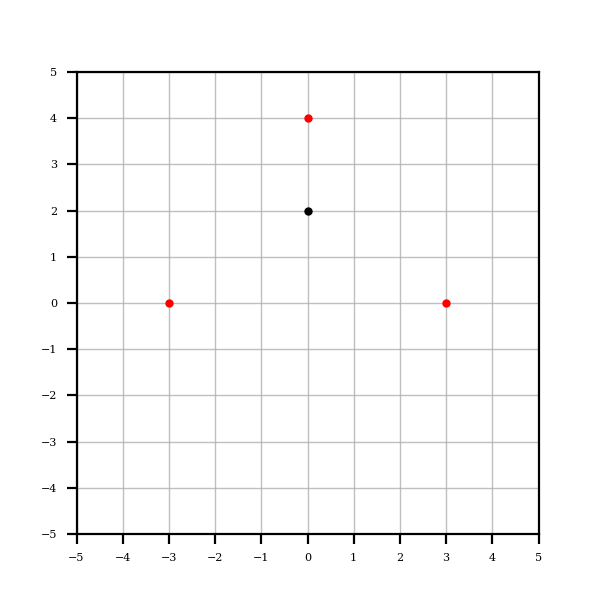

In [52]:
b = mk_swarm([0., -3., 3., 0.],
             [2., 0.,  0., 4.],
             cf=10.0)
p = onPerim2(b)
fig, ax = mk_vplot(5, 1)
ax.plot(b[POS_X, p], b[POS_Y, p], 'ro', b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2)

We can update the simulator to allow the optional display of the swarm's perimeter during simulation.

In [53]:
def run_simulation(b, *, with_perimeter=False, step=d_step, **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=(-10, 10), ylim=(-10, 10))                  # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = onPerim2(b)                                     # compute the perimeter
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

### Testing

An unscientific approach to testing for the moment is to simulate several small random swarms and observe their behaviour. I've noticed that swarms of size 10 are occasionally 'uncomfortable' for the simulator (by 'uncomfortable' I mean that the swarm may not stabilise - at least not quickly - and if it does stabilise it may settle into some kind of irregular structure). I've chosen to start testing with those swarms. We've got a daunting number of other parameters to play with when we start to develop a more systematic approach.

In [54]:
init = mk_rand_swarm(10, loc=0.0, kr=10.0, grid=3.0)

<IPython.core.display.Javascript object>


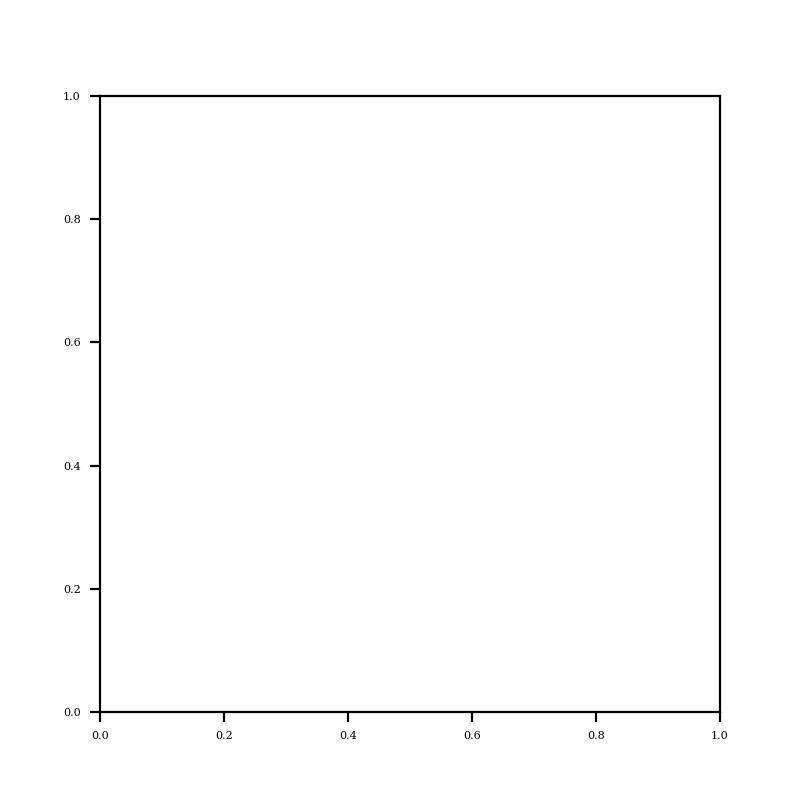

In [55]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step)

The swarm below crashed an earlier version of the `onPerim()` function but can now be handled thanks to the test `if nr == 0:` that ensures that 'apply_along_axis' is not applied to an empty axis.

In [56]:
# init = mk_rand_swarm(10, loc=0.0, kr=2.0, grid=6.0)
init = np.array([[ 0.        ,  2.80301991,  3.37028787, -5.39243265, -4.97752151,
        -1.76318139,  4.56405257, -3.9864813 ,  4.9772506 , -1.01121717],
       [ 0.        ,  3.83531594, -2.03074013, -3.64627656, -5.77539519,
         4.95263226,  0.68502993, -5.85265019, -4.69384657,  0.25057324],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
         4.        ,  4.        ,  4.        ,  4.        ,  4.        ],
       [ 3.        ,  3.        ,  3.        ,  3.        ,  3.        ,
         3.        ,  3.        ,  3.        ,  3.        ,  3.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

<IPython.core.display.Javascript object>


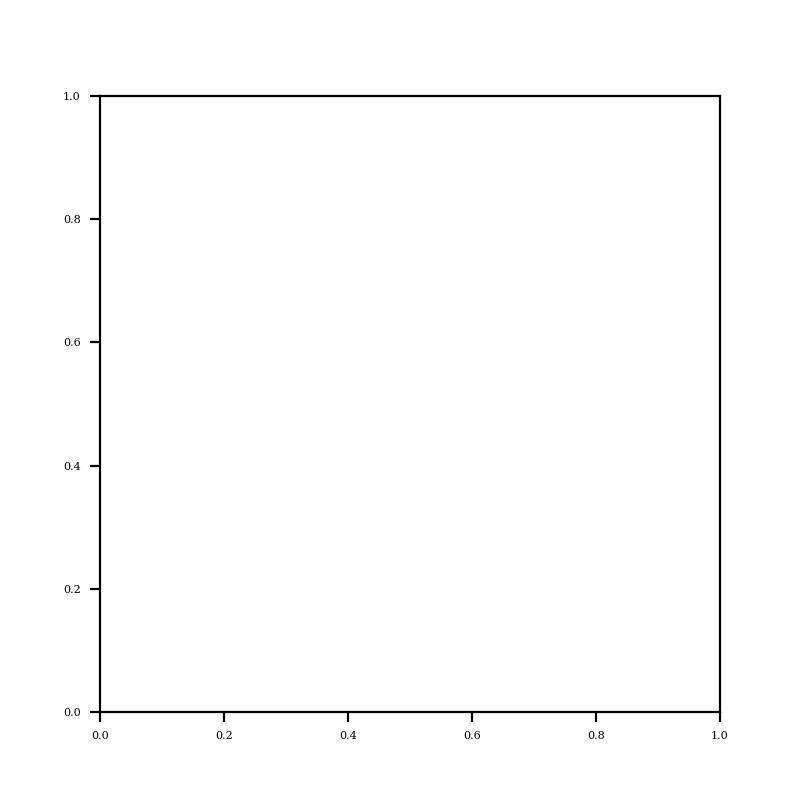

In [57]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step)

Larger swarms more often produce a structure that one can imagine being of practical use: 

In [58]:
# init = mk_rand_swarm(40, loc=0.0, kr=10.0, grid=3.0)
init = mk_rand_swarm(200, rf=4.0,cf=5.0, kr=20.0, grid=10, seed=12345)

<IPython.core.display.Javascript object>


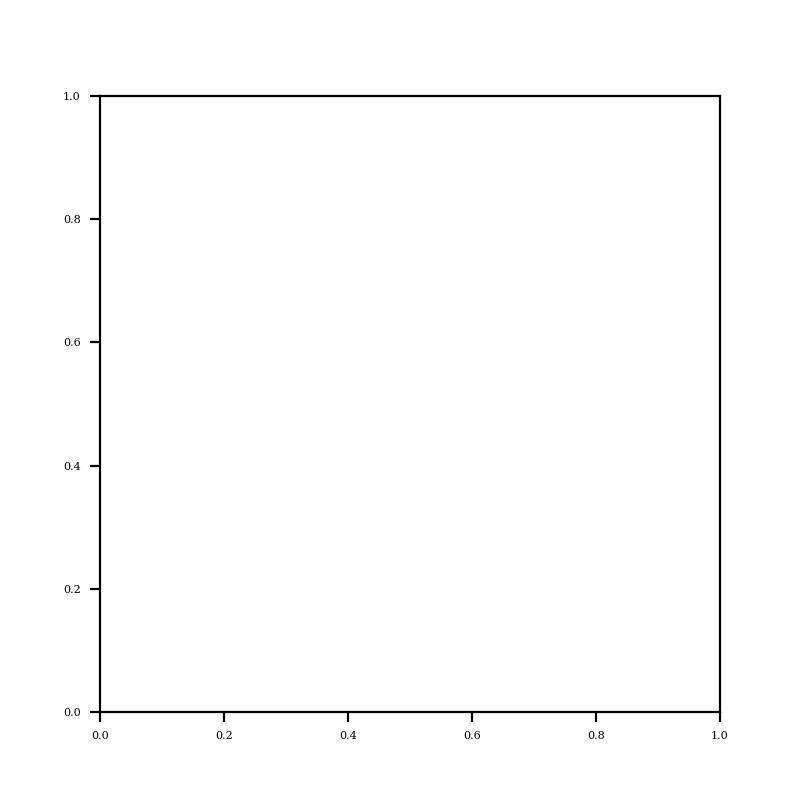

In [59]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step)

### Perimeter-directed goal seeking

A possible application of perimeter identification is to use only the perimeter agents to control the direction of a swarm towards its goal. We can add a new row, `b[PRM]`, to the swarm model to represent the perimeter status of each agent. The `d_step()` function is modified to allow the user to control perimeter-directed goal seeking and the computation of the resultant becomes:

```
    # compute the resultant of the cohesion, repulsion and direction vectors
    if perimeter_directed:
        b[PRM] = onPerim(b, xv=xv, yv=yv, mag=mag, coh_n=coh_n)
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[PRM] * b[KD] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]

```

Notice the use of `b[PRM]` here to turn on/off the directional component of the resultant vector, depending on the perimeter status of each agent.

The `mk_rand_swarm()` and `mk_swarm()` functions are modified to accommodate the `b[PRM]` row. The new function definitions appear below.

In [60]:
# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position 
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor
PRM    = 17   # if True agent known to be on perimeter of swarm

N_ROWS = 18   # number of rows in array that models swarm state

def mk_rand_swarm(n, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0, loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents. 
    
    :param n:      number of agents
    :param cf:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
#     b[POS_X:POS_Y + 1,:] = (np.random.uniform(size=2 * n) * 2 * grid - grid + loc).reshape(2, n) # place agents randomly
    prng = np.random.default_rng(seed)
    b[POS_X:POS_Y + 1,:] = (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    b[PRM,:] = np.full(n, False)                    # initially no agents known to be on perimeter
    return b

def mk_swarm(xs, ys, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents. 
    
    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cf:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    b[POS_X] = np.array(xs)                         # place agents as specified
    b[POS_Y] = np.array(ys)                         # place agents as specified       
    b[COH_X:COH_Y+1,:] = np.full((2,n), 0.0)        # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = np.full((2,n), 0.0)        # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = np.full((2,n), 0.0)        # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = np.full((2,n), 0.0)      # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = np.full((2,n), goal)   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = np.full(n, cf)                        # cohesion field of all agents set to cf
    b[RF,:] = np.full(n, rf)                        # repulsion field of all agents set to rf
    b[KC,:] = np.full(n, kc)                        # cohesion weight for all agents set to kc
    b[KR,:] = np.full(n, kr)                        # repulsion weight for all agents set to kr
    b[KD,:] = np.full(n, kd)                        # direction weight for all agents set to kd
    b[PRM,:] = np.full(n, False)                    # initially no agents known to be on perimeter
    return b

def d_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perimeter_directed=False, stability_factor=0.0):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    """
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    
    # compute the cohesion neighbours
    coh_n = mag <= b[CF]
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the repulsion neighbours
    rep_n = mag <= b[RF]
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    eps = np.finfo('float64').eps
    mag_nz = np.where(mag != 0, mag, eps)                                  
    if scaling == 'linear':                             # repulsion scaling factor
        rscalar = mag[rep_n] + (rep_n * -b[RF])[rep_n]              
    elif scaling == 'quadratic':
        rscalar = (rep_n * -b[RF])[rep_n] * (mag_nz[rep_n] ** (-2))
    elif scaling == 'exponential':
        rscalar = (rep_n * -b[RF])[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    else:
        assert(False)
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perimeter_directed:
        b[PRM] = onPerim2(b, xv=xv, yv=yv, mag=mag, coh_n=coh_n)
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[PRM] * b[KD] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
                  
    # compute the resultant magnitudes and normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, eps)
    b[RES_X:RES_Y+1] /= mag_res
        
    # multiply normalised resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= speed                       # distance units per time unit
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]            # update positions
    
    return mag, coh_n, rep_n                        # helpful in the calculation of metrics and for debugging


We can investigate the behaviour of some simple swarms with and without perimeter-directed goal seeking.

In [61]:
init = mk_rand_swarm(14, loc=-7.0, cf=2.0, rf=1.0, kr=10.0, kd=1.0, grid=3.0, goal=5.0)

<IPython.core.display.Javascript object>


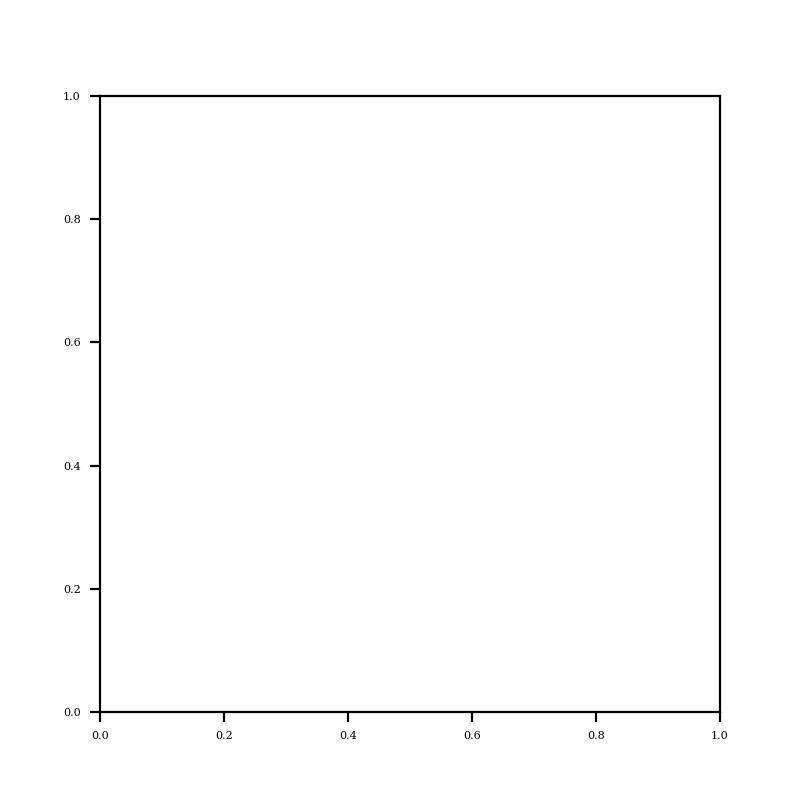

In [62]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step, perimeter_directed=True, speed=0.2)

<IPython.core.display.Javascript object>


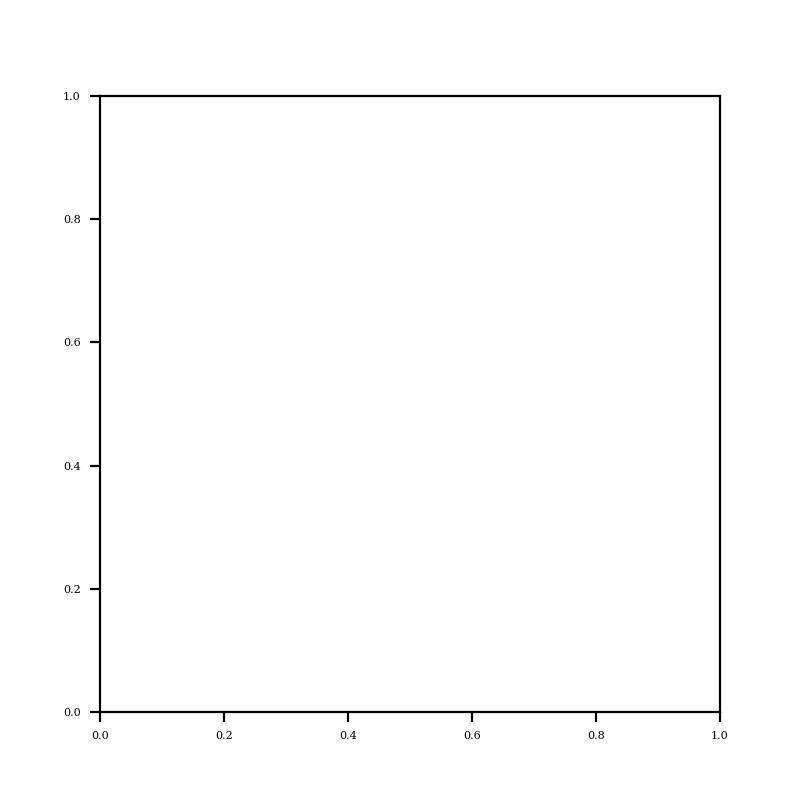

In [63]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step, perimeter_directed=False, speed=0.2)

This example suggests that perimeter-directed goal seeking leads to a less stable swarm. We can investigate this with our metrics.

<IPython.core.display.Javascript object>


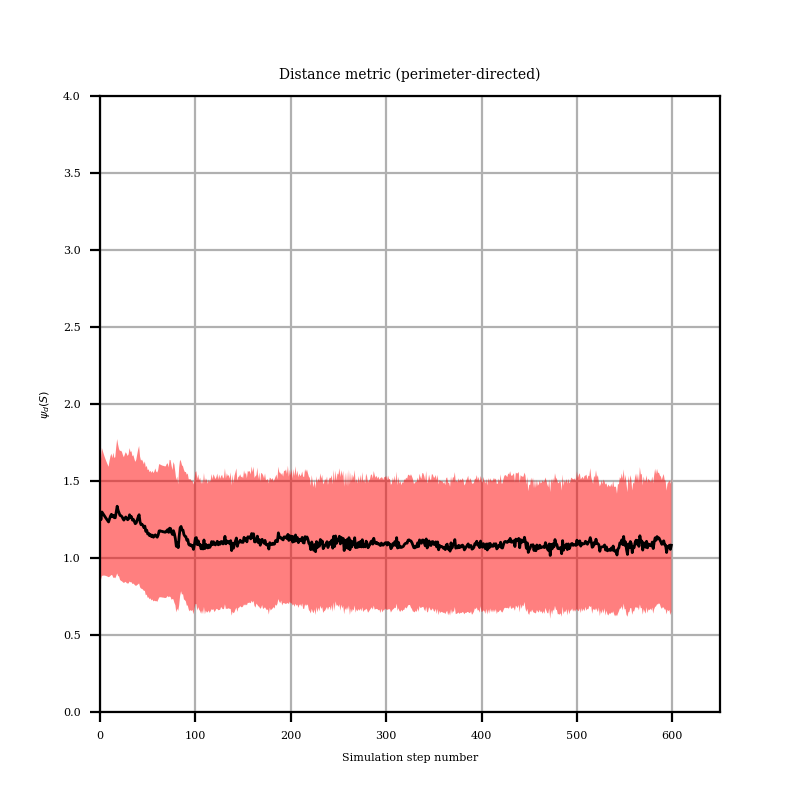

In [64]:
b = np.copy(init)
n_steps = 600                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    mag, coh_n, _ = d_step(b, speed=0.2, perimeter_directed=True)           # take a step
    m, s = mu_sigma_d(mag, coh_n)                                           # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(0, 4))                                   # set the limits of the axes
ax.set_title('Distance metric (perimeter-directed)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

<IPython.core.display.Javascript object>


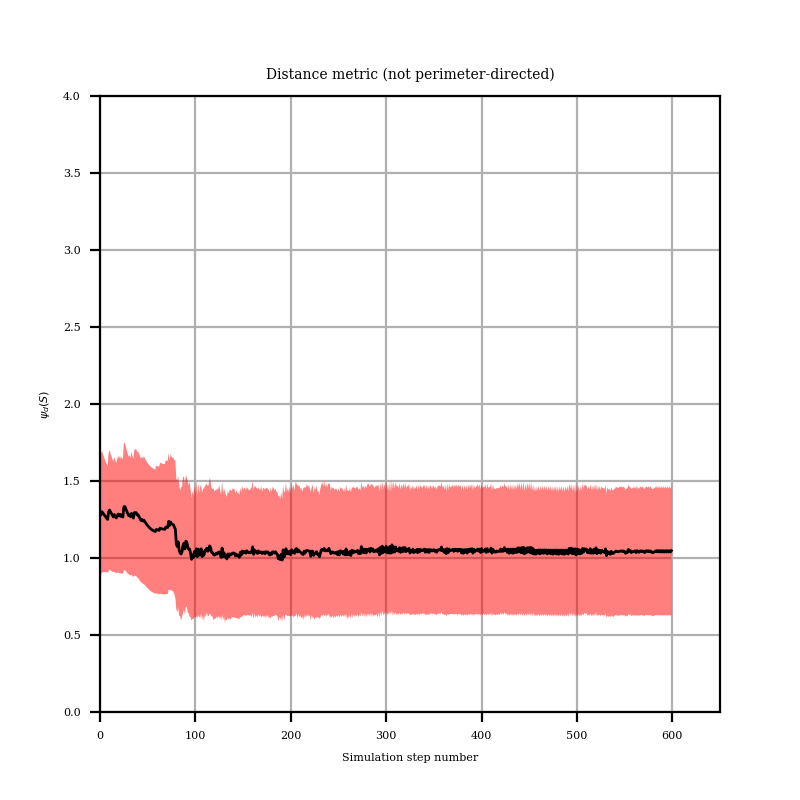

In [65]:
b = np.copy(init)
n_steps = 600                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    mag, coh_n, _ = d_step(b, speed=0.2, perimeter_directed=False)          # take a step
    m, s = mu_sigma_d(mag, coh_n)                                           # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(0, 4))                                   # set the limits of the axes
ax.set_title('Distance metric (not perimeter-directed)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

<IPython.core.display.Javascript object>


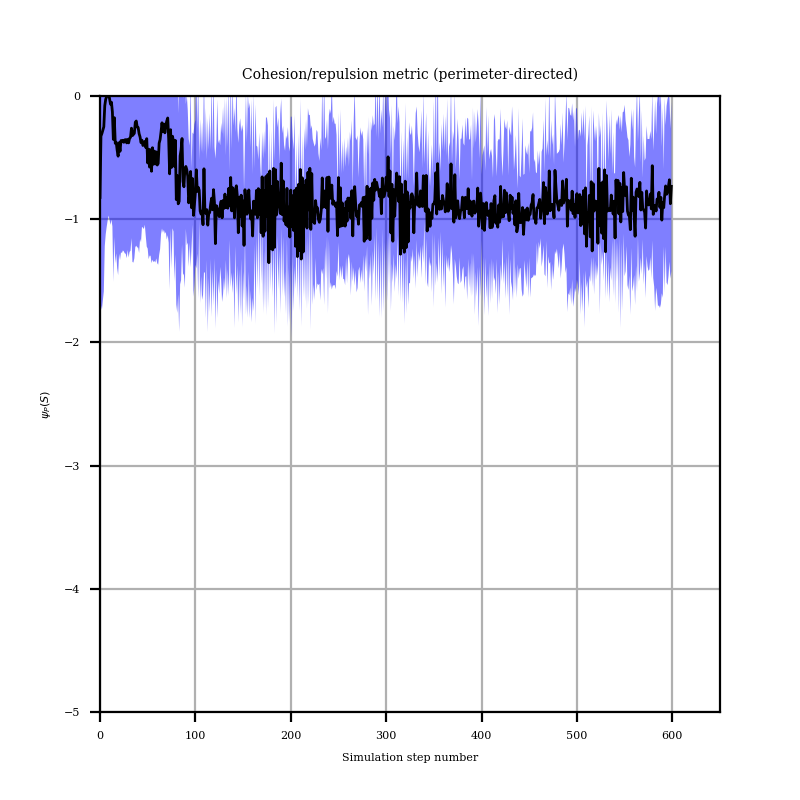

In [66]:
b = np.copy(init)
n_steps = 600                                                                           # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    d_step(b, speed=0.2, perimeter_directed=True)                                       # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(-5, 0))                                              # set the properties of the axes
ax.set_title('Cohesion/repulsion metric (perimeter-directed)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

<IPython.core.display.Javascript object>


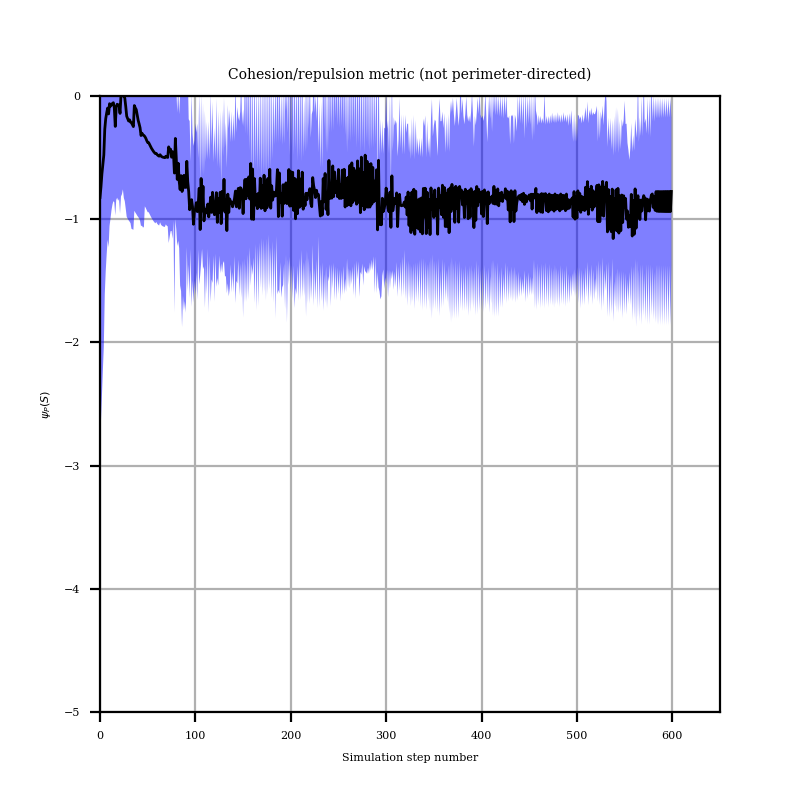

In [67]:
b = np.copy(init)
n_steps = 600                                                                           # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    d_step(b, speed=0.2, perimeter_directed=False)                                      # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(-5, 0))                                              # set the properties of the axes
ax.set_title('Cohesion/repulsion metric (not perimeter-directed)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

## Swarm stability and perimeter packing

The movement of agents in a swarm can be rather crudely classified as either 'necessary' for the swarm to achieve its objective or 'unnecessary', arising simply as a side-effect of the control algorithms. An example of unnecessary movement can be seen when a swarm has expanded to fill a space completely but the agents continue to make small movements as a result of the effects of cohesion and repulsion. The *stability* of a swarm is a measure of its unnecessary movement. When comparing the behaviour of two swarms, one is said to be more stable if it exhibits less unnecessary movement than the other. Two metrics for swarm stability are presented in (Eliot, 2018): a distance metric that measures movement explicitly, and a cohesion/repulsion metric that measures movement indirectly by measuring the cohesive and repulsive forces that control it.

A simple mechanism to improve swarm stability is implemented below. The magnitude of each agent's resultant vector (`mag`) is compared with the constant distance per step (`speed`) and those agents whose `mag < speed * stability_factor` are constrained not to move at all in this step. `stability_factor` is introduced as a new parameter to the `d_step` function. It may be worth exploring more sophisticated mechanisms but this simple approach is enough to reduce the unnecessary movement mentioned in the example above.

In *perimeter packing*, agents on the perimeter of a swarm are allowed to move closer to each other than to internal agents and closer than internal agents are allowed to move to other agents. One can imagine several applications where such behaviour might be useful. **Give an example**

Perimeter packing can be implemented by reducing the repulsion field for perimeter agents. The current approach is simply to compute an *effective repulsion field*, `erf`, between all pairs of agents. If either of a pair of agents is not on the perimeter, then their `erf` is given by their usual repulsion field, `b[RF]`, otherwise it's given by `b[RF] * perimeter_packing_factor`, where `perimeter_packing_factor` is a new parameter to `d_step` that determines by how much the repulsion field should be reduced for perimeter agents.

Mecahnisms for both swarm stability and perimeter packing are implemented in the `d_step` function below.

In [68]:
def d_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perimeter_directed=False, stability_factor=0.0, perimeter_packing_factor=1.0):
    """
    Compute one step in the evolution of swarm `b`
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param perimeter_packing_factor: determines the amount by which the repulsion field should be reduced for perimeter agents, 
                                     e.g. a perimeter_packing_factor of 0.5 causes the size of the repulsion field to be halved
    """
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences

    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    
    # compute the cohesion neighbours
    coh_n = mag <= b[CF]
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    nr_coh_n = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv, 0.0)
    yv_coh = np.where(coh_n, yv, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    b[COH_X:COH_Y+1] /= np.maximum(nr_coh_n, 1)         # divide by the number of cohesion neighbours

    # compute the perimeter if required
    if perimeter_directed or perimeter_packing_factor < 1.0:
        b[PRM] = onPerim2(b, xv=xv, yv=yv, mag=mag, coh_n=coh_n)

    # compute the effective repulsion field
    if perimeter_packing_factor < 1.0:
        perimeter_pairs = np.logical_and.outer(b[PRM], b[PRM]) # 2-D boolean matrix where element is True only if both agents on perimeter
        erf = np.outer(b[RF], np.ones(b[RF].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[RF]
        erf = np.where(perimeter_pairs, erf * perimeter_packing_factor, erf) # apply repulsion field reduction only to perimeter agent pairs
    else:
        erf = b[RF]  # no repulsion field reduction required
    
    # compute the repulsion neighbours
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    nr_rep_n = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    eps = np.finfo('float64').eps
    mag_nz = np.where(mag != 0, mag, eps)                                  
    if scaling == 'linear':                             # repulsion scaling factor
        rscalar = mag[rep_n] + (rep_n * -erf)[rep_n]              
    elif scaling == 'quadratic':
        rscalar = (rep_n * -erf)[rep_n] * (mag_nz[rep_n] ** (-2))
    elif scaling == 'exponential':
        rscalar = (rep_n * -erf)[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    else:
        assert(False)
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    b[REP_X:REP_Y+1] /= np.maximum(nr_rep_n, 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1]

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perimeter_directed:
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[PRM] * b[KD] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[KC] * b[COH_X:COH_Y+1] + b[KR] * b[REP_X:REP_Y+1] + b[KD] * b[DIR_X:DIR_Y+1]
                  
    # compute the resultant magnitudes and normalise the resultant
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, eps)
    b[RES_X:RES_Y+1] /= mag_res

    # adjust speed for swarm stability
    stability_limit = stability_factor * speed
    stable_speed = np.where(mag_res >= stability_limit, speed, 0.0)
        
    # multiply normalised resultant by factor for speed and update positions of agents
    b[RES_X:RES_Y+1] *= stable_speed                # distance units per time unit
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]            # update positions
    
    return mag, coh_n, rep_n, erf                   # helpful in the calculation of metrics and for debugging


We create a small swarm as the basis for an initial test of the stability and perimeter packing mechanisms.

In [69]:
init = mk_rand_swarm(40, loc=0.0, cf=2.5, rf=2.0, kr=10.0, grid=3.0)

The swarm is simulated with a `stability_factor` of 4.0 and and `perimeter_packing_factor` of 0.3. The swarm eventually reaches a reasonably stable state with the perimeter agents more tightly packed for the most part but with some gaps remaining around the perimeter. This phenomenon needs further investigation.

<IPython.core.display.Javascript object>


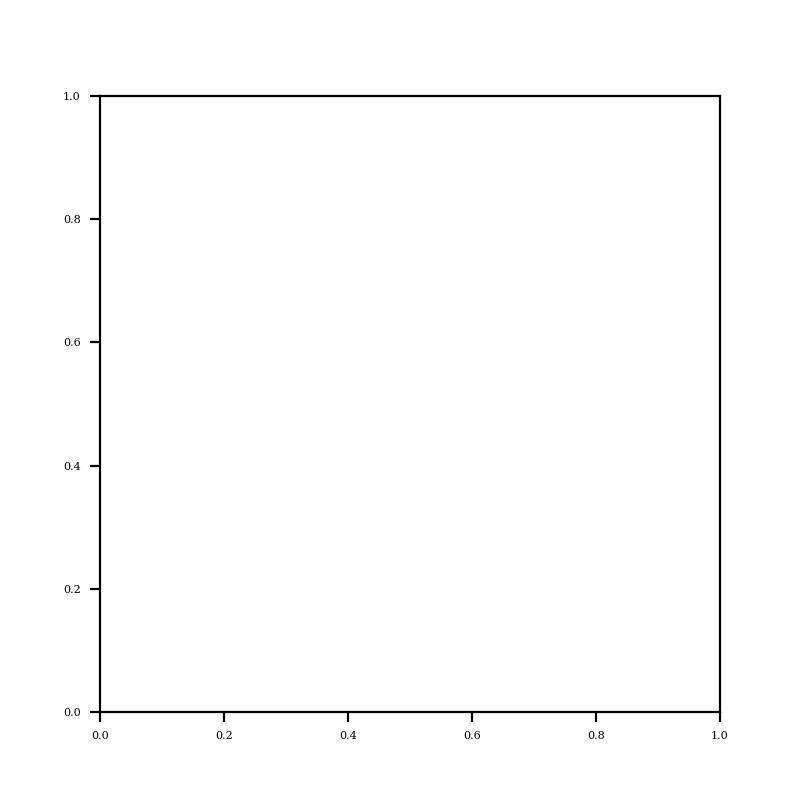

In [70]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step, perimeter_directed=False, speed=0.2, stability_factor=4.0, perimeter_packing_factor=0.3)

Both the distance and cohesion/repulsion metrics show the effectiveness of the stability mechanism.

<IPython.core.display.Javascript object>


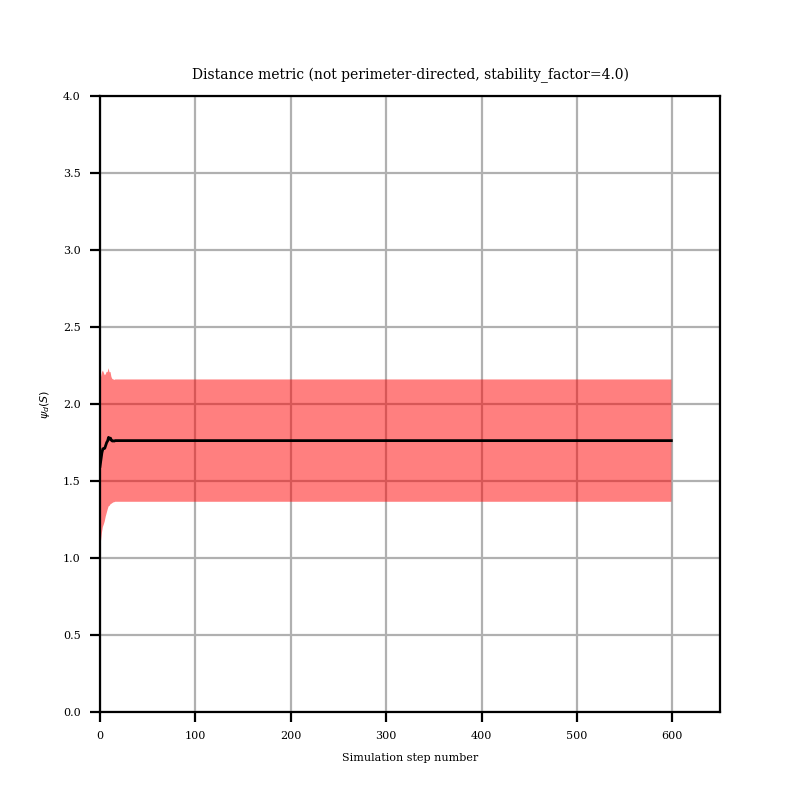

In [71]:
b = np.copy(init)
n_steps = 600                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    mag,coh_n,_,_ = d_step(b, speed=0.2, perimeter_directed=False, stability_factor=4.0)    # take a step
    m, s = mu_sigma_d(mag, coh_n)                                           # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(0, 4))                                   # set the limits of the axes
ax.set_title('Distance metric (not perimeter-directed, stability_factor=4.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

<IPython.core.display.Javascript object>


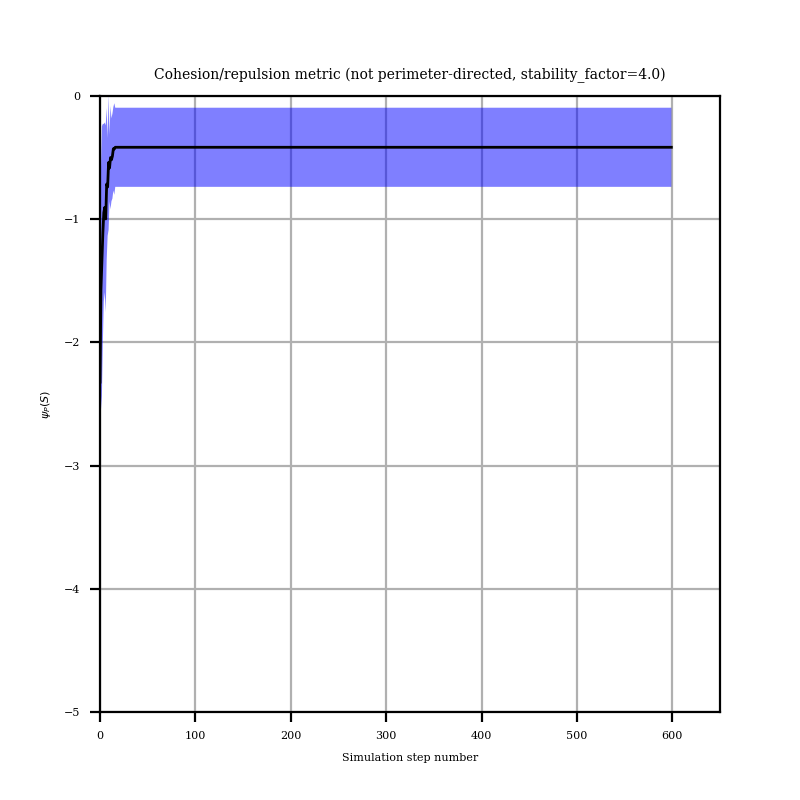

In [72]:
b = np.copy(init)
n_steps = 600                                                                           # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    d_step(b, speed=0.2, perimeter_directed=False, stability_factor=4.0)                # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(0, n_steps+50), ylim=(-5, 0))                                              # set the properties of the axes
ax.set_title('Cohesion/repulsion metric (not perimeter-directed, stability_factor=4.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

## A more efficient perimeter detection function

$$
v(b) = v_c(b) + v_r(b) + v_d(b)
$$

$$
v_c(b) = \frac{1}{\lvert n_c(b)\rvert} \sum_{b' \in n_c(b)}\mathsf{ekc}(b, b')\, \vec{b b'}
$$


$$
v_r(b) = \frac{1}{\lvert n_r(b)\rvert} \sum_{b' \in n_r(b)}\left(\mathsf{ekr}(b, b') \, \left(\lVert\vec{b b'}\rVert - \mathsf{erf}(b, b') \, \right)\widehat{b b'}\right)
$$

$$
v_d(b) = k_d \, \vec{b g}
$$

$$
\mathsf{erf}(b, b') = \mathsf{if} \; \mathsf{per}(b) \; \mathsf{and} \; \mathsf{per}(b') \; \mathsf{then} \; R_b \; \mathrm{pscale} \; \mathsf{else} \; R_b
$$

$$
\mathsf{ekr}(b, b') = \mathsf{if} \; \mathsf{per}(b) \; \mathsf{and} \; \mathsf{per}(b') \; \mathsf{then} \; k_r \; \mathrm{pscale} \; \mathsf{else} \; k_r
$$

$$
\mathsf{ekc}(b, b') = \mathsf{if} \; \mathsf{per}(b) \; \mathsf{and} \; \mathsf{per}(b') \; \mathsf{then} \; \frac{k_c}{\mathrm{pscale}} \; \mathsf{else} \; k_c
$$

$$
n_c(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= C_b\}
$$

$$
n_r(b) = \{b' \in S : b' \neq b \land \lVert\vec{b b'}\rVert <= \mathsf{erf}(b, b')\}
$$


In [261]:
def all_pairs_mag2(b):
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    return xv, yv, mag

def compute_coh2(b, xv, yv, mag, ecf, ekc):
    # compute the cohesion neighbours
    coh_n = mag <= ecf
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv * ekc, 0.0)
    yv_coh = np.where(coh_n, yv * ekc, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    
    # return the 2-D array of cohesion neighbours
    return coh_n

def onPerim2(b, xv=None, yv=None, mag=None, coh_n=None, ecf=None):
    """
    Determines the perimeter status of all agents in swarm b. Can make use of previous computations,
    if available, to improve overall efficiency.
    
    :param b: a data structure representing the swarm
    :param xv: all pairs differences in x-values
    :param yv: all pairs differences in y-values
    :param mag: all pairs distances between agents
    :param coh_n: all pairs cohesion neighbour status
    :returns: a numpy array of bools, one element per agent set to True if agent is on perimeter and False otherwise
    """
    if xv is None:
        xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
        yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
        mag = np.hypot(xv, yv)                      # all pairs magnitudes
        ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
        coh_n = mag <= ecf                          # cohesion neighbours
        np.fill_diagonal(coh_n, False)              # no agent is a cohesion neighbour of itself
    else:
        assert(not (yv is None or mag is None or coh_n is None))
        
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    ang_coh = np.where(coh_n, ang, 10.0)        # polar angle for pairs of agents within coh range; otherwise dummy value of 10

    def isAgentOnPerimeter(nba):
        """
        Determines the perimeter status of a single agent
        
        :param nba: array of neighbour angles for all cohesion neighbours of one agent
        :returns: True if perimeter condition is satisfied, otherwise False
        """
        nr = np.count_nonzero(nba<10)   # angles of coh neighbours are nba[i] for 0 <= i < nr
        if nr < 3:                     # agent has no nbrs ... 
            is_on_perimeter = True      # ... so perimeter condition satisfied immediately
        else:
            nbi = np.argsort(nba, axis=0).astype(int)[0:nr] # nbi indexes nba in ascending order of angle, losing dummy values
            adj = np.row_stack((nbi, np.roll(nbi,-1)))      # 2 x nr array of adjacent neighbours in which for 0 <= i < nr, adj[0, i] == nbi[i] and adj[1, i] == nbi[i + 1 % nr]

            def perimeterTest(p):           # the helper's helper
                """
                Tests if a pair of an agent's adjacent neighbours give the agent the 'perimeter-iness' property
                
                :param p: p is an array of shape (2,1) in which p[0] and p[1] are a pair of adjacent neighbours in polar angle order
                """
                if not coh_n[p[1],p[0]]:    # the adjacent pair are not cohesion neighbours of each other ...
                    result = True           # ... so the agent under consideration is on the perimeter
                else:
                    delta = nba[p[1]] - nba[p[0]]   # compute the angle between the adjacent neighbour pair
                    if delta < 0:
                        delta += np.pi * 2.0
                    result = (delta > np.pi)        # agent under consideration is on the perimeter if this is a reflex angle
                return result
            
            is_on_perimeter = np.any(np.apply_along_axis(perimeterTest, 0, adj))    # agent is on perimeter if any pair of its adjacent cohesion neighbours satisfies the perimeter test
        return is_on_perimeter

    return np.apply_along_axis(isAgentOnPerimeter, 0, ang_coh), ang

def compute_erf2(b, cscale, pscale):
    perimeter_pairs = np.logical_and.outer(b[PRM], b[PRM]) # 2-D boolean matrix where element is True only if both agents on perimeter
    erf = np.outer(b[RF], np.ones(b[RF].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[RF]
    erf = np.where(perimeter_pairs, erf * pscale, erf)      # apply repulsion field reduction only to perimeter agent pairs
    ekc = np.outer(b[KC], np.ones(b[KC].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[RF]
    ekc = np.where(perimeter_pairs, ekc * cscale, ekc)      # apply repulsion field reduction only to perimeter agent pairs
    ekr = np.outer(b[KR], np.ones(b[KR].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[RF]
#     ekr = np.where(perimeter_pairs, ekr * scale, ekr)      # apply repulsion field reduction only to perimeter agent pairs
    return erf, ekc, ekr

def compute_rep_linear2(b, xv, yv, mag, erf, ekr):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = mag[rep_n] + (rep_n * -erf)[rep_n]              
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences

def compute_rep_quadratic2(b, xv, yv, mag, erf, ekr):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (mag_nz[rep_n] ** (-2))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences

def compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences


def update_resultant2(b, stability_factor, speed):
    mag_res = np.hypot(b[RES_X], b[RES_Y])
    mag_res = np.where(mag_res != 0, mag_res, eps)
    b[RES_X:RES_Y+1] /= mag_res
    stability_limit = stability_factor * speed
    stable_speed = np.where(mag_res >= stability_limit, speed, 0.0)       
    b[RES_X:RES_Y+1] *= stable_speed

In [74]:
# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position 
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor
PRM    = 17   # if True agent known to be on perimeter of swarm
COH_N  = 18   # number of cohesion neighbours
REP_N  = 19   # number of repulsion neighbours

N_ROWS = 20   # number of rows in array that models swarm state
eps    = np.finfo('float64').eps # smallest positive 64 bit float value


def mk_rand_swarm(n, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0, loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents. 
    
    :param n:      number of agents
    :param cf:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    prng = np.random.default_rng(seed)
    np.copyto(b[POS_X:POS_Y + 1,:], (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n)) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]       
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = cf                                    # cohesion field of all agents set to cf
    b[RF,:] = rf                                    # repulsion field of all agents set to rf
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

def mk_swarm(xs, ys, *, cf=4.0, rf=3.0, kc=1.0, kr=1.0, kd=0.0, goal=0.0):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents. 
    
    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cf:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rf:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    np.copyto(b[POS_X], xs)                         # place agents as specified
    np.copyto(b[POS_Y], ys)                         # place agents as specified       
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = cf                                    # cohesion field of all agents set to cf
    b[RF,:] = rf                                    # repulsion field of all agents set to rf
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

In [75]:
from numba import prange
from numba import jit
            
@jit(nopython=True, fastmath=True)
def all_pairs_mag(b, xv, yv, mag, ecf):
    n_agents = b.shape[1]
    b[COH_N].fill(0.)
    for i in range(n_agents):
        for j in range(i):
            xv[i,j] = b[POS_X][i] - b[POS_X][j]
            xv[j,i] = -xv[i,j]
            yv[i,j] = b[POS_Y][i] - b[POS_Y][j]
            yv[j,i] = -yv[i,j]
            mag[i,j] = np.sqrt(xv[i,j] ** 2 + yv[i,j] ** 2)
            mag[j,i] = mag[i,j]
            if mag[j,i] <= ecf[j,i]:
                b[COH_N][i] = b[COH_N][i] + 1
                b[COH_N][j] = b[COH_N][j] + 1
        xv[i,i] = 0.0
        yv[i,i] = 0.0
        mag[i,i] = 0.0

@jit(nopython=True, fastmath=True, parallel=True)
def compute_coh(b, xv, yv, mag, ecf, ekc):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[COH_X][i] = 0.0
        b[COH_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecf[j, i]:
                b[COH_X][i] = b[COH_X][i] + (xv[j,i] * ekc[j,i])
                b[COH_Y][i] = b[COH_Y][i] + (yv[j,i] * ekc[j,i])

@jit(nopython=True, fastmath=True)
def nbr_sort(a, ang, i):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (ang[:,i][a[k]] < ang[:,i][a[jmin]]):
                jmin = k
        if jmin != j:        
            a[jmin], a[j] = a[j], a[jmin]
                
@jit(nopython=True, parallel=True, fastmath=True)
def onPerim(b, xv, yv, mag, ecf):
    n_agents = b.shape[1]
    result = np.full(n_agents, False)
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    for i in prange(n_agents):
        if b[COH_N][i] < 3:
            result[i] = True
            continue
        nbrs = np.full(int(b[COH_N][i]), 0)
        k = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecf[j, i]:
                nbrs[k] = j
                k += 1
        nbr_sort(nbrs, ang, i)
        for j in range(int(b[COH_N][i])):
            k = (j + 1) % int(b[COH_N][i])
            if mag[nbrs[k],nbrs[j]] > ecf[nbrs[k],nbrs[j]]: # nbrs[j] and nbrs[k] are not cohesion neighbours
                result[i] = True
                break
            delta = ang[:,i][nbrs[k]] - ang[:,i][nbrs[j]]
            if (delta < 0):
                delta += np.pi * 2.0;
            if (delta > np.pi) or (b[PRM][i] and delta > 2.8):
                result[i] = True;
                break;
    return result, ang  

@jit(nopython=True, fastmath=True,parallel=True)
def compute_erf(b, scale):
    n_agents = b.shape[1]
    erf = np.empty((n_agents, n_agents))
    ekc = np.empty((n_agents, n_agents))
    ekr = np.empty((n_agents, n_agents))
    for i in prange(n_agents):
        for j in range(i + 1):
            if b[PRM][i] and b[PRM][j]:
                erf[i,j] = b[RF][i] * scale
                erf[j,i] = b[RF][j] * scale
                ekc[i,j] = b[KC][i] * (1. / scale)
                ekc[j,i] = b[KC][j] * (1. / scale)
                ekr[i,j] = b[KR][i] * scale
                ekr[j,i] = b[KR][j] * scale
            else:
                erf[i,j] = b[RF][i]
                erf[j,i] = b[RF][j]
                ekc[i,j] = b[KC][i]
                ekc[j,i] = b[KC][j]
                ekr[i,j] = b[KR][i]
                ekr[j,i] = b[KR][j]
    return erf, ekc, ekr


@jit(nopython=True, fastmath=True,parallel=True)
def compute_rep_linear(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + ((mag[j,i] - erf[i,j]) * (xv[j,i] / mag[j,i]) * ekr[j,i])
                b[REP_Y][i] = b[REP_Y][i] + ((mag[j,i] - erf[i,j]) * (yv[j,i] / mag[j,i]) * ekr[j,i])

@jit(nopython=True, fastmath=True,parallel=True)
def compute_rep_quadratic(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (mag[j,i] ** -2) * (xv[j,i] / mag[j,i]) * ekr[j,i])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (mag[j,i] ** -2) * (yv[j,i] / mag[j,i]) * ekr[j,i])

@jit(nopython=True, fastmath=True, parallel=True)
def compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (xv[j,i] / mag[j,i]) * ekr[j,i])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (yv[j,i] / mag[j,i]) * ekr[j,i])

@jit(nopython=True, fastmath=True)
def update_resultant(b, stability_factor, speed):
    n_agents = b.shape[1]
    for i in range(n_agents):
        mag_res = np.sqrt(b[RES_X][i] ** 2 + b[RES_Y][i] ** 2)
        if mag_res > stability_factor * speed:
            b[RES_X][i] = b[RES_X][i] / mag_res * speed
            b[RES_Y][i] = b[RES_Y][i] / mag_res * speed
        else:
            b[RES_X][i] = 0.0
            b[RES_Y][i] = 0.0
 

In [76]:
def compute_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perimeter_directed=False, stability_factor=0.0, perimeter_packing_factor=1.0):
    """
    Compute one step in the evolution of swarm `b`
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param perimeter_packing_factor: determines the amount by which the repulsion field should be reduced for perimeter agents, 
                                     e.g. a perimeter_packing_factor of 0.5 causes the size of the repulsion field to be halved
    """
    n_agents = b.shape[1]
    ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv = np.empty((n_agents, n_agents))
    yv = np.empty((n_agents, n_agents))
    mag = np.empty((n_agents, n_agents))
    all_pairs_mag(b, xv, yv, mag, ecf)

    # compute the perimeter
    b[PRM], ang = onPerim(b, xv, yv, mag, ecf)

   # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf(b, perimeter_packing_factor)
    
    # compute the cohesion vectors 
    compute_coh(b, xv, yv, mag, ecf, ekc)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        compute_rep_quadratic(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perimeter_directed:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[PRM] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]
                  
    # normalise the resultant and update for speed, adjusted for stability    
    update_resultant(b, stability_factor, speed)

    return xv, yv, mag, ang, ecf, erf, ekc, ekr         # helpful in the calculation of metrics and for debugging

def apply_step(b):
    # update positions
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]            
    
def d_step:
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perimeter_directed=perimeter_directed, stability_factor=stability_factor, perimeter_packing_factor=perimeter_packing_factor)
    apply_step(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr


In [670]:
def compute_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):
    """
    Compute one step in the evolution of swarm `b`
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param perimeter_packing_factor: determines the amount by which the repulsion field should be reduced for perimeter agents, 
                                     e.g. a perimeter_packing_factor of 0.5 causes the size of the repulsion field to be halved
    """
    n_agents = b.shape[1]
    ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv, yv, mag = all_pairs_mag2(b)

   # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf2(b, pc, pr)
    
    # compute the cohesion vectors 
    coh_n = compute_coh2(b, xv, yv, mag, ecf, ekc)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

    # compute the perimeter
    b[PRM], ang = onPerim2(b, xv, yv, mag, coh_n)
#     b[PRM] = 0.
#     ang = np.empty((n_agents, n_agents))
    
     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        compute_rep_quadratic2(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[PRM] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]
                  
    # normalise the resultant and update for speed, adjusted for stability    
    update_resultant2(b, stability_factor, speed)

    return xv, yv, mag, ang, ecf, erf, ekc, ekr         # helpful in the calculation of metrics and for debugging

def apply_step2(b):
    # update positions
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]            

def d_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):    
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step2(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, pc=pc, pr=pr)
    apply_step2(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr

In [78]:
def run_simulation(b, *, with_perimeter=False, step=d_step, **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=(-10, 10), ylim=(-10, 10))                  # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = b[PRM].astype(bool)
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

In [79]:
init = mk_rand_swarm(7, seed=12345, grid=3., loc=-7., kr=10., kd=1., goal=5.)

<IPython.core.display.Javascript object>


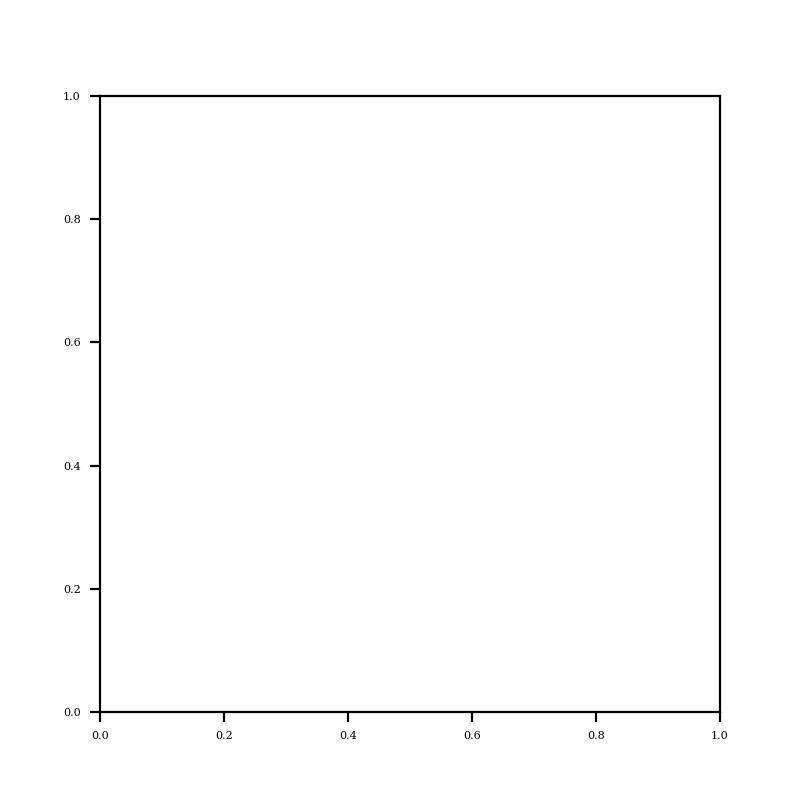

In [80]:
b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step, perimeter_directed=False, speed=0.2, stability_factor=3.6, perimeter_packing_factor=1.0)

In [81]:
# # init = mk_rand_swarm(500, rf=4.0, kr=20.0, kd=1.0, grid=10.0)
# init = mk_rand_swarm(200, rf=4.0,cf=5.0, kr=10.0, grid=4.0, seed=12345)
# # init = mk_rand_swarm(7, grid=3.0, seed=12345)
# b = np.copy(init)
# sim = run_simulation(b, with_perimeter=True, step=d_step, scaling='linear', perimeter_packing_factor=0.5, perimeter_directed=False, exp_rate=0.75, speed=0.2, stability_factor=0.0)

In [82]:
# create a random swarm to test the performance of the numba approach
# init = mk_rand_swarm(1000, seed=12345, grid=3.0, kr=10.0)
init = mk_rand_swarm(1000, seed=12345, grid=3.0, kr=10.0)

In [83]:
# let the swarm evolve a bit - timings on initial swarm are often surprisingly small
for i in range(50):
    d_step(init, speed=0.2)

In [84]:
b = np.copy(init)

In [85]:
n_agents = b.shape[1]
ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
xv1 = np.empty((n_agents, n_agents))
yv1 = np.empty((n_agents, n_agents))
mag1 = np.empty((n_agents, n_agents))
%timeit all_pairs_mag(b, xv1, yv1, mag1, ecf)

5.09 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
nr_coh_n1 = np.copy(b[COH_N])
b = np.copy(init)
%timeit all_pairs_mag2(b)

19 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
b = np.copy(init)
xv2, yv2, mag2 = all_pairs_mag2(b)
# np.count_nonzero(np.abs(mag1 - mag2) <= 100 * np.finfo('float64').eps)
np.count_nonzero(np.abs(mag1 - mag2) <= 10000000000000.0 ** -1)

1000000

In [88]:
erf1, ekc1, ekr1 = compute_erf(b, 0.3)
erf2, ekc2, ekr2 = compute_erf2(b, 0.3)
np.count_nonzero(np.abs(erf1 - erf2) <= 10000000000000.0 ** -1)

1000000

In [89]:
%timeit compute_erf(b, 0.3)

2.96 ms ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
%timeit compute_erf2(b, 0.3)

11 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
b = np.copy(init)
compute_coh2(b, xv2, yv2, mag2, ecf, ekc2)
nr_coh_n2 = np.copy(b[COH_N])
np.count_nonzero(nr_coh_n1 == nr_coh_n2)

1000

In [92]:
%timeit compute_coh(b, xv1, yv1, mag1, ecf, ekc1)

1.95 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
%timeit compute_coh2(b, xv2, yv2, mag2, ecf, ekc2)

8.46 ms ± 41.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
compute_coh(b, xv1, yv1, mag1, ecf, ekc1)
cx1 = np.copy(b[COH_X])
cy1 = np.copy(b[COH_Y])
compute_coh2(b, xv2, yv2, mag2, ecf, ekc2)
cx2 = np.copy(b[COH_X])
cy2 = np.copy(b[COH_Y])
np.count_nonzero(np.abs(cx1 - cx2) <= 10000000000000.0 ** -1)

1000

In [95]:
np.count_nonzero(np.abs(cy1 - cy2) <= 10000000000000.0 ** -1)

1000

In [96]:
%timeit onPerim(b, xv1, yv1, mag1, ecf)

7.14 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [97]:
%timeit onPerim2(b)

400 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
p1, _ = onPerim(b, xv1, yv1, mag1, ecf)
p2, _ = onPerim2(b)
np.count_nonzero(p1 == p2)

998

In [99]:
compute_rep_linear(b, xv1, yv1, mag1, erf1, ekr1)
rx1 = np.copy(b[REP_X])
ry1 = np.copy(b[REP_Y])
rn1 = np.copy(b[REP_N])
compute_rep_linear2(b, xv2, yv2, mag2, erf2, ekr2)
rx2 = np.copy(b[REP_X])
ry2 = np.copy(b[REP_Y])
rn2 = np.copy(b[REP_N])

In [100]:
np.count_nonzero(np.abs(rx1 - rx2) <= 100000000000.0 ** -1)

1000

In [101]:
np.count_nonzero(np.abs(ry1 - ry2) <= 100000000000.0 ** -1)

1000

In [102]:
np.count_nonzero(rn1 == rn2)

1000

In [103]:
px1 = np.copy(b[RES_X])
py1 = np.copy(b[RES_Y])
update_resultant(b, 4.0, 0.2)
sx1 = np.copy(b[RES_X])
sy1 = np.copy(b[RES_Y])
b[RES_X] = np.copy(px1)
b[RES_Y] = np.copy(py1)
update_resultant2(b, 4.0, 0.2)
sx2 = np.copy(b[RES_X])
sy2 = np.copy(b[RES_Y])
np.count_nonzero(np.abs(sx1 - sx2) <= 10000000000000.0 ** -1)

1000

In [104]:
np.count_nonzero(np.abs(sy1 - sy2) <= 10000000000000.0 ** -1)

1000

In [105]:
b[RES_X] = np.copy(px1)
b[RES_Y] = np.copy(py1)
%timeit update_resultant(b, 4.0, 0.2)

1.53 µs ± 19 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [106]:
b[RES_X] = np.copy(px1)
b[RES_Y] = np.copy(py1)
%timeit update_resultant2(b, 4.0, 0.2)

24.2 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [107]:
b = np.copy(init)
%timeit d_step(b, speed=0.2)

15.8 ms ± 919 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [108]:
# %timeit d_step(b, speed=0.2, perimeter_directed=False, stability_factor=4.0, perimeter_packing_factor=0.3)
b = np.copy(init)
%timeit d_step(b, speed=0.2, perimeter_packing_factor=0.3)

14.1 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
%lprun -f d_step d_step(b, speed=0.2, perimeter_directed=False, stability_factor=4.0, perimeter_packing_factor=0.3) # get a line-by-line breakdown of where the time is used

In [110]:
@jit(nopython=True, fastmath=True, parallel=True)
def mu_sigma_d2(mag, ecf):
    n_agents = mag.shape[0]
    msum = 0.
    nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= ecf[j, i]:
                msum += mag[j, i]
                nsum += 1
            if mag[i, j] <= ecf[i, j]:
                msum += mag[i, j]
                nsum += 1
    mu_d = msum / nsum
    vsum = 0.
    for i in range(n_agents):
        for j in range(i):
            if mag[j, i] <= ecf[j, i]:
                vsum += ((mag[j, i] - mu_d) * (mag[j, i] - mu_d))
            if mag[i, j] <= ecf[i, j]:
                vsum += ((mag[i, j] - mu_d) * (mag[i, j] - mu_d))
    sigma_d = np.sqrt(vsum / nsum)
    return mu_d, sigma_d

In [111]:
def mu_sigma_d4(mag, ecf):
    """
    Compute the mean and SD of the distance over all agents between an agent and its cohesion neighbours.
    
    :param mag: an array giving all pairwise distances between agents
    :param coh_n: an array giving the cohesion neighbours of all agents
    """
    coh_n = mag <= ecf
    np.fill_diagonal(coh_n, False)                                        # no agent is a cohesion neighbour of itself   
    mu_d = np.sum(mag[coh_n]) / np.sum(coh_n)
    sigma_d = np.sqrt(np.sum((mag[coh_n] - mu_d) ** 2) / np.sum(coh_n))
    return mu_d, sigma_d

In [112]:
def mu_sigma_d3(mag, ecf):
    """
    Compute the mean and SD of the distance over all agents between an agent and its cohesion neighbours.
    
    :param mag: an array giving all pairwise distances between agents
    :param coh_n: an array giving the cohesion neighbours of all agents
    """
    coh_n = mag <= ecf
    np.fill_diagonal(coh_n, False)                                        # no agent is a cohesion neighbour of itself 
    data = mag[coh_n]
    tot = np.sum(data)
    totSqs= np.sum(data ** 2)
    cnt = len(data)
    mean = tot/cnt
    var =  totSqs/cnt - mean**2
    sd = np.sqrt(var)
    return mean, sd, var

In [113]:
@jit(nopython=True, fastmath=True, parallel=True)
def mu_sigma_d(mag, ecf):
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= ecf[j, i]:
                msum += mag[j, i]
                msum_sq += mag[j, i] **2
                nsum += 1
            if mag[i, j] <= ecf[i, j]:
                msum += mag[i, j]
                msum_sq += mag[i, j] **2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2 
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

In [114]:
# This approach is intended to overcome the possible cancellation that might occur
# in calculating variance when the sum of the squares of the data values is large and
# the variance is (relatively) small
#
# The performance is significantly worse than mu_sigma_d by a factor of roughly 5
# and for our application mu_sigma_d seems to be ok so it may not be worth the effort to improve 
# the performance of mu_sigma_d5
@jit(nopython=True, fastmath=True, parallel=True)
def mu_sigma(data):
    dsum = 0.; dsum_sq = 0.; nsum = 0; K = data[0]
    for i in prange(len(data)):
        nsum += 1
        dsum += data[i] - K
        dsum_sq += (data[i] - K) * (data[i] - K)
    mu_d = K + dsum / nsum
    var_d = (dsum_sq - (dsum * dsum) / nsum) / nsum
    return mu_d, np.sqrt(var_d)

def mu_sigma_d5(mag, ecf):
    coh_n = mag <= ecf
    np.fill_diagonal(coh_n, False)
    data = mag[coh_n]
    return mu_sigma(data)

In [115]:
# init = mk_rand_swarm(1000, seed=12345, grid=10.0, kr=10.0)
# init = mk_rand_swarm(14, loc=-7.0, cf=2.0, rf=1.0, kr=10.0, kd=1.0, grid=3.0, goal=5.0)
init = mk_rand_swarm(1000, rf=4.0, cf=5.0, kr=20.0, grid=10.0, seed =12345)

In [116]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)    # take a step
%timeit mu_sigma_d(mag, ecf)

1.06 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)    # take a step
%timeit mu_sigma_d2(mag, ecf)

2.72 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)    # take a step
%timeit mu_sigma_d3(mag, ecf)

4.06 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)    # take a step
%timeit mu_sigma_d4(mag, ecf)

8.54 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)    # take a step
%timeit mu_sigma_d5(mag, ecf)

3.96 ms ± 71.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
b = np.copy(init)
xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, speed=0.2, scaling='quadratic', perimeter_directed=False, stability_factor=0.0)

In [122]:
mu_sigma_d(mag, ecf)

(3.2262731375334788, 1.2012747873915914)

In [123]:
mu_sigma_d2(mag, ecf)

(3.226273137533479, 1.2012747873915663)

In [124]:
mu_sigma_d3(mag, ecf)

(3.2262731375334868, 1.201274787391559, 1.443061114822635)

In [125]:
mu_sigma_d4(mag, ecf)

(3.2262731375334868, 1.2012747873915592)

In [126]:
mu_sigma_d5(mag, ecf)

(3.2262731375334868, 1.2012747873915592)

In [127]:
init = mk_rand_swarm(200, rf=4.0, cf=5.0, kr=20.0, grid=10.0, seed =12345)

<IPython.core.display.Javascript object>


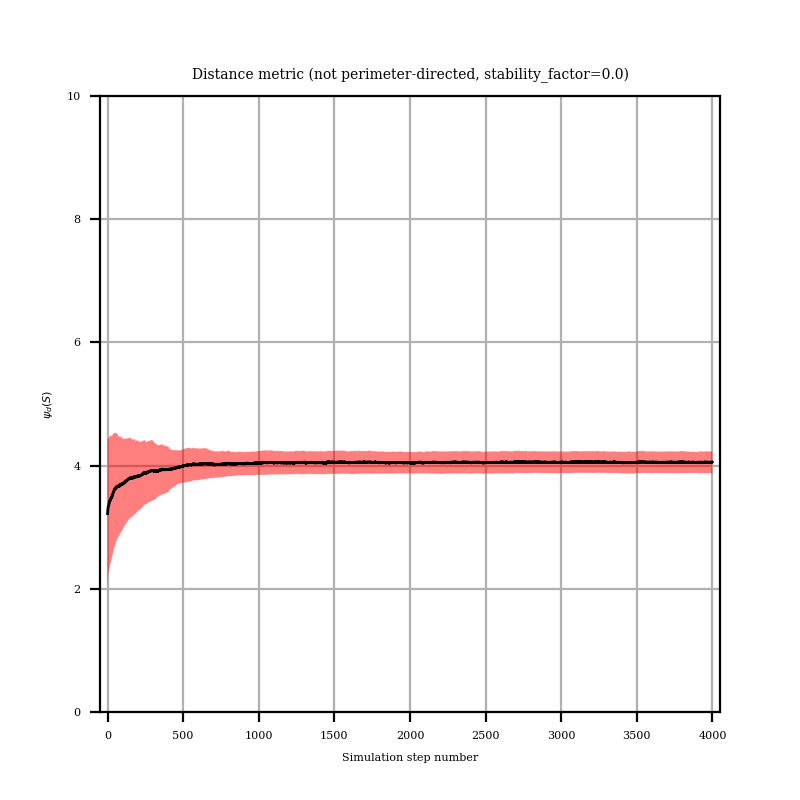

In [128]:
b = np.copy(init)
n_steps = 4000                                                              # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, scaling='quadratic', speed=0.2, perimeter_directed=False, stability_factor=0.0)    # take a step
    m, s = mu_sigma_d(mag, ecf)                                             # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(-50, n_steps+50), ylim=(0, 10))                                   # set the limits of the axes
ax.set_title('Distance metric (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

In [129]:
def mu_sigma_p(b):
    vcr_x = b[COH_X] + b[REP_X]                                 # the weighted cohesion/repulsion vector of every agent
    vcr_y = b[COH_Y] + b[REP_Y]
    vcr_mag = np.hypot(vcr_x, vcr_y)                            # the magnitude of the weighted cohesion/repulsion vector of every agent
    vc_mag = np.hypot(b[COH_X], b[COH_Y])                       # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = np.hypot(b[REP_X], b[REP_Y])                       # the magnitude of the repulsion component of the cohesion/repulsion vector                 
    P = np.where(vc_mag > vr_mag, vcr_mag, -vcr_mag)            # the implementation of P as defined
    n_agents = b.shape[1]                                       # the total number of agents in the swarm
    mu_p = np.sum(P) / n_agents                                 # the mean 
    sigma_p = np.sqrt(np.sum((P - mu_p) ** 2) / n_agents)       # the standard deviation
    return mu_p, sigma_p

<IPython.core.display.Javascript object>


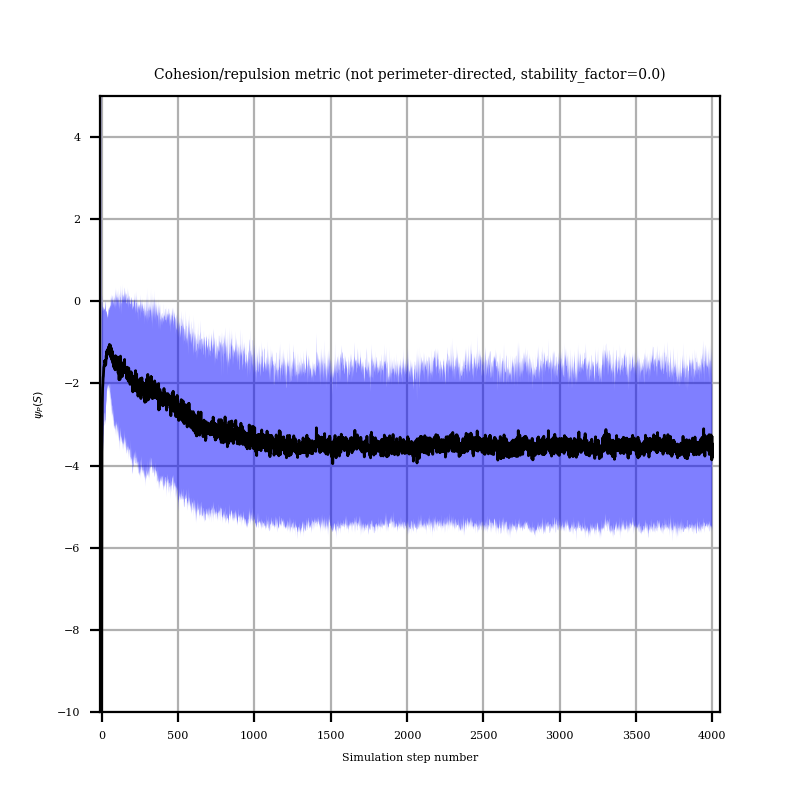

In [130]:
b = np.copy(init)
n_steps = 4000                                                                          # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    compute_step(b, scaling='quadratic', speed=0.2, perimeter_directed=False, stability_factor=0.0) # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(-10, n_steps+50), ylim=(-10, 5))  
ax.set_title('Cohesion/repulsion metric (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

In [666]:
# Latest model

import json
import numpy as np
from numba import jit, prange

# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor
PRM    = 17   # if True agent known to be on perimeter of swarm
COH_N  = 18   # number of cohesion neighbours
REP_N  = 19   # number of repulsion neighbours

N_ROWS = 20   # number of rows in array that models swarm state
eps    = np.finfo('float64').eps # smallest positive 64 bit float value

default_swarm_params = {
    'cb' : 4.0,
    'rb' : 3.0,
    'ob' : 3.0,
    'kc' : 1.0,
    'kr' : 1.0,
    'kd' : 0.0,
    'ko' : 0.0,
    'scaling' : 'linear',
    'exp_rate' : 0.2,
    'speed' : 0.05,
    'stability_factor' : 0.0,
    'pc' : 1.0,
    'pr' : 1.0
}

def mk_rand_swarm(n, *, cb=4.0, rb=3.0, kc=1.0, kr=1.0, kd=0.0, goal=[[0.0], [0.0]], loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents.

    :param n:      number of agents
    :param cb:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rb:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    prng = np.random.default_rng(seed)
    np.copyto(b[POS_X:POS_Y + 1,:], (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n)) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal[0], goal[1]], default [0.0, 0.0]
    print(f"Goal is {b[GOAL_X:GOAL_Y + 1,:]}") 
    b[CF,:] = cb                                    # cohesion field of all agents set to cb
    b[RF,:] = rb                                    # repulsion field of all agents set to rb
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

def mk_swarm(xs, ys, *, cb=4.0, rb=3.0, kc=1.0, kr=1.0, kd=0.0, goal=[[0.0], [0.0]]):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents.

    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cb:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rb:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    np.copyto(b[POS_X], xs)                         # place agents as specified
    np.copyto(b[POS_Y], ys)                         # place agents as specified
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = cb                                    # cohesion field of all agents set to cb
    b[RF,:] = rb                                    # repulsion field of all agents set to rb
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

@jit(nopython=True, fastmath=True, cache=True)
def all_pairs_mag(b, xv, yv, mag, ecb):
    n_agents = b.shape[1]
    b[COH_N].fill(0.)
    for i in range(n_agents):
        for j in range(i):
            xv[i,j] = b[POS_X][i] - b[POS_X][j]
            xv[j,i] = -xv[i,j]
            yv[i,j] = b[POS_Y][i] - b[POS_Y][j]
            yv[j,i] = -yv[i,j]
            mag[i,j] = np.sqrt(xv[i,j] ** 2 + yv[i,j] ** 2)
            mag[j,i] = mag[i,j]
            if mag[j,i] <= ecb[j,i]:
                b[COH_N][i] = b[COH_N][i] + 1
                b[COH_N][j] = b[COH_N][j] + 1
        xv[i,i] = 0.0
        yv[i,i] = 0.0
        mag[i,i] = 0.0

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_coh(b, xv, yv, mag, ecb, ekc):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[COH_X][i] = 0.0
        b[COH_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecb[j, i]:
                b[COH_X][i] = b[COH_X][i] + (xv[j,i] * ekc[j,i])
                b[COH_Y][i] = b[COH_Y][i] + (yv[j,i] * ekc[j,i])

@jit(nopython=True, fastmath=True, cache=True)
def nbr_sort(a, ang, i):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (ang[:,i][a[k]] < ang[:,i][a[jmin]]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def onPerim(b, xv, yv, mag, ecb):
    n_agents = b.shape[1]
    result = np.full(n_agents, False)
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    for i in prange(n_agents):
        if b[COH_N][i] < 3:
            result[i] = True
            continue
        nbrs = np.full(int(b[COH_N][i]), 0)
        k = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecb[j, i]:
                nbrs[k] = j
                k += 1
        nbr_sort(nbrs, ang, i)
        for j in range(int(b[COH_N][i])):
            k = (j + 1) % int(b[COH_N][i])
            if mag[nbrs[k],nbrs[j]] > ecb[nbrs[k],nbrs[j]]:    # nbrs[j] and nbrs[k] are not cohesion neighbours
                result[i] = True
                break
            delta = ang[:,i][nbrs[k]] - ang[:,i][nbrs[j]]
            if (delta < 0):
                delta += np.pi * 2.0;
            if (delta > np.pi):
                result[i] = True;
                break;
    return result, ang

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_erf(b, cscale, rscale):
    n_agents = b.shape[1]
    erf = np.empty((n_agents, n_agents))
    ekc = np.empty((n_agents, n_agents))
    ekr = np.empty((n_agents, n_agents))
    for i in prange(n_agents):
        for j in range(n_agents):
            if b[PRM][i] and b[PRM][j]:
                erf[i,j] = b[RF][i] * rscale
                ekc[i,j] = b[KC][i] * cscale
                ekr[i,j] = b[KR][i]
            else:
                erf[i,j] = b[RF][i]
                ekc[i,j] = b[KC][i]
                ekr[i,j] = b[KR][i]
    return erf, ekc, ekr

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_linear(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (1. - (erf[i,j] / mag[j,i])) * xv[j,i] * ekr[j,i]
                b[REP_Y][i] = b[REP_Y][i] + (1. - (erf[i,j] / mag[j,i])) * yv[j,i] * ekr[j,i]

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_quadratic(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (mag[j,i] ** -2) * (xv[j,i] / mag[j,i]) * ekr[j,i])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (mag[j,i] ** -2) * (yv[j,i] / mag[j,i]) * ekr[j,i])

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (xv[j,i] / mag[j,i]) * ekr[j,i])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (yv[j,i] / mag[j,i]) * ekr[j,i])

@jit(nopython=True, fastmath=True, cache=True)
def update_resultant(b, stability_factor, speed):
    n_agents = b.shape[1]
    for i in range(n_agents):
        mag_res = np.sqrt(b[RES_X][i] ** 2 + b[RES_Y][i] ** 2)
        if mag_res > stability_factor * speed:
            b[RES_X][i] = b[RES_X][i] / mag_res * speed
            b[RES_Y][i] = b[RES_Y][i] / mag_res * speed
        else:
            b[RES_X][i] = 0.0
            b[RES_Y][i] = 0.0

def compute_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):
    """
    Compute one step in the evolution of swarm `b`, update the COH, REP, DIR and RES fields
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param pc: determines the amount by which the cohesion weight should be increased for perimeter agents
                                     e.g. a pc of 2.0 causes the size of the cohesion weight to be doubled
    :param pr: determines the amount by which the repulsion field should be reduced for perimeter agents,
                                     e.g. a pr of 0.5 causes the size of the repulsion field to be halved
    """
    # print(scaling, exp_rate, speed, perim_coord, stability_factor, pr)
    n_agents = b.shape[1]
    ecb = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv = np.empty((n_agents, n_agents))
    yv = np.empty((n_agents, n_agents))
    mag = np.empty((n_agents, n_agents))
    all_pairs_mag(b, xv, yv, mag, ecb)

    # compute the perimeter
    b[PRM], ang = onPerim(b, xv, yv, mag, ecb)

   # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf(b, pc, pr)

    # compute the cohesion vectors
    compute_coh(b, xv, yv, mag, ecb, ekc)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        compute_rep_quadratic(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[PRM] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

    # normalise the resultant and update for speed, adjusted for stability
    update_resultant(b, stability_factor, speed)

    return xv, yv, mag, ang, ecb, erf, ekc, ekr         # helpful in calculation of metrics, instrumentation, debugging

def apply_step(b):
    """
    Assuming the step has been computed so that RES fields are up to date, update positions
    """
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]

def d_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, pc=pc, pr=pr)
    apply_step(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr

@jit(nopython=True, fastmath=True)
def mu_sigma_d(mag, ecb):
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= ecb[j, i]:
                msum += mag[j, i]
                msum_sq += mag[j, i] **2
                nsum += 1
            if mag[i, j] <= ecb[i, j]:
                msum += mag[i, j]
                msum_sq += mag[i, j] **2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

def mu_sigma_p(b):
    vcr_x = b[COH_X] + b[REP_X]                                 # the weighted cohesion/repulsion vector of every agent
    vcr_y = b[COH_Y] + b[REP_Y]
    vcr_mag = np.hypot(vcr_x, vcr_y)                            # the magnitude of the weighted cohesion/repulsion vector of every agent
    vc_mag = np.hypot(b[COH_X], b[COH_Y])                       # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = np.hypot(b[REP_X], b[REP_Y])                       # the magnitude of the repulsion component of the cohesion/repulsion vector
    P = np.where(vc_mag > vr_mag, vcr_mag, -vcr_mag)            # the implementation of P as defined
    n_agents = b.shape[1]                                       # the total number of agents in the swarm
    mu_p = np.sum(P) / n_agents                                 # the mean
    sigma_p = np.sqrt(np.sum((P - mu_p) ** 2) / n_agents)       # the standard deviation
    return mu_p, sigma_p

'''
Data persistence methods
'''

def saveState(b, path):
    """
    Save state of a swarm model
    :b: numpy array representing state of a swarm
    :path: path to a file to which the data are to be saved
    """
    with open(path, 'wt') as f:
        for n in range(np.ma.size(b,1)):
          for r in range(np.ma.size(b,0)):
              f.write("{:f}\t".format(b[r][n]))
          f.write("\n")
        f.close()
    print("{:d} agents saved.".format(np.ma.size(b,1)))

def loadState(path):
    """
    Load state of a swarm model from saved data
    :b: numpy array representing state of a swarm
    :path: path to a file from which the data are to be loaded
    """
    with open(path, 'rt') as f:
      lines = f.readlines()
    f.close()
    print("{:d} lines read.".format(len(lines)))
    nums = [[float(x) for x in line.split()] for line in lines]
    return np.transpose(np.array(nums))

def readCoords(path):
    """
    Read a set of coordinates for agents from a text file of lines each
    containing an x- and a y- coordinate.
    Return two lists, xs, ys for use by make_swarm(...) function
    :path: path to a file from which the data are to be loaded
    """
    with open(path, 'rt') as f:
      lines = f.readlines()
    f.close()
    cds = []
    for ln in lines:
      for wd in ln.split():
        cds.append(float(wd))
    xs = cds[0::2]
    ys = cds[1::2]
    return xs, ys

def dump_swarm(b, swarm_args, step_args):
    goal = swarm_args['goal']
    swarm_args = {k:v for k,v in swarm_args.items() if k in ['cb', 'rb', 'kc', 'kr', 'kd']}
    coords = b[POS_X:POS_Y+1,:].tolist()
    coords.append([0.0] * b.shape[1])
    state = {
        'params': {**default_swarm_params, **swarm_args, **step_args},
        'agents': {'coords': coords}, 
        'destinations' : {'coords': [goal[0], goal[1], [0.0]]},
        'obstacles' : {'coords': [[],[],[]]} 
    }
    with open('swarm.json', 'w') as f:
        json.dump(state, f)
        f.close()

def load_swarm():
    with open('swarm.json', 'r') as f:
        state = json.load(f)
        f.close()
    swarm_args = {k:v for k,v in state['params'].items() if k in ['cb', 'rb', 'kc', 'kr', 'kd']}
    if state['destinations']['coords'] == [[],[],[]]:
        swarm_args['goal'] = [[0.0],[0.0]]
    else:
        swarm_args['goal'] = np.array(state['destinations']['coords'])[:2,0].reshape(2,1).tolist()
    step_args = {k:v for k,v in state['params'].items() if k in ['scaling', 'exp_rate', 'speed', 'perim_coord', 'stability_factor', 'pc', 'pr']} 
    b = mk_swarm(state['agents']['coords'][0], state['agents']['coords'][1], **swarm_args)
    goal = state['destinations']['coords'][:][0]
    return b, step_args

def run_simulation(b, *, with_perimeter=False, step=d_step, **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=(-15, 15), ylim=(-15, 15))                  # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = b[PRM].astype(bool)
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=2) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=2)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

def log_experiment(n_steps=300):
    b, step_args = load_swarm()
    n_agents = b.shape[1]
    with open('exp.pp.csv', 'wt') as f:
        f.write("STEP|ID|X|Y|PERIM|CX|CY|CMAG|RX|RY|RMAG|IX|IY|IMAG|DX|DY|DMAG|CHANGEX|CHANGEY|CHANGEMAG\n")
        for step in range(n_steps):
            xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, **step_args)
            for agent in range(n_agents):
                f.write(f"{step}|{agent}|{b[POS_X,agent]}|{b[POS_Y,agent]}|{b[PRM,agent].astype(bool)}|{b[COH_X,agent]}|{b[COH_Y,agent]}|{np.hypot(b[COH_X,agent],b[COH_Y,agent])}|{b[REP_X,agent]}|{b[REP_Y,agent]}|{np.hypot(b[REP_X,agent],b[REP_Y,agent])}|{b[COH_X,agent]+b[REP_X,agent]}|{b[COH_Y,agent]+b[REP_Y,agent]}|{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])}|{b[DIR_X,agent]}|{b[DIR_Y,agent]}|{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])}|{b[RES_X,agent]}|{b[RES_Y,agent]}|{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")      
            apply_step(b)
    f.close()
    
def log_experiment2(n_steps=300):
    b, step_args = load_swarm()
    n_agents = b.shape[1]
    with open('exp.pp2.csv', 'wt') as f:
        f.write("STEP|ID|X|Y|PERIM|CX|CY|CMAG|RX|RY|RMAG|IX|IY|IMAG|DX|DY|DMAG|CHANGEX|CHANGEY|CHANGEMAG\n")
        for step in range(n_steps):
            xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step2(b, **step_args)
            for agent in range(n_agents):
                f.write(f"{step}|{agent}|{b[POS_X,agent]}|{b[POS_Y,agent]}|{b[PRM,agent].astype(bool)}|{b[COH_X,agent]}|{b[COH_Y,agent]}|{np.hypot(b[COH_X,agent],b[COH_Y,agent])}|{b[REP_X,agent]}|{b[REP_Y,agent]}|{np.hypot(b[REP_X,agent],b[REP_Y,agent])}|{b[COH_X,agent]+b[REP_X,agent]}|{b[COH_Y,agent]+b[REP_Y,agent]}|{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])}|{b[DIR_X,agent]}|{b[DIR_Y,agent]}|{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])}|{b[RES_X,agent]}|{b[RES_Y,agent]}|{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")      
            apply_step2(b)
    f.close()
    
def check_steps(n_steps=300):
    b1, step_args = load_swarm()
    b2 = np.copy(b1)
    for step in range(n_steps):
        xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b1, **step_args)
        xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step2(b2, **step_args)
        if np.count_nonzero(np.abs(b1 - b2) <= 100.0 ** -1) != 200:
            break
        apply_step(b1)
        apply_step(b2)
    return (step, b1, b2)
    

In [680]:
# Latest pure numpy model
def all_pairs_mag2(b):
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    return xv, yv, mag

def compute_coh2(b, xv, yv, mag, ecf, ekc, coh_n):
    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv * ekc, 0.0)
    yv_coh = np.where(coh_n, yv * ekc, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences

def onPerim2(b, xv=None, yv=None, mag=None, coh_n=None, ecf=None):
    """
    Determines the perimeter status of all agents in swarm b. Can make use of previous computations,
    if available, to improve overall efficiency.
    
    :param b: a data structure representing the swarm
    :param xv: all pairs differences in x-values
    :param yv: all pairs differences in y-values
    :param mag: all pairs distances between agents
    :param coh_n: all pairs cohesion neighbour status
    :returns: a numpy array of bools, one element per agent set to True if agent is on perimeter and False otherwise
    """
    if xv is None:
        xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
        yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
        mag = np.hypot(xv, yv)                      # all pairs magnitudes
        ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
        coh_n = mag <= ecf                          # cohesion neighbours
        np.fill_diagonal(coh_n, False)              # no agent is a cohesion neighbour of itself
    else:
        assert(not (yv is None or mag is None or coh_n is None))
        
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    ang_coh = np.where(coh_n, ang, 10.0)        # polar angle for pairs of agents within coh range; otherwise dummy value of 10

    def isAgentOnPerimeter(nba):
        """
        Determines the perimeter status of a single agent
        
        :param nba: array of neighbour angles for all cohesion neighbours of one agent
        :returns: True if perimeter condition is satisfied, otherwise False
        """
        nr = np.count_nonzero(nba<10)   # angles of coh neighbours are nba[i] for 0 <= i < nr
        if nr < 3:                     # agent has no nbrs ... 
            is_on_perimeter = True      # ... so perimeter condition satisfied immediately
        else:
            nbi = np.argsort(nba, axis=0).astype(int)[0:nr] # nbi indexes nba in ascending order of angle, losing dummy values
            adj = np.row_stack((nbi, np.roll(nbi,-1)))      # 2 x nr array of adjacent neighbours in which for 0 <= i < nr, adj[0, i] == nbi[i] and adj[1, i] == nbi[i + 1 % nr]

            def perimeterTest(p):           # the helper's helper
                """
                Tests if a pair of an agent's adjacent neighbours give the agent the 'perimeter-iness' property
                
                :param p: p is an array of shape (2,1) in which p[0] and p[1] are a pair of adjacent neighbours in polar angle order
                """
                if not coh_n[p[1],p[0]]:    # the adjacent pair are not cohesion neighbours of each other ...
                    result = True           # ... so the agent under consideration is on the perimeter
                else:
                    delta = nba[p[1]] - nba[p[0]]   # compute the angle between the adjacent neighbour pair
                    if delta < 0:
                        delta += np.pi * 2.0
                    result = (delta > np.pi)        # agent under consideration is on the perimeter if this is a reflex angle
                return result
            
            is_on_perimeter = np.any(np.apply_along_axis(perimeterTest, 0, adj))    # agent is on perimeter if any pair of its adjacent cohesion neighbours satisfies the perimeter test
        return is_on_perimeter

    return np.apply_along_axis(isAgentOnPerimeter, 0, ang_coh), ang

def compute_erf2(b, cscale, pscale):
    perimeter_pairs = np.logical_and.outer(b[PRM], b[PRM]) # 2-D boolean matrix where element is True only if both agents on perimeter
    erf = np.outer(b[RF], np.ones(b[RF].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[RF]
    erf = np.where(perimeter_pairs, erf * pscale, erf)      # apply repulsion field reduction only to perimeter agent pairs
    ekc = np.outer(b[KC], np.ones(b[KC].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[KC]
    ekc = np.where(perimeter_pairs, ekc * cscale, ekc)      # apply repulsion field reduction only to perimeter agent pairs
    ekr = np.outer(b[KR], np.ones(b[KR].shape[0]))         # 2-D float64 matrix where all elements are initially equal to b[KR]
#     ekr = np.where(perimeter_pairs, ekr * scale, ekr)      # apply repulsion field reduction only to perimeter agent pairs
    return erf, ekc, ekr

def compute_rep_linear2(b, xv, yv, mag, erf, ekr):
    # compute the repulsion neighbours
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)                     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0)               # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    rscalar = (1. - (erf[rep_n] / mag[rep_n]))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences

def compute_rep_quadratic2(b, xv, yv, mag, erf, ekr):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (mag_nz[rep_n] ** (-2))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences

def compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences


def update_resultant2(b, stability_factor, speed):
    mag_res = np.broadcast_to(np.hypot(b[RES_X], b[RES_Y]), b[RES_X:RES_Y+1].shape)
    enz = mag_res > stability_factor * speed                                           # mag effectively non-zero
    b[RES_X:RES_Y+1][enz] = b[RES_X:RES_Y+1][enz] / mag_res[enz] * speed
    b[RES_X:RES_Y+1][np.logical_not(enz)] = 0.0

def compute_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):
    """
    Compute one step in the evolution of swarm `b`
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param perimeter_packing_factor: determines the amount by which the repulsion field should be reduced for perimeter agents, 
                                     e.g. a perimeter_packing_factor of 0.5 causes the size of the repulsion field to be halved
    """
    n_agents = b.shape[1]
    ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv, yv, mag = all_pairs_mag2(b)
    
   # compute the cohesion neighbours
    coh_n = mag <= b[CF]
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the perimeter
    b[PRM], ang = onPerim2(b, xv, yv, mag, coh_n)

    # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf2(b, pc, pr)

    # compute the cohesion vectors 
    compute_coh2(b, xv, yv, mag, ecf, ekc, coh_n)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear2(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        compute_rep_quadratic2(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[PRM] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]
                  
    # normalise the resultant and update for speed, adjusted for stability    
    update_resultant2(b, stability_factor, speed)

    return xv, yv, mag, ang, ecf, erf, ekc, ekr         # helpful in the calculation of metrics and for debugging

def apply_step2(b):
    # update positions
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]            

def d_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):    
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step2(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, pc=pc, pr=pr)
    apply_step2(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr

In [687]:
init, step_args = load_swarm()

In [688]:
b = np.copy(init)
n_agents = b.shape[1]
ecb1 = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
xv1 = np.empty((n_agents, n_agents))
yv1 = np.empty((n_agents, n_agents))
mag1 = np.empty((n_agents, n_agents))
all_pairs_mag(b, xv1, yv1, mag1, ecb1)


In [691]:
b[POS_X:POS_Y+1]

array([[-2.18000031,  1.53999901, -1.44000053,  0.        ,  1.75999832,
        -0.54000092,  1.1799984 ,  0.21999931,  0.1799984 , -1.20000076],
       [-0.19999981, -0.26000023,  0.89999962,  0.        , -1.10000038,
        -1.02000046,  0.67999935,  1.63999939, -1.86000061, -1.65999985]])

In [723]:
b[POS_Y][3] - b[POS_Y][1]

0.26000022888183594

In [724]:
yv[3,1]

0.26000022888183594

In [777]:
np.hypot(xv[1,0], yv[1,0])

3.7204831597135435

In [722]:
mag[1,3]

1.5617929005505244

In [708]:
np.sqrt(xv[1,0] * xv[1,0] + yv[1,0] * yv[1,0])

3.7204831597135435

In [776]:
np.sqrt(xv[1,0] ** 2 + yv[1,0] ** 2)

3.7204831597135435

In [784]:
ekc1.dtype

dtype('float64')

In [785]:
ekc2.dtype

dtype('float64')

In [703]:
xv

array([[ 0.        , -3.71999931, -0.73999977, -2.18000031, -3.93999863,
        -1.63999939, -3.3599987 , -2.39999962, -2.3599987 , -0.97999954],
       [ 3.71999931,  0.        ,  2.97999954,  1.53999901, -0.21999931,
         2.07999992,  0.36000061,  1.31999969,  1.36000061,  2.73999977],
       [ 0.73999977, -2.97999954,  0.        , -1.44000053, -3.19999886,
        -0.89999962, -2.61999893, -1.65999985, -1.61999893, -0.23999977],
       [ 2.18000031, -1.53999901,  1.44000053,  0.        , -1.75999832,
         0.54000092, -1.1799984 , -0.21999931, -0.1799984 ,  1.20000076],
       [ 3.93999863,  0.21999931,  3.19999886,  1.75999832,  0.        ,
         2.29999924,  0.57999992,  1.53999901,  1.57999992,  2.95999908],
       [ 1.63999939, -2.07999992,  0.89999962, -0.54000092, -2.29999924,
         0.        , -1.71999931, -0.76000023, -0.71999931,  0.65999985],
       [ 3.3599987 , -0.36000061,  2.61999893,  1.1799984 , -0.57999992,
         1.71999931,  0.        ,  0.95999908

In [698]:
yv

array([[ 0.        ,  0.06000042, -1.09999943, -0.19999981,  0.90000057,
         0.82000065, -0.87999916, -1.8399992 ,  1.6600008 ,  1.46000004],
       [-0.06000042,  0.        , -1.15999985, -0.26000023,  0.84000015,
         0.76000023, -0.93999958, -1.89999962,  1.60000038,  1.39999962],
       [ 1.09999943,  1.15999985,  0.        ,  0.89999962,  2.        ,
         1.92000008,  0.22000027, -0.73999977,  2.76000023,  2.55999947],
       [ 0.19999981,  0.26000023, -0.89999962,  0.        ,  1.10000038,
         1.02000046, -0.67999935, -1.63999939,  1.86000061,  1.65999985],
       [-0.90000057, -0.84000015, -2.        , -1.10000038,  0.        ,
        -0.07999992, -1.77999973, -2.73999977,  0.76000023,  0.55999947],
       [-0.82000065, -0.76000023, -1.92000008, -1.02000046,  0.07999992,
         0.        , -1.69999981, -2.65999985,  0.84000015,  0.63999939],
       [ 0.87999916,  0.93999958, -0.22000027,  0.67999935,  1.77999973,
         1.69999981,  0.        , -0.96000004

In [704]:
mag

array([[0.        , 3.72048316, 1.32574447, 2.18915537, 4.04148366,
        1.83357549, 3.47332547, 3.02416852, 2.88534167, 1.75840815],
       [3.72048316, 0.        , 3.19781127, 1.5617929 , 0.86833171,
        2.21449769, 1.00657819, 2.31352496, 2.09990545, 3.07694616],
       [1.32574447, 3.19781127, 0.        , 1.69811685, 3.77359148,
        2.12047155, 2.62921937, 1.81747054, 3.20031214, 2.57122484],
       [2.18915537, 1.5617929 , 1.69811685, 0.        , 2.07547463,
        1.15412388, 1.36190871, 1.65468961, 1.86868983, 2.04831671],
       [4.04148366, 0.86833171, 3.77359148, 2.07547463, 0.        ,
        2.30139012, 1.87211083, 3.14311878, 1.75328267, 3.01250626],
       [1.83357549, 2.21449769, 2.12047155, 1.15412388, 2.30139012,
        0.        , 2.41834592, 2.76644167, 1.106345  , 0.91934706],
       [3.47332547, 1.00657819, 2.62921937, 1.36190871, 1.87211083,
        2.41834592, 0.        , 1.3576444 , 2.72976186, 3.33766269],
       [3.02416852, 2.31352496, 1.8174705

In [725]:
b[COH_N]

array([5., 6., 6., 9., 5., 9., 7., 5., 7., 5.])

In [726]:
ecb1

array([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])

In [729]:
coh_n = mag <= ecb
np.fill_diagonal(coh_n, False)
np.sum(coh_n, axis=1)

array([5, 6, 6, 9, 5, 9, 7, 5, 7, 5])

In [730]:
coh_n

array([[False, False,  True,  True, False,  True, False, False,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
        False],
       [ True, False, False,  True, False,  True,  True,  True, False,
         True],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
         True],
       [False,  True, False,  True, False,  True,  True, False,  True,
        False],
       [ True,  True,  True,  True,  True, False,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True, False,  True,  True,
        False],
       [False,  True,  True,  True, False,  True,  True, False, False,
        False],
       [ True,  True, False,  True,  True,  True,  True, False, False,
         True],
       [ True, False,  True,  True, False,  True, False, False,  True,
        False]])

In [733]:
mag[:,3]

array([2.18915537, 1.5617929 , 1.69811685, 0.        , 2.07547463,
       1.15412388, 1.36190871, 1.65468961, 1.86868983, 2.04831671])

In [734]:
b = np.copy(init)
n_agents = b.shape[1]
ecb1 = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
xv1 = np.empty((n_agents, n_agents))
yv1 = np.empty((n_agents, n_agents))
mag1 = np.empty((n_agents, n_agents))
all_pairs_mag(b, xv1, yv1, mag1, ecb1)

# compute the perimeter
b[PRM], ang = onPerim(b, xv1, yv1, mag1, ecb1)
prm1 = b[PRM]

# compute the effective repulsion field, cohesion weight and repulsion weight
erf1, ekc1, ekr1 = compute_erf(b, step_args['pc'], step_args['pr'])

# compute the cohesion vectors
compute_coh(b, xv1, yv1, mag1, ecb1, ekc1)
b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours
coh1 = b[COH_X:COH_Y+1]

# compute the repulsion vectors
compute_rep_linear(b, xv1, yv1, mag1, erf1, ekr1)
b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
rep1 = b[REP_X:REP_Y+1]

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])
dir1 = b[DIR_X:DIR_Y+1]

b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

# normalise the resultant and update for speed, adjusted for stability
update_resultant(b, step_args['stability_factor'], step_args['speed'])
res1 = b[RES_X:RES_Y+1]

In [738]:
coh_n = mag <= ecb1
np.fill_diagonal(coh_n, False)
np.sum(coh_n,axis=0)

array([5, 6, 6, 9, 5, 9, 7, 5, 7, 5])

In [769]:
xv_coh = np.where(coh_n, xv1, 0.0)
tot_xv_coh = np.sum(xv_coh,axis=0) 
avg_xv_coh = tot_xv_coh / b[COH_N]

In [770]:
tot_xv_coh

array([ 7.89999771, -6.44000053,  6.11999893, -0.48000908, -6.43999672,
        4.92000008, -6.53999519, -0.36000061, -0.69999504,  2.02000046])

In [771]:
avg_xv_coh

array([ 1.57999954, -1.07333342,  1.01999982, -0.05333434, -1.28799934,
        0.54666668, -0.93428503, -0.07200012, -0.09999929,  0.40400009])

In [772]:
wgt_xv_coh = avg_xv_coh * 0.15

In [773]:
wgt_xv_coh

array([ 0.23699993, -0.16100001,  0.15299997, -0.00800015, -0.1931999 ,
        0.082     , -0.14014275, -0.01080002, -0.01499989,  0.06060001])

In [763]:
b[PRM]

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 1.])

In [774]:
coh_n[:,0]

array([False, False,  True,  True, False,  True, False, False,  True,
        True])

In [745]:
coh1

array([[ 2.5625989 , -1.50050083,  1.94849947, -0.00800015, -1.54979948,
         0.082     , -1.62214179,  0.34259939,  0.06642977,  0.15179993],
       [-1.23060092,  0.18749934, -1.64049975, -0.04800005,  1.15139985,
         0.12200003, -1.79957104, -2.28899972,  2.95500105,  2.36099932]])

In [746]:
b[POS_X:POS_Y+1]

array([[-2.18000031,  1.53999901, -1.44000053,  0.        ,  1.75999832,
        -0.54000092,  1.1799984 ,  0.21999931,  0.1799984 , -1.20000076],
       [-0.19999981, -0.26000023,  0.89999962,  0.        , -1.10000038,
        -1.02000046,  0.67999935,  1.63999939, -1.86000061, -1.65999985]])

In [757]:
coh_n[:,0]

array([False, False,  True,  True, False,  True, False, False,  True,
        True])

In [755]:
xv_coh = np.where(coh_n, xv, 0.0)
xv_coh[:,0]

array([0.        , 0.        , 0.73999977, 2.18000031, 0.        ,
       1.63999939, 0.        , 0.        , 2.3599987 , 0.97999954])

In [756]:
mag[:,0]

array([0.        , 3.72048316, 1.32574447, 2.18915537, 4.04148366,
       1.83357549, 3.47332547, 3.02416852, 2.88534167, 1.75840815])

In [761]:
b[POS_Y,coh_n[:,0]]

array([ 0.89999962,  0.        , -1.02000046, -1.86000061, -1.65999985])

In [675]:
b = np.copy(init)
n_agents = b.shape[1]
ecb2 = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
xv2, yv2, mag2 = all_pairs_mag2(b)

# compute the cohesion neighbours
coh_n = mag <= ecb2
np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours

# compute the perimeter
b[PRM], ang = onPerim2(b, xv2, yv2, mag2, coh_n)
prm2 = b[PRM]

# compute the effective repulsion field, cohesion weight and repulsion weight
erf2, ekc2, ekr2 = compute_erf2(b, step_args['pc'], step_args['pr'])

# compute the cohesion vectors 
compute_coh2(b, xv2, yv2, mag2, ecb2, ekc2, coh_n)
b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours
coh2 = b[COH_X:COH_Y+1]

# compute the repulsion vectors
compute_rep_linear2(b, xv2, yv2, mag2, erf2, ekr2)
b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
rep2 = b[REP_X:REP_Y+1]

# compute the direction vectors
b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])
dir2 = b[DIR_X:DIR_Y+1]

# compute the resultant of the cohesion, repulsion and direction vectors
b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

# normalise the resultant and update for speed, adjusted for stability    
update_resultant2(b, step_args['stability_factor'], step_args['speed'])
res2 = b[RES_X:RES_Y+1]

In [676]:
xc = np.count_nonzero(np.abs(xv1 - xv2) <= 10000000000000.0 ** -1)
yc = np.count_nonzero(np.abs(yv1 - yv2) <= 10000000000000.0 ** -1)
mc = np.count_nonzero(np.abs(mag1 - mag2) <= 10000000000000.0 ** -1)
erfc = np.count_nonzero(np.abs(erf1 - erf2) <= 10000000000000.0 ** -1)
ekcc = np.count_nonzero(np.abs(ekc1 - ekc2) <= 10000000000000.0 ** -1)
ekrc = np.count_nonzero(np.abs(ekr1 - ekr2) <= 10000000000000.0 ** -1)
prmc = np.count_nonzero(np.abs(prm1 - prm2) <= 10000000000000.0 ** -1)
cohc = np.count_nonzero(np.abs(coh1 - coh2) <= 10000000000000.0 ** -1)
repc = np.count_nonzero(np.abs(rep1 - rep2) <= 10000000000000.0 ** -1)
dirc = np.count_nonzero(np.abs(dir1 - dir2) <= 10000000000000.0 ** -1)
resc = np.count_nonzero(np.abs(res1 - res2) <= 10000000000000.0 ** -1)
(xc,yc,mc,erfc,ekcc,ekrc,prmc,cohc,repc,dirc,resc)

(100, 100, 100, 100, 100, 100, 10, 20, 20, 20, 20)

In [642]:
coh1

array([[ 2.5625989 , -1.50050083,  1.94849947, -0.00800015, -1.54979948,
         0.082     , -1.62214179,  0.34259939,  0.06642977,  0.15179993],
       [-1.23060092,  0.18749934, -1.64049975, -0.04800005,  1.15139985,
         0.12200003, -1.79957104, -2.28899972,  2.95500105,  2.36099932]])

In [603]:
coh2

array([[ 2.5625989 , -1.50050083,  1.94849947, -0.00800015, -1.54979948,
         0.082     , -1.62214179,  0.34259939,  0.06642977,  0.15179993],
       [-1.23060092,  0.18749934, -1.64049975, -0.04800005,  1.15139985,
         0.12200003, -1.79957104, -2.28899972,  2.95500105,  2.36099932]])

In [519]:
ekc2

array([[3.00000012, 3.00000012, 3.00000012, 0.15000001, 3.00000012,
        0.15000001, 3.00000012, 3.00000012, 3.00000012, 3.00000012],
       [3.00000012, 3.00000012, 3.00000012, 0.15000001, 3.00000012,
        0.15000001, 3.00000012, 3.00000012, 3.00000012, 3.00000012],
       [3.00000012, 3.00000012, 3.00000012, 0.15000001, 3.00000012,
        0.15000001, 3.00000012, 3.00000012, 3.00000012, 3.00000012],
       [0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001,
        0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001],
       [3.00000012, 3.00000012, 3.00000012, 0.15000001, 3.00000012,
        0.15000001, 3.00000012, 3.00000012, 3.00000012, 3.00000012],
       [0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001,
        0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001],
       [3.00000012, 3.00000012, 3.00000012, 0.15000001, 3.00000012,
        0.15000001, 3.00000012, 3.00000012, 3.00000012, 3.00000012],
       [3.00000012, 3.00000012, 3.0000001

<IPython.core.display.Javascript object>


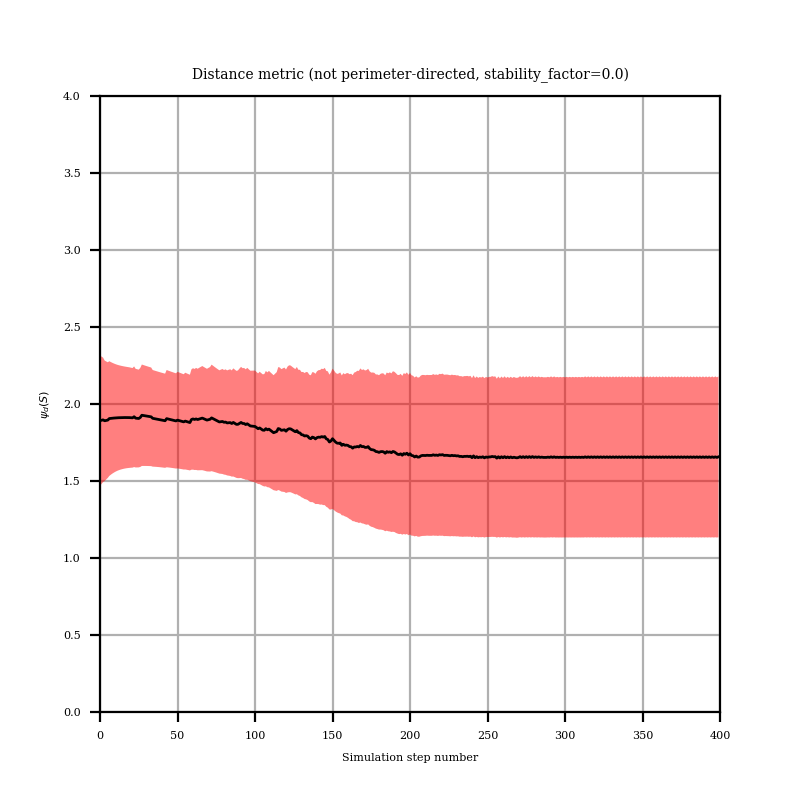

In [132]:
b, step_args = load_swarm()
n_steps = 400                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, **step_args)    # take a step
    m, s = mu_sigma_d(mag, ecf)                                             # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(0, n_steps), ylim=(0, 4))                                   # set the limits of the axes
ax.set_title('Distance metric (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

<IPython.core.display.Javascript object>


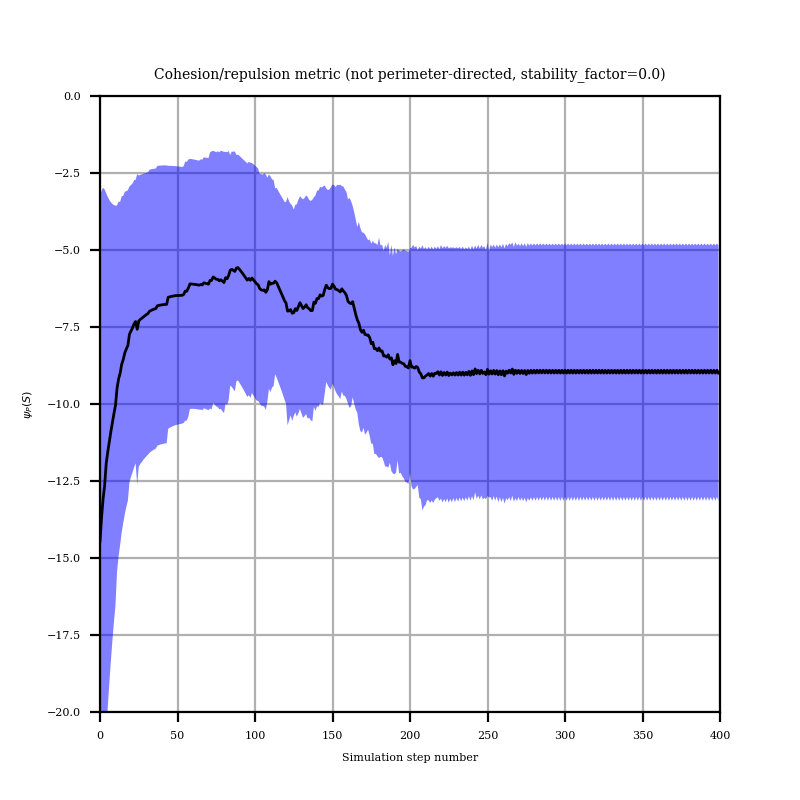

In [133]:
b, step_args = load_swarm()
n_steps = 400                                                                          # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    compute_step(b, **step_args)                                                        # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(0, n_steps), ylim=(-20, 0))  
ax.set_title('Cohesion/repulsion metric (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

{'obstacles': {'coords': [[], [], []]}, 'destinations': {'coords': [[], [], []]}, 'params': {'pr': 0.10000000149011612, 'scaling': 'linear', 'ko': 1000, 'kr': 50, 'speed': 0.05000000074505806, 'rb': 2, 'perim_coord': False, 'ob': 4, 'pc': 20, 'exp_rate': 0.20000000298023224, 'stability_factor': 0, 'kc': 0.15000000596046448, 'kd': 0, 'kg': 0, 'cb': 3}, 'agents': {'coords': [[-2.1800003051757812, 1.539999008178711, -1.4400005340576172, 0, 1.7599983215332031, -0.5400009155273438, 1.1799983978271484, 0.2199993133544922, 0.17999839782714844, -1.2000007629394531], [-0.19999980926513672, -0.26000022888183594, 0.8999996185302734, 0, -1.1000003814697266, -1.0200004577636719, 0.6799993515014648, 1.6399993896484375, -1.8600006103515625, -1.6599998474121094], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, 'info': {'date': '2021-02-26', 'by': 'PSywarm 0.1.6', 'time': '20:01:05.977'}}


<IPython.core.display.Javascript object>


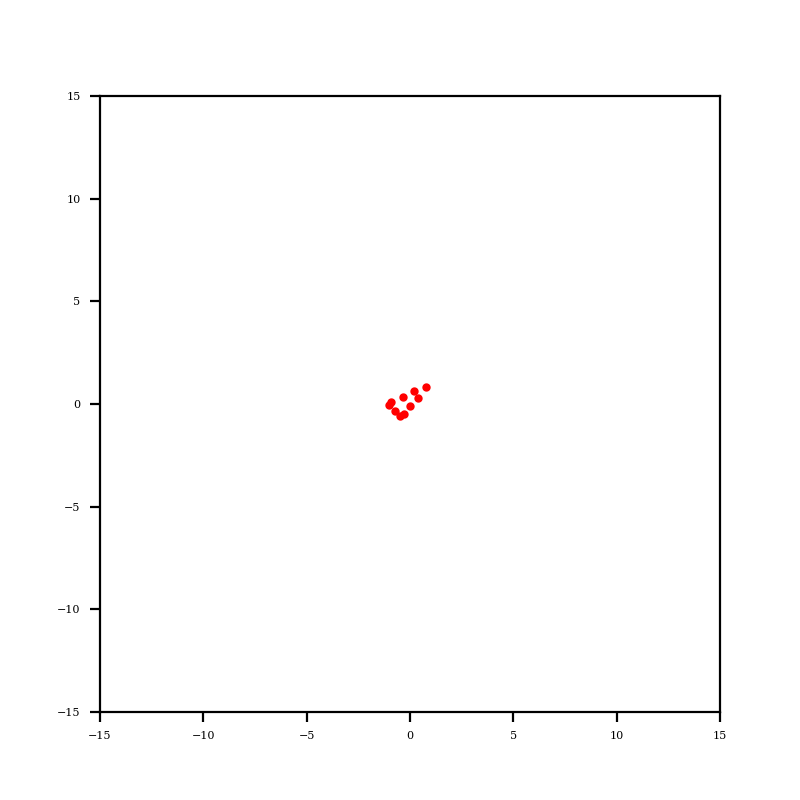

In [655]:
b, step_args = load_swarm()
sim = run_simulation(b, with_perimeter=True, step=d_step, **step_args)


## Conclusions and further work

This notebook describes a very basic swarm simulator that has been implemented using Numpy and Matplotlib. The performance of the simulator seems quite promising. We need to attempt to validate this approach be comparing the results of simulations with those generated by PySwarm. We could then extend the approach to the other algorithms described in (Eliot, 2017) and, following that, could look to implement new algorithms, in particular those involving swarms with heterogeneous field values.

In [677]:
step, b1, b2 = check_steps(n_steps=622)

In [678]:
step

58

In [679]:
np.abs(b1 - b2) <= 10000.0 ** -1

array([[ True, False,  True,  True, False,  True,  True,  True,  True,
         True],
       [ True, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True, False, False, False, False, False, False,
         True],
       [ True, False,  True, False, False,  True, False, False, False,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True, False,  True,  True,  True,  True, False,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True, False,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True, 

In [577]:
np.not_equal(b1[4],b2[4])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [560]:
b1[4]

array([ -7.44272881,  21.60460898, -12.79982263,  -3.26450528,
         0.        ,  -0.658775  ,  27.64306788,   2.29553776,
        14.8557703 , -38.79007211])

In [561]:
b2[4]

array([ -7.44272881,  21.60460898, -12.79982263,  -3.26450528,
         0.        ,  -0.658775  ,  27.64306788,   2.29553776,
        14.8557703 , -38.79007211])

In [562]:
b1[4] == b2[4]

array([False, False,  True, False,  True, False, False, False,  True,
        True])

In [563]:
b1 - b2

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.66453526e-15,  3.55271368e-15,  0.00000000e+00,
         4.44089210e-16,  0.00000000e+00,  4.44089210e-16,
        -3.55271368e-15, -8.88178420e-16,  0.00000000e+00,
         0.

In [775]:
log_experiment(n_steps=622)
log_experiment2(n_steps=622)

In [256]:
b[KC]

array([0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001,
       0.15000001, 0.15000001, 0.15000001, 0.15000001, 0.15000001])

In [257]:
b[KR]

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [258]:
b[CF]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [259]:
state

{'obstacles': {'coords': [[], [], []]},
 'destinations': {'coords': [[], [], []]},
 'params': {'pr': 0.10000000149011612,
  'scaling': 'linear',
  'ko': 1000,
  'kr': 50,
  'speed': 0.05000000074505806,
  'rb': 2,
  'perim_coord': False,
  'ob': 4,
  'pc': 20,
  'exp_rate': 0.20000000298023224,
  'stability_factor': 0,
  'kc': 0.15000000596046448,
  'kd': 4,
  'kg': 0,
  'cb': 3},
 'agents': {'coords': [[-2.1800003051757812,
    1.539999008178711,
    -1.4400005340576172,
    0,
    1.7599983215332031,
    -0.5400009155273438,
    1.1799983978271484,
    0.2199993133544922,
    0.17999839782714844,
    -1.2000007629394531],
   [-0.19999980926513672,
    -0.26000022888183594,
    0.8999996185302734,
    0,
    -1.1000003814697266,
    -1.0200004577636719,
    0.6799993515014648,
    1.6399993896484375,
    -1.8600006103515625,
    -1.6599998474121094],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
 'info': {'date': '2021-02-26', 'by': 'PSywarm 0.1.6', 'time': '20:01:05.977'}}